### Install necessary packages

In [1]:
!pip install --upgrade pip
!pip install numpy==1.24.4
!pip install keras-tuner
!pip install transformers
!pip install aif360
!pip install aif360[Reductions]
!pip install aif360[inFairness]

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Program Files\Python311\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Suppress Warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message=".*functorch.vmap is deprecated.*")

### Importing libraries

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import uniform
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from IPython.display import Markdown, display
import shutil
import matplotlib.pyplot as plt

In [3]:
# Setting random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

### Importing dataset

In [4]:
# Paths to dataset
train_dir = os.path.join("train")
val_dir = os.path.join("val")
train_csv = os.path.join("fairface_label_train_18th.csv")
val_csv = os.path.join("fairface_label_val_18th.csv")

In [5]:
# Loading the dataset
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)

In [6]:
# Encoding gender: 0 for female, 1 for male
train_df['gender'] = train_df['gender'].apply(lambda x: 1 if x.lower() == 'male' else 0)
val_df['gender'] = val_df['gender'].apply(lambda x: 1 if x.lower() == 'male' else 0)

In [7]:
# Combine train and val data
data = pd.concat([train_df, val_df])

# CNN

## Creating subsets with varying levels of bias (SETTING PRIORITY GROUP AS MALE)

## Using 50% of the data

In [45]:
# Create and save biased subsets
ratios = [0.9, 0.8, 0.7, 0.6, 0.5]
total_samples = int(0.5 * len(data))

def create_biased_subset(data, male_ratio, subset_dir, total_samples):
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    
    male_data = data[data['gender'] == 1]
    female_data = data[data['gender'] == 0]
    
    num_male = int(male_ratio * total_samples)
    num_female = total_samples - num_male
    
    num_male = min(num_male, len(male_data))
    num_female = min(num_female, len(female_data))
    
    biased_subset = pd.concat([male_data.sample(num_male, random_state=0), female_data.sample(num_female, random_state=0)])
    
    male_folder = os.path.join(subset_dir, "male")
    female_folder = os.path.join(subset_dir, "female")
    
    if not os.path.exists(male_folder):
        os.makedirs(male_folder)
    if not os.path.exists(female_folder):
        os.makedirs(female_folder)
    
    for index, row in biased_subset.iterrows():
        src_dir = train_dir if row['file'].startswith('train') else val_dir
        img_name = row['file'].split('/')[1]
        gender_folder = 'male' if row['gender'] == 1 else 'female'
        src_path = os.path.join(src_dir, gender_folder, img_name)
        
        if row['gender'] == 1:
            dest_path = os.path.join(male_folder, img_name)
        else:
            dest_path = os.path.join(female_folder, img_name)
        
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
    
    biased_subset.to_csv(os.path.join(subset_dir, 'subset.csv'), index=False)
    return biased_subset

In [9]:
# Create subsets
for ratio in ratios:
    subset_dir = f"subset_{int(ratio*100)}m_{int((1-ratio)*100)}f"
    create_biased_subset(data, ratio, subset_dir, total_samples)

In [8]:
# Function to load images and preprocess
def load_images(image_paths, genders, base_dir):
    images = []
    not_found_count = 0
    for path, gender in zip(image_paths, genders):
        img_name = path.split('/')[1]
        gender_dir = 'male' if gender == 1 else 'female'
        img_path = os.path.join(base_dir, gender_dir, img_name)
        
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=(128, 128))
            img = img_to_array(img)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
        else:
            print(f"Image not found: {img_path}")
            not_found_count += 1
    print(f"Total images not found: {not_found_count}")
    return np.array(images)

### Function to train and evaluate the model

In [105]:
# Function to train and evaluate the model
def train_and_evaluate(subset_dir):
    subset_csv = os.path.join(subset_dir, 'subset.csv')
    biased_subset = pd.read_csv(subset_csv)
    
    X = load_images(biased_subset['file'], biased_subset['gender'], subset_dir)
    y = biased_subset['gender'].values
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    
    # Define and compile the CNN model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the CNN model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
    
    # Evaluate the model
    y_pred = model.predict(X_test).ravel()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    
    # Accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy for {subset_dir}: {accuracy:.4f}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {subset_dir}')
    plt.show()
    
    # Classification Report
    report = classification_report(y_test, y_pred, target_names=["Female", "Male"])
    print(f'Classification Report for {subset_dir}:\n{report}')
    
    # Return the necessary data for bias calculation
    return X_test, y_test, y_pred

### Function to calculate bias

In [12]:
# Function to calculate bias

def calculate_bias(X_test, y_test, y_pred):
    # Print out the first few rows of X_test to check the columns
    print("First few rows of X_test:")
    print(X_test[:5])  # Adjust the number of rows as needed
    
    # Assuming gender is in the first column of the NumPy array X_test
    gender_column = X_test[:, 0]  # Modify if gender is in a different column

    # Create DataFrames for the aif360 datasets
    test_numerical_df = pd.DataFrame({
        'outcome': y_test,  # The true labels
        'gender': gender_column  # The gender column as protected attribute
    })
    
    pred_numerical_df = pd.DataFrame({
        'outcome': y_pred,  # The predicted labels
        'gender': gender_column  # The same protected attribute
    })
    
    # Convert to aif360 BinaryLabelDataset for bias checking
    class ImageGenderDataset(BinaryLabelDataset):
        def __init__(self, df, label_names=['outcome'], protected_attribute_names=['gender']):
            super().__init__(df=df, label_names=label_names, protected_attribute_names=protected_attribute_names)
    
    # Create aif360 datasets
    dataset_orig_test = ImageGenderDataset(df=test_numerical_df)
    dataset_pred = ImageGenderDataset(df=pred_numerical_df)
    
    # Metric for model predictions
    metric_pred = ClassificationMetric(
        dataset_orig_test,
        dataset_pred,
        unprivileged_groups=[{'gender': 0}],
        privileged_groups=[{'gender': 1}]
    )
    
    difference = metric_pred.mean_difference()
    formatted_difference = f"{difference:.4f}"
    print(f"Difference in mean outcomes between privileged and unprivileged groups (model predictions): {formatted_difference}")

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_41 (MaxPooli

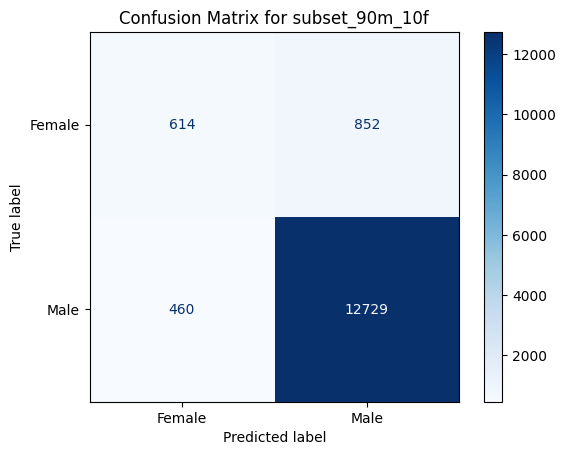

Classification Report for subset_90m_10f:
              precision    recall  f1-score   support

      Female       0.57      0.42      0.48      1466
        Male       0.94      0.97      0.95     13189

    accuracy                           0.91     14655
   macro avg       0.75      0.69      0.72     14655
weighted avg       0.90      0.91      0.90     14655



In [50]:
# Calling the functions for each subset

# For subset_90m_10f
X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f")

### Calculating bias level of subset 

In [51]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3839


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.3839


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_50 (MaxPooli

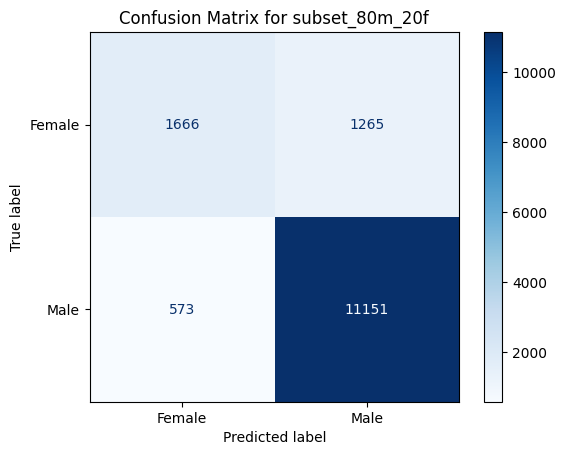

Classification Report for subset_80m_20f:
              precision    recall  f1-score   support

      Female       0.74      0.57      0.64      2931
        Male       0.90      0.95      0.92     11724

    accuracy                           0.87     14655
   macro avg       0.82      0.76      0.78     14655
weighted avg       0.87      0.87      0.87     14655



In [56]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f")

### Calculating bias level of subset 

In [57]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.5195


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.5195


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin 

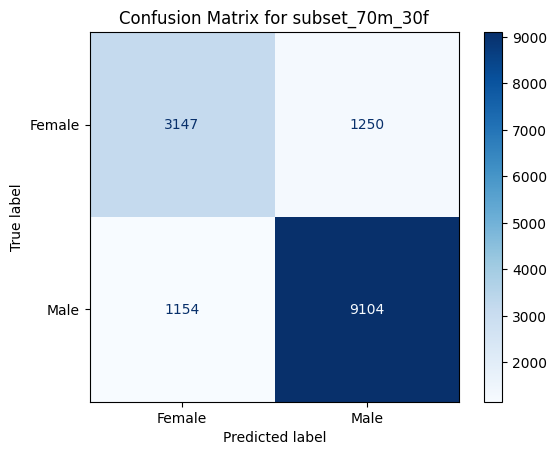

Classification Report for subset_70m_30f:
              precision    recall  f1-score   support

      Female       0.73      0.72      0.72      4397
        Male       0.88      0.89      0.88     10258

    accuracy                           0.84     14655
   macro avg       0.81      0.80      0.80     14655
weighted avg       0.83      0.84      0.84     14655



In [23]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f")

### Calculating bias level of subset 

In [24]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.6032


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.6032


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli 

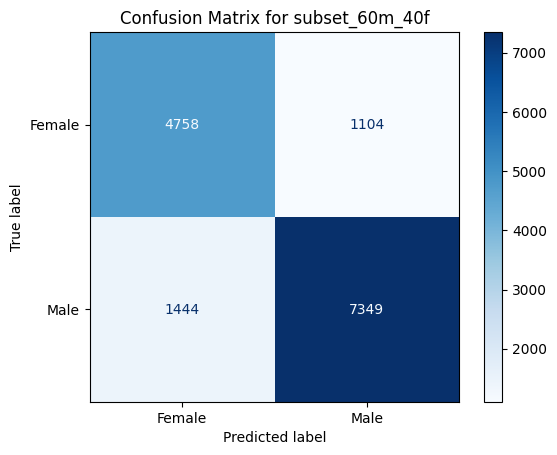

Classification Report for subset_60m_40f:
              precision    recall  f1-score   support

      Female       0.77      0.81      0.79      5862
        Male       0.87      0.84      0.85      8793

    accuracy                           0.83     14655
   macro avg       0.82      0.82      0.82     14655
weighted avg       0.83      0.83      0.83     14655



In [25]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f")

### Calculating bias level of subset

In [26]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.6474


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.6474


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli 

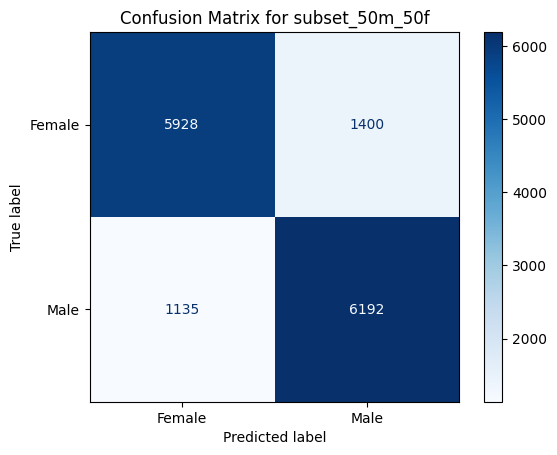

Classification Report for subset_50m_50f:
              precision    recall  f1-score   support

      Female       0.84      0.81      0.82      7328
        Male       0.82      0.85      0.83      7327

    accuracy                           0.83     14655
   macro avg       0.83      0.83      0.83     14655
weighted avg       0.83      0.83      0.83     14655



In [27]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f")

### Calculating bias level of subset 

In [28]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.6540


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.6540


## Using 30% of the data

In [30]:
# Create and save biased subsets
ratios = [0.9, 0.8, 0.7, 0.6, 0.5]
total_samples = int(0.3 * len(data))  # Use 30% of the data

def create_biased_subset(data, male_ratio, subset_dir, total_samples):
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    
    male_data = data[data['gender'] == 1]
    female_data = data[data['gender'] == 0]
    
    num_male = int(male_ratio * total_samples)
    num_female = total_samples - num_male
    
    num_male = min(num_male, len(male_data))
    num_female = min(num_female, len(female_data))
    
    biased_subset = pd.concat([male_data.sample(num_male, random_state=0), female_data.sample(num_female, random_state=0)])
    
    male_folder = os.path.join(subset_dir, "male")
    female_folder = os.path.join(subset_dir, "female")
    
    if not os.path.exists(male_folder):
        os.makedirs(male_folder)
    if not os.path.exists(female_folder):
        os.makedirs(female_folder)
    
    for index, row in biased_subset.iterrows():
        src_dir = train_dir if row['file'].startswith('train') else val_dir
        img_name = row['file'].split('/')[1]
        gender_folder = 'male' if row['gender'] == 1 else 'female'
        src_path = os.path.join(src_dir, gender_folder, img_name)
        
        if row['gender'] == 1:
            dest_path = os.path.join(male_folder, img_name)
        else:
            dest_path = os.path.join(female_folder, img_name)
        
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
    
    biased_subset.to_csv(os.path.join(subset_dir, 'subset.csv'), index=False)
    return biased_subset

In [31]:
# Create subsets
for ratio in ratios:
    subset_dir = f"subset_{int(ratio*100)}m_{int((1-ratio)*100)}f_30"
    create_biased_subset(data, ratio, subset_dir, total_samples)

In [32]:
# Function to load images and preprocess
def load_images(image_paths, genders, base_dir):
    images = []
    not_found_count = 0
    for path, gender in zip(image_paths, genders):
        img_name = path.split('/')[1]
        gender_dir = 'male' if gender == 1 else 'female'
        img_path = os.path.join(base_dir, gender_dir, img_name)
        
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=(128, 128))
            img = img_to_array(img)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
        else:
            print(f"Image not found: {img_path}")
            not_found_count += 1
    print(f"Total images not found: {not_found_count}")
    return np.array(images)

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_44 (MaxPooli

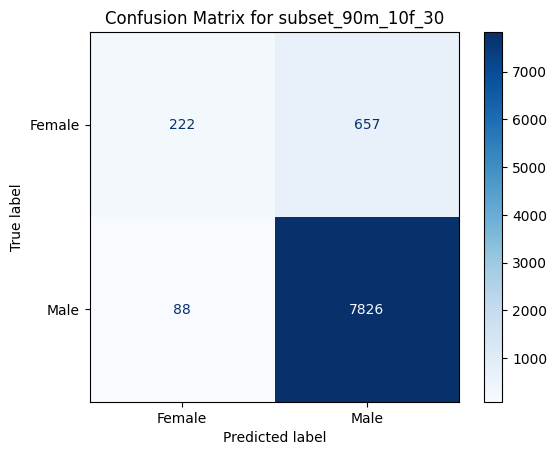

Classification Report for subset_90m_10f_30:
              precision    recall  f1-score   support

      Female       0.72      0.25      0.37       879
        Male       0.92      0.99      0.95      7914

    accuracy                           0.92      8793
   macro avg       0.82      0.62      0.66      8793
weighted avg       0.90      0.92      0.90      8793



In [52]:
# Calling the functions for each subset

# For subset_90m_10f_30

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f_30")

### Calculating bias level of subset

In [53]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2414


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.2414


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_53 (MaxPooli

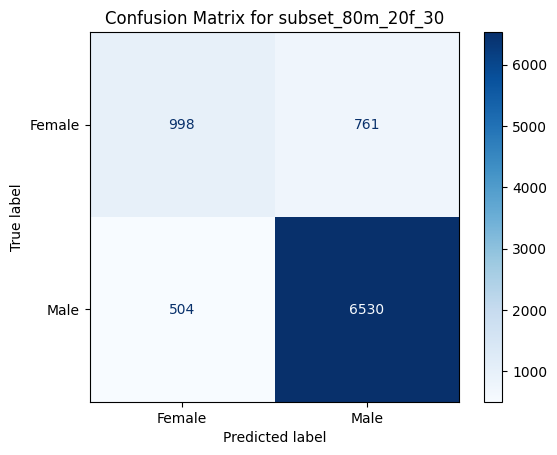

Classification Report for subset_80m_20f_30:
              precision    recall  f1-score   support

      Female       0.66      0.57      0.61      1759
        Male       0.90      0.93      0.91      7034

    accuracy                           0.86      8793
   macro avg       0.78      0.75      0.76      8793
weighted avg       0.85      0.86      0.85      8793



In [58]:
# For subset_80m_20f_30

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f_30")

### Calculating bias level of subset

In [59]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.4957


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.4957


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPooli 

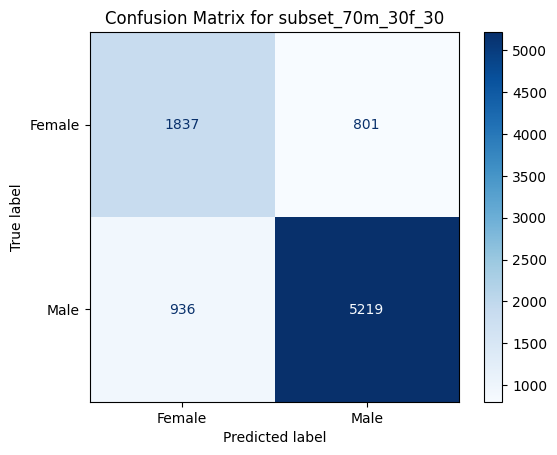

Classification Report for subset_70m_30f_30:
              precision    recall  f1-score   support

      Female       0.66      0.70      0.68      2638
        Male       0.87      0.85      0.86      6155

    accuracy                           0.80      8793
   macro avg       0.76      0.77      0.77      8793
weighted avg       0.81      0.80      0.80      8793



In [40]:
# For subset_70m_30f_30

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f_30")

### Calculating bias level of subset

In [41]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.5443


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.5443


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPooli 

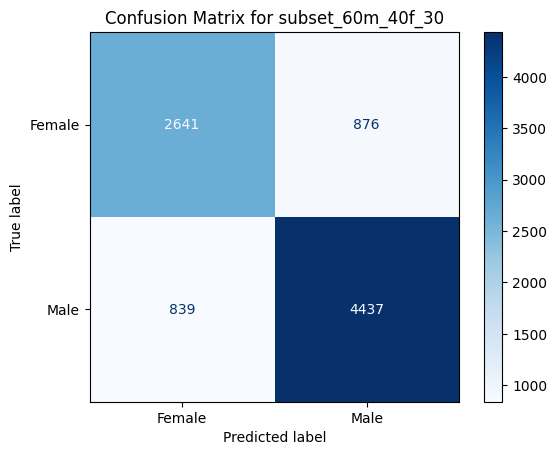

Classification Report for subset_60m_40f_30:
              precision    recall  f1-score   support

      Female       0.76      0.75      0.75      3517
        Male       0.84      0.84      0.84      5276

    accuracy                           0.80      8793
   macro avg       0.80      0.80      0.80      8793
weighted avg       0.80      0.80      0.80      8793



In [42]:
# For subset_60m_40f_30

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f_30")

### Calculating bias level of subset

In [43]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.5919


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.5919


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPooli 

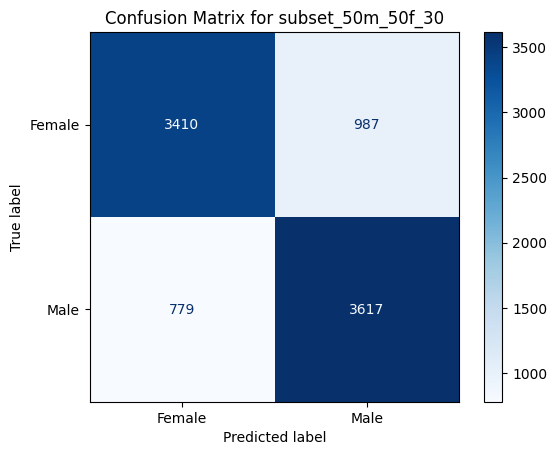

Classification Report for subset_50m_50f_30:
              precision    recall  f1-score   support

      Female       0.81      0.78      0.79      4397
        Male       0.79      0.82      0.80      4396

    accuracy                           0.80      8793
   macro avg       0.80      0.80      0.80      8793
weighted avg       0.80      0.80      0.80      8793



In [44]:
# For subset_50m_50f_30

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f_30")

### Calculating bias level of subset

In [45]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.5983


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.5983


## Using 10% of the data

In [47]:
# Create and save biased subsets
ratios = [0.9, 0.8, 0.7, 0.6, 0.5]
total_samples = int(0.1 * len(data))  # Use 10% of the data

def create_biased_subset(data, male_ratio, subset_dir, total_samples):
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    
    male_data = data[data['gender'] == 1]
    female_data = data[data['gender'] == 0]
    
    num_male = int(male_ratio * total_samples)
    num_female = total_samples - num_male
    
    num_male = min(num_male, len(male_data))
    num_female = min(num_female, len(female_data))
    
    biased_subset = pd.concat([male_data.sample(num_male, random_state=0), female_data.sample(num_female, random_state=0)])
    
    male_folder = os.path.join(subset_dir, "male")
    female_folder = os.path.join(subset_dir, "female")
    
    if not os.path.exists(male_folder):
        os.makedirs(male_folder)
    if not os.path.exists(female_folder):
        os.makedirs(female_folder)
    
    for index, row in biased_subset.iterrows():
        src_dir = train_dir if row['file'].startswith('train') else val_dir
        img_name = row['file'].split('/')[1]
        gender_folder = 'male' if row['gender'] == 1 else 'female'
        src_path = os.path.join(src_dir, gender_folder, img_name)
        
        if row['gender'] == 1:
            dest_path = os.path.join(male_folder, img_name)
        else:
            dest_path = os.path.join(female_folder, img_name)
        
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
    
    biased_subset.to_csv(os.path.join(subset_dir, 'subset.csv'), index=False)
    return biased_subset

In [48]:
# Create subsets
for ratio in ratios:
    subset_dir = f"subset_{int(ratio*100)}m_{int((1-ratio)*100)}f_10"
    create_biased_subset(data, ratio, subset_dir, total_samples)

In [49]:
# Function to load images and preprocess
def load_images(image_paths, genders, base_dir):
    images = []
    not_found_count = 0
    for path, gender in zip(image_paths, genders):
        img_name = path.split('/')[1]
        gender_dir = 'male' if gender == 1 else 'female'
        img_path = os.path.join(base_dir, gender_dir, img_name)
        
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=(128, 128))
            img = img_to_array(img)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
        else:
            print(f"Image not found: {img_path}")
            not_found_count += 1
    print(f"Total images not found: {not_found_count}")
    return np.array(images)

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_47 (MaxPooli

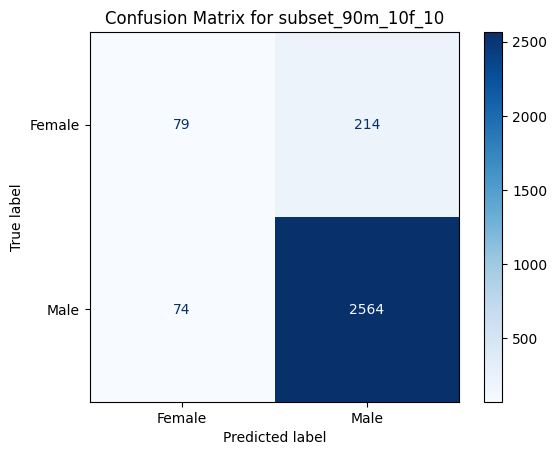

Classification Report for subset_90m_10f_10:
              precision    recall  f1-score   support

      Female       0.52      0.27      0.35       293
        Male       0.92      0.97      0.95      2638

    accuracy                           0.90      2931
   macro avg       0.72      0.62      0.65      2931
weighted avg       0.88      0.90      0.89      2931



In [54]:
# Calling the functions for each subset

# For subset_90m_10f_10
X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f_10")

### Calculating bias levels

In [55]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2416


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.2416


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_56 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_56 (MaxPooli

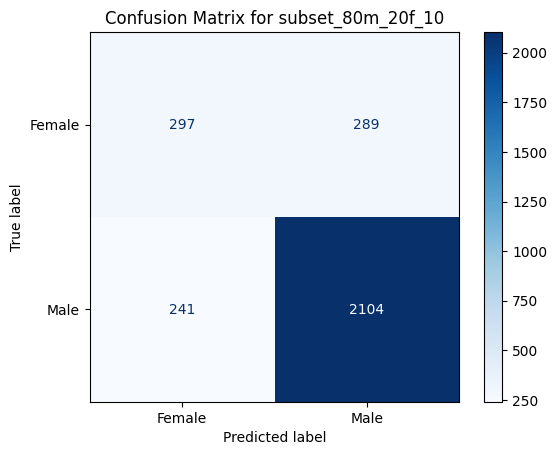

Classification Report for subset_80m_20f_10:
              precision    recall  f1-score   support

      Female       0.55      0.51      0.53       586
        Male       0.88      0.90      0.89      2345

    accuracy                           0.82      2931
   macro avg       0.72      0.70      0.71      2931
weighted avg       0.81      0.82      0.82      2931



In [60]:
# For subset_80m_20f_10

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f_10")

### Calculating bias levels

In [61]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.4041


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.4041


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_38 (MaxPooli

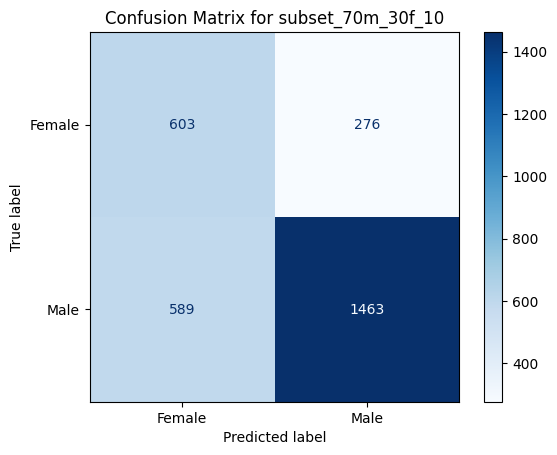

Classification Report for subset_70m_30f_10:
              precision    recall  f1-score   support

      Female       0.51      0.69      0.58       879
        Male       0.84      0.71      0.77      2052

    accuracy                           0.70      2931
   macro avg       0.67      0.70      0.68      2931
weighted avg       0.74      0.70      0.71      2931



In [54]:
# For subset_70m_30f_10

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f_10")

### Calculating bias levels

In [55]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3990


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.3990


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_41 (MaxPooli

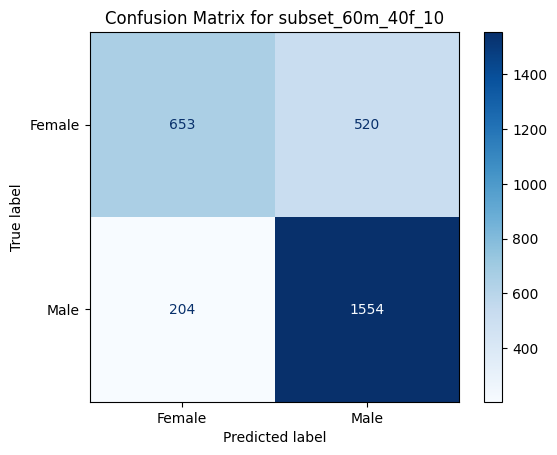

Classification Report for subset_60m_40f_10:
              precision    recall  f1-score   support

      Female       0.76      0.56      0.64      1173
        Male       0.75      0.88      0.81      1758

    accuracy                           0.75      2931
   macro avg       0.76      0.72      0.73      2931
weighted avg       0.75      0.75      0.74      2931



In [56]:
# For subset_60m_40f_10

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f_10")

### Calculating bias levels

In [57]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.4407


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.4407


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_44 (MaxPooli

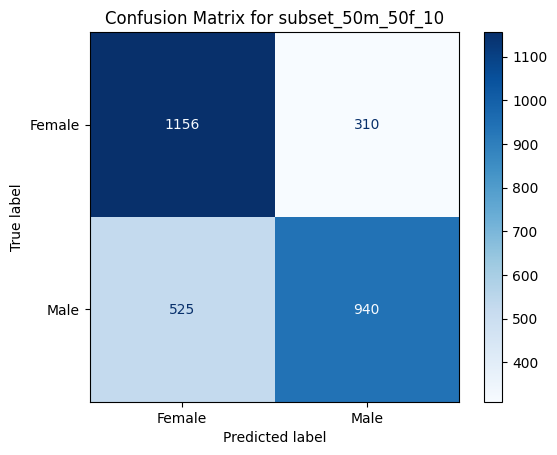

Classification Report for subset_50m_50f_10:
              precision    recall  f1-score   support

      Female       0.69      0.79      0.73      1466
        Male       0.75      0.64      0.69      1465

    accuracy                           0.72      2931
   macro avg       0.72      0.72      0.71      2931
weighted avg       0.72      0.72      0.71      2931



In [58]:
# For subset_50m_50f_10

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f_10")

### Calculating bias levels

In [59]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.4302


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.4302


## SWITCHING PRIORITY GROUP TO FEMALE

## Using 50% of the dataset

In [8]:
# Create and save biased subsets
ratios = [0.9, 0.8, 0.7, 0.6, 0.5]
total_samples = int(0.5 * len(data))  # Use 50% of the data

def create_biased_subset(data, female_ratio, subset_dir, total_samples):
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    
    male_data = data[data['gender'] == 1]
    female_data = data[data['gender'] == 0]
    
    num_female = int(female_ratio * total_samples)
    num_male = total_samples - num_female
    
    num_female = min(num_female, len(female_data))
    num_male = min(num_male, len(male_data))
    
    biased_subset = pd.concat([female_data.sample(num_female, random_state=0), male_data.sample(num_male, random_state=0)])
    
    female_folder = os.path.join(subset_dir, "female")
    male_folder = os.path.join(subset_dir, "male")
    
    if not os.path.exists(female_folder):
        os.makedirs(female_folder)
    if not os.path.exists(male_folder):
        os.makedirs(male_folder)
    
    for index, row in biased_subset.iterrows():
        src_dir = train_dir if row['file'].startswith('train') else val_dir
        img_name = row['file'].split('/')[1]
        gender_folder = 'male' if row['gender'] == 1 else 'female'
        src_path = os.path.join(src_dir, gender_folder, img_name)
        
        if row['gender'] == 0:
            dest_path = os.path.join(female_folder, img_name)
        else:
            dest_path = os.path.join(male_folder, img_name)
        
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
    
    biased_subset.to_csv(os.path.join(subset_dir, 'subset.csv'), index=False)
    return biased_subset

In [61]:
# Create subsets
for ratio in ratios:
    subset_dir = f"subset_{int(ratio*100)}f_{int((1-ratio)*100)}m"
    create_biased_subset(data, ratio, subset_dir, total_samples)

In [10]:
# Function to load images and preprocess
def load_images(image_paths, genders, base_dir):
    images = []
    not_found_count = 0
    for path, gender in zip(image_paths, genders):
        img_name = path.split('/')[1]
        gender_dir = 'male' if gender == 1 else 'female'
        img_path = os.path.join(base_dir, gender_dir, img_name)
        
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=(128, 128))
            img = img_to_array(img)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
        else:
            print(f"Image not found: {img_path}")
            not_found_count += 1
    print(f"Total images not found: {not_found_count}")
    return np.array(images)

In [9]:
# Function to calculate bias
def calculate_bias(X_test, y_test, y_pred):
    # Convert to aif360 BinaryLabelDataset for bias checking
    class ImageGenderDataset(BinaryLabelDataset):
        def __init__(self, df, label_names=['gender'], protected_attribute_names=['gender']):
            super().__init__(df=df, label_names=label_names, protected_attribute_names=protected_attribute_names)
    
    # Create aif360 datasets
    test_numerical_df = pd.DataFrame({'gender': y_test})
    dataset_orig_test = ImageGenderDataset(df=test_numerical_df)
    
    pred_numerical_df = pd.DataFrame({'gender': y_pred})
    dataset_pred = ImageGenderDataset(df=pred_numerical_df)
    
    # Ensure that dataset_pred has the same structure and metadata as dataset_orig_test
    dataset_pred.feature_names = dataset_orig_test.feature_names
    dataset_pred.protected_attribute_names = dataset_orig_test.protected_attribute_names
    dataset_pred.instance_weights = np.copy(dataset_orig_test.instance_weights)
    dataset_pred.protected_attributes = np.copy(dataset_orig_test.protected_attributes)
    dataset_pred.metadata = dataset_orig_test.metadata.copy()
    
    # Metric for original test dataset
    metric_orig_test = BinaryLabelDatasetMetric(
        dataset_orig_test,
        unprivileged_groups=[{'gender': 1}],
        privileged_groups=[{'gender': 0}]
    )
    
    difference = metric_orig_test.mean_difference()
    formatted_difference = f"{difference:.4f}"
    print(f"Difference in mean outcomes between privileged and unprivileged groups (original test dataset): {formatted_difference}")
    
    # Metric for model predictions
    metric_pred = ClassificationMetric(
        dataset_orig_test,
        dataset_pred,
        unprivileged_groups=[{'gender': 1}],
        privileged_groups=[{'gender': 0}]
    )
    
    difference = metric_pred.mean_difference()
    formatted_difference = f"{difference:.4f}"
    print(f"Difference in mean outcomes between privileged and unprivileged groups (model predictions): {formatted_difference}")
    
    # Display metrics
    def display_metrics(metric, message):
        mean_diff = metric.mean_difference()
        formatted_mean_diff = f"{mean_diff:.4f}"  # Format to 4 decimal places
        display(Markdown(f"#### {message}"))
        print(f"Difference in mean outcomes between privileged and unprivileged groups: {formatted_mean_diff}")
    
    # Display metrics for original and model predictions
    display_metrics(metric_orig_test, "Original test dataset")
    display_metrics(metric_pred, "Model predictions")

In [11]:
# Function to train and evaluate the model
def train_and_evaluate(subset_dir):
    subset_csv = os.path.join(subset_dir, 'subset.csv')
    biased_subset = pd.read_csv(subset_csv)
    
    X = load_images(biased_subset['file'], biased_subset['gender'], subset_dir)
    y = biased_subset['gender'].values
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    
    # Define and compile the CNN model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the CNN model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
    
    # Evaluate the model
    y_pred = model.predict(X_test).ravel()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    
    # Accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy for {subset_dir}: {accuracy:.4f}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {subset_dir}')
    plt.show()
    
    # Classification Report
    report = classification_report(y_test, y_pred, target_names=["Female", "Male"])
    print(f'Classification Report for {subset_dir}:\n{report}')
    
    # Return the necessary data for bias calculation
    return X_test, y_test, y_pred

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_50 (MaxPooli

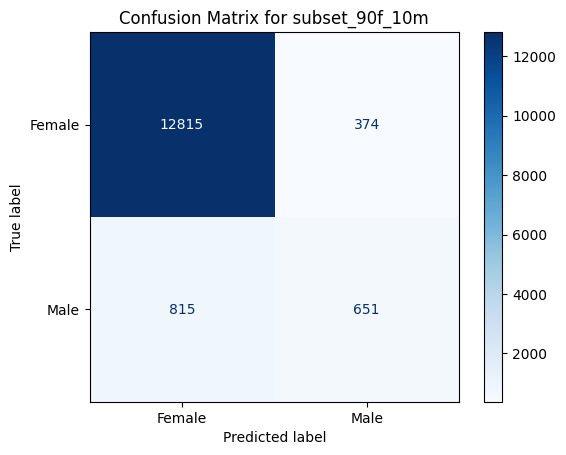

Classification Report for subset_90f_10m:
              precision    recall  f1-score   support

      Female       0.94      0.97      0.96     13189
        Male       0.64      0.44      0.52      1466

    accuracy                           0.92     14655
   macro avg       0.79      0.71      0.74     14655
weighted avg       0.91      0.92      0.91     14655



In [66]:
# Calling the functions for each subset

# For subset_90f_10m
X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m")

### Calculating bias levels

In [67]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.4157


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.4157


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_53 (MaxPooli

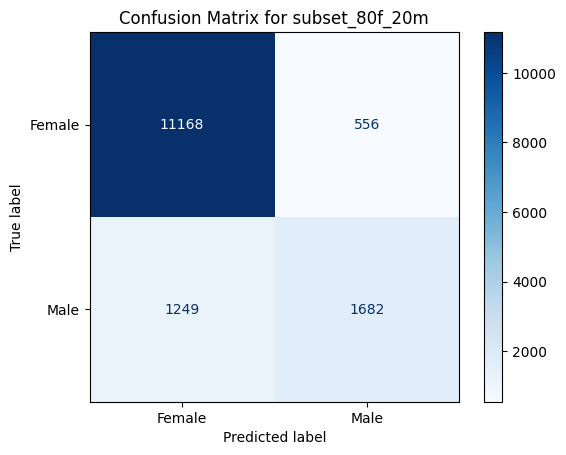

Classification Report for subset_80f_20m:
              precision    recall  f1-score   support

      Female       0.90      0.95      0.93     11724
        Male       0.75      0.57      0.65      2931

    accuracy                           0.88     14655
   macro avg       0.83      0.76      0.79     14655
weighted avg       0.87      0.88      0.87     14655



In [68]:
# For subset_80f_20m

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m")

### Calculating bias levels

In [69]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.5264


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.5264


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (

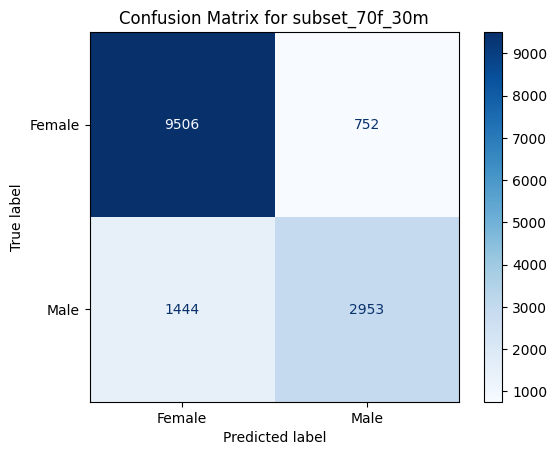

Classification Report for subset_70f_30m:
              precision    recall  f1-score   support

      Female       0.87      0.93      0.90     10258
        Male       0.80      0.67      0.73      4397

    accuracy                           0.85     14655
   macro avg       0.83      0.80      0.81     14655
weighted avg       0.85      0.85      0.85     14655



In [12]:
# For subset_70f_30m

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m")

### Calculating bias levels

In [13]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.5983


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.5983


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin 

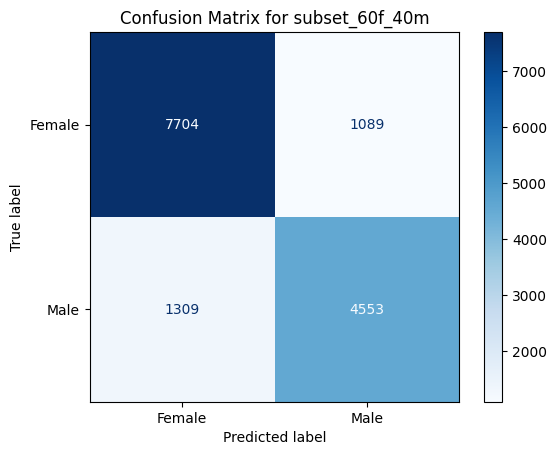

Classification Report for subset_60f_40m:
              precision    recall  f1-score   support

      Female       0.85      0.88      0.87      8793
        Male       0.81      0.78      0.79      5862

    accuracy                           0.84     14655
   macro avg       0.83      0.83      0.83     14655
weighted avg       0.84      0.84      0.84     14655



In [14]:
# For subset_60f_40m

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m")

### Calculating bias levels

In [15]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.6528


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.6528


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin 

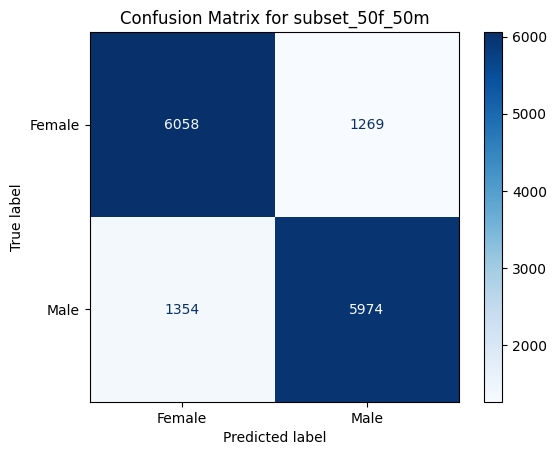

Classification Report for subset_50f_50m:
              precision    recall  f1-score   support

      Female       0.82      0.83      0.82      7327
        Male       0.82      0.82      0.82      7328

    accuracy                           0.82     14655
   macro avg       0.82      0.82      0.82     14655
weighted avg       0.82      0.82      0.82     14655



In [16]:
# For subset_50f_50m

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m")

### Calculating bias levels

In [17]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.6420


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.6420


## Using 30% of the dataset

In [18]:
# Create and save biased subsets
ratios = [0.9, 0.8, 0.7, 0.6, 0.5]
total_samples = int(0.3 * len(data))  # Use 30% of the data

def create_biased_subset(data, female_ratio, subset_dir, total_samples):
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    
    male_data = data[data['gender'] == 1]
    female_data = data[data['gender'] == 0]
    
    num_female = int(female_ratio * total_samples)
    num_male = total_samples - num_female
    
    num_female = min(num_female, len(female_data))
    num_male = min(num_male, len(male_data))
    
    biased_subset = pd.concat([female_data.sample(num_female, random_state=0), male_data.sample(num_male, random_state=0)])
    
    female_folder = os.path.join(subset_dir, "female")
    male_folder = os.path.join(subset_dir, "male")
    
    if not os.path.exists(female_folder):
        os.makedirs(female_folder)
    if not os.path.exists(male_folder):
        os.makedirs(male_folder)
    
    for index, row in biased_subset.iterrows():
        src_dir = train_dir if row['file'].startswith('train') else val_dir
        img_name = row['file'].split('/')[1]
        gender_folder = 'male' if row['gender'] == 1 else 'female'
        src_path = os.path.join(src_dir, gender_folder, img_name)
        
        if row['gender'] == 0:
            dest_path = os.path.join(female_folder, img_name)
        else:
            dest_path = os.path.join(male_folder, img_name)
        
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
    
    biased_subset.to_csv(os.path.join(subset_dir, 'subset.csv'), index=False)
    return biased_subset

In [20]:
# Create subsets
for ratio in ratios:
    subset_dir = f"subset_{int(ratio*100)}f_{int((1-ratio)*100)}m_30"
    create_biased_subset(data, ratio, subset_dir, total_samples)

In [21]:
# Function to load images and preprocess
def load_images(image_paths, genders, base_dir):
    images = []
    not_found_count = 0
    for path, gender in zip(image_paths, genders):
        img_name = path.split('/')[1]
        gender_dir = 'male' if gender == 1 else 'female'
        img_path = os.path.join(base_dir, gender_dir, img_name)
        
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=(128, 128))
            img = img_to_array(img)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
        else:
            print(f"Image not found: {img_path}")
            not_found_count += 1
    print(f"Total images not found: {not_found_count}")
    return np.array(images)

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli 

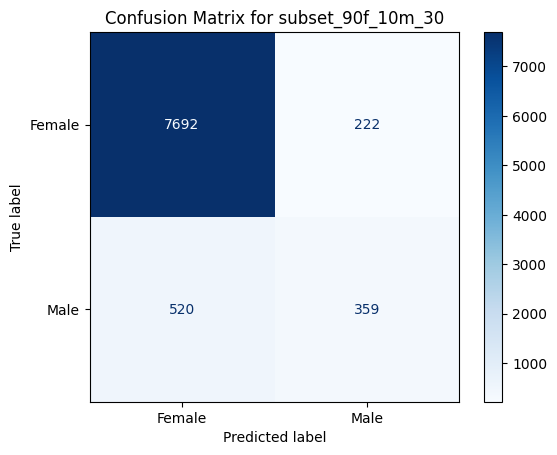

Classification Report for subset_90f_10m_30:
              precision    recall  f1-score   support

      Female       0.94      0.97      0.95      7914
        Male       0.62      0.41      0.49       879

    accuracy                           0.92      8793
   macro avg       0.78      0.69      0.72      8793
weighted avg       0.90      0.92      0.91      8793



In [23]:
# Calling the functions for each subset

# For subset_90f_10m_30
X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m_30")

In [24]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.3804


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.3804


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli 

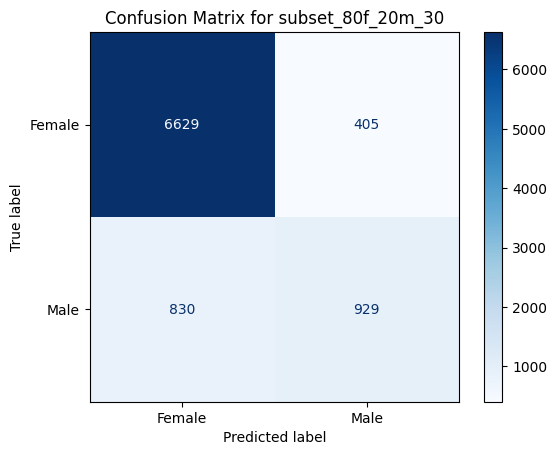

Classification Report for subset_80f_20m_30:
              precision    recall  f1-score   support

      Female       0.89      0.94      0.91      7034
        Male       0.70      0.53      0.60      1759

    accuracy                           0.86      8793
   macro avg       0.79      0.74      0.76      8793
weighted avg       0.85      0.86      0.85      8793



In [25]:
# For subset_80f_20m_30

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m_30")

### Calculating bias level

In [26]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.4706


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.4706


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli 

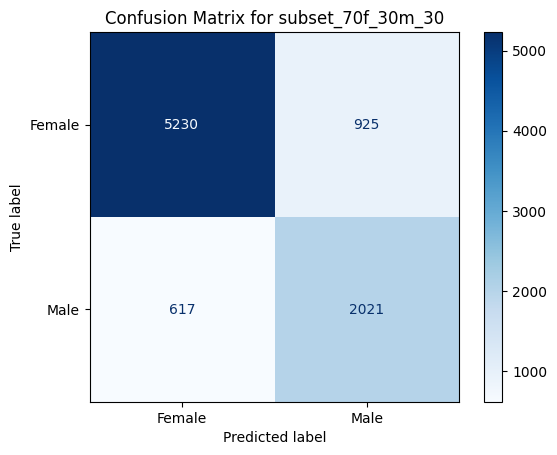

Classification Report for subset_70f_30m_30:
              precision    recall  f1-score   support

      Female       0.89      0.85      0.87      6155
        Male       0.69      0.77      0.72      2638

    accuracy                           0.82      8793
   macro avg       0.79      0.81      0.80      8793
weighted avg       0.83      0.82      0.83      8793



In [27]:
# For subset_70f_30m_30

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m_30")

### Calculating bias level

In [28]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.6158


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.6158


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPooli 

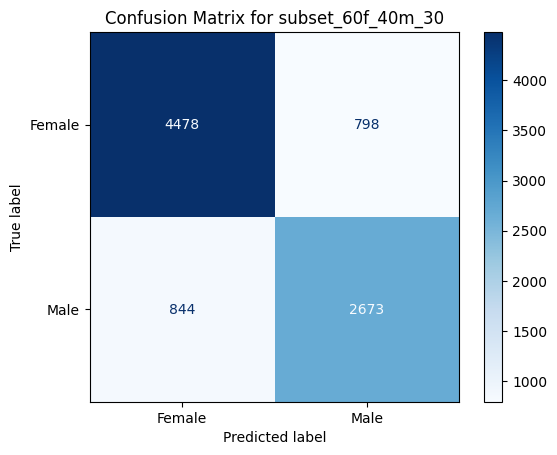

Classification Report for subset_60f_40m_30:
              precision    recall  f1-score   support

      Female       0.84      0.85      0.85      5276
        Male       0.77      0.76      0.77      3517

    accuracy                           0.81      8793
   macro avg       0.81      0.80      0.81      8793
weighted avg       0.81      0.81      0.81      8793



In [29]:
# For subset_60f_40m_30

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m_30")

### Calculating bias level

In [30]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.6088


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.6088


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPooli 

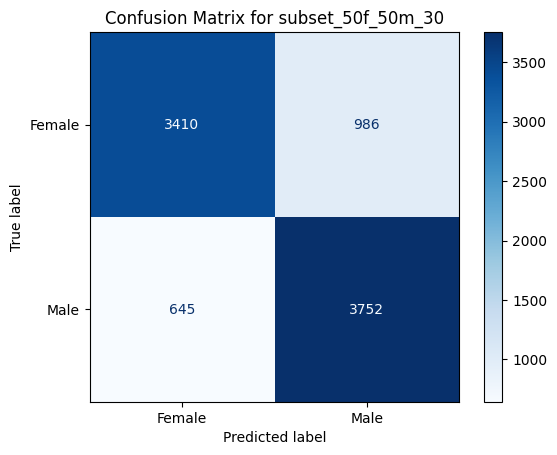

Classification Report for subset_50f_50m_30:
              precision    recall  f1-score   support

      Female       0.84      0.78      0.81      4396
        Male       0.79      0.85      0.82      4397

    accuracy                           0.81      8793
   macro avg       0.82      0.81      0.81      8793
weighted avg       0.82      0.81      0.81      8793



In [31]:
# For subset_50f_50m_30

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m_30")

### Calculating bias level

In [32]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.6290


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.6290


## Using 10% of the dataset

In [33]:
# Create and save biased subsets
ratios = [0.9, 0.8, 0.7, 0.6, 0.5]
total_samples = int(0.1 * len(data))  # Use 10% of the data

def create_biased_subset(data, female_ratio, subset_dir, total_samples):
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    
    male_data = data[data['gender'] == 1]
    female_data = data[data['gender'] == 0]
    
    num_female = int(female_ratio * total_samples)
    num_male = total_samples - num_female
    
    num_female = min(num_female, len(female_data))
    num_male = min(num_male, len(male_data))
    
    biased_subset = pd.concat([female_data.sample(num_female, random_state=0), male_data.sample(num_male, random_state=0)])
    
    female_folder = os.path.join(subset_dir, "female")
    male_folder = os.path.join(subset_dir, "male")
    
    if not os.path.exists(female_folder):
        os.makedirs(female_folder)
    if not os.path.exists(male_folder):
        os.makedirs(male_folder)
    
    for index, row in biased_subset.iterrows():
        src_dir = train_dir if row['file'].startswith('train') else val_dir
        img_name = row['file'].split('/')[1]
        gender_folder = 'male' if row['gender'] == 1 else 'female'
        src_path = os.path.join(src_dir, gender_folder, img_name)
        
        if row['gender'] == 0:
            dest_path = os.path.join(female_folder, img_name)
        else:
            dest_path = os.path.join(male_folder, img_name)
        
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
    
    biased_subset.to_csv(os.path.join(subset_dir, 'subset.csv'), index=False)
    return biased_subset

In [34]:
# Create subsets
for ratio in ratios:
    subset_dir = f"subset_{int(ratio*100)}f_{int((1-ratio)*100)}m_10"
    create_biased_subset(data, ratio, subset_dir, total_samples)

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPooli 

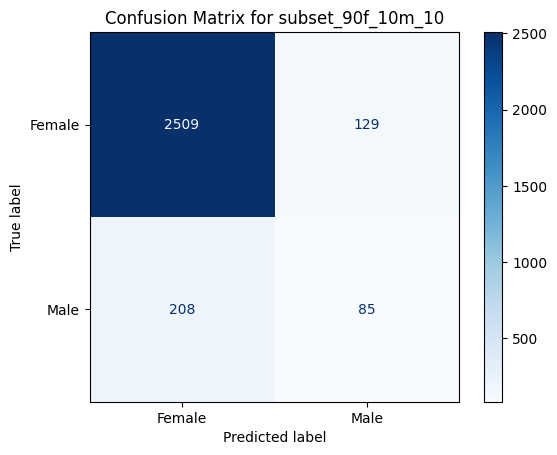

Classification Report for subset_90f_10m_10:
              precision    recall  f1-score   support

      Female       0.92      0.95      0.94      2638
        Male       0.40      0.29      0.34       293

    accuracy                           0.89      2931
   macro avg       0.66      0.62      0.64      2931
weighted avg       0.87      0.89      0.88      2931



In [35]:
# Calling the functions for each subset

# For subset_90f_10m_10
X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m_10")

### Calculating bias levels

In [36]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.2412


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.2412


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPooli 

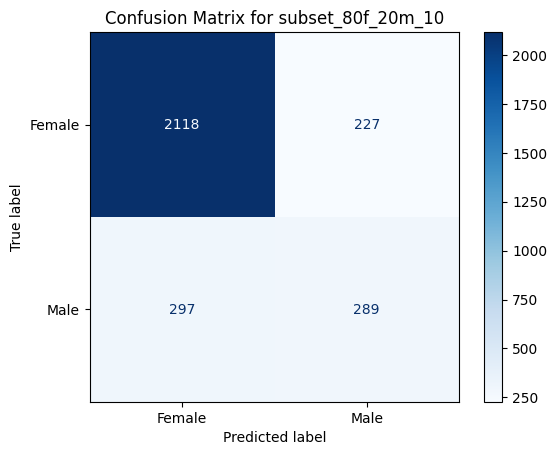

Classification Report for subset_80f_20m_10:
              precision    recall  f1-score   support

      Female       0.88      0.90      0.89      2345
        Male       0.56      0.49      0.52       586

    accuracy                           0.82      2931
   macro avg       0.72      0.70      0.71      2931
weighted avg       0.81      0.82      0.82      2931



In [37]:
# For subset_80f_20m_10

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m_10")

### Calculating bias levels

In [38]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.3964


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.3964


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_32 (MaxPooli

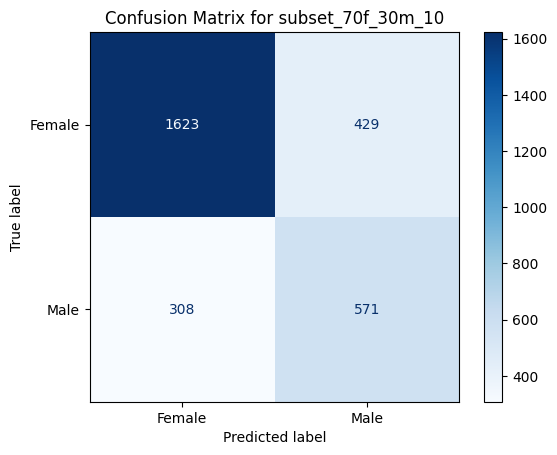

Classification Report for subset_70f_30m_10:
              precision    recall  f1-score   support

      Female       0.84      0.79      0.81      2052
        Male       0.57      0.65      0.61       879

    accuracy                           0.75      2931
   macro avg       0.71      0.72      0.71      2931
weighted avg       0.76      0.75      0.75      2931



In [39]:
# For subset_70f_30m_10

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m_10")

### Calculating bias levels

In [40]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.4405


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.4405


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_35 (MaxPooli

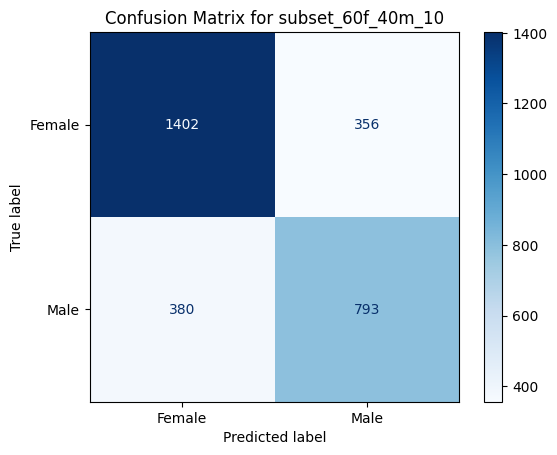

Classification Report for subset_60f_40m_10:
              precision    recall  f1-score   support

      Female       0.79      0.80      0.79      1758
        Male       0.69      0.68      0.68      1173

    accuracy                           0.75      2931
   macro avg       0.74      0.74      0.74      2931
weighted avg       0.75      0.75      0.75      2931



In [41]:
# For subset_60f_40m_10

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m_10")

### Calculating bias levels

In [42]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.4735


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.4735


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_38 (MaxPooli

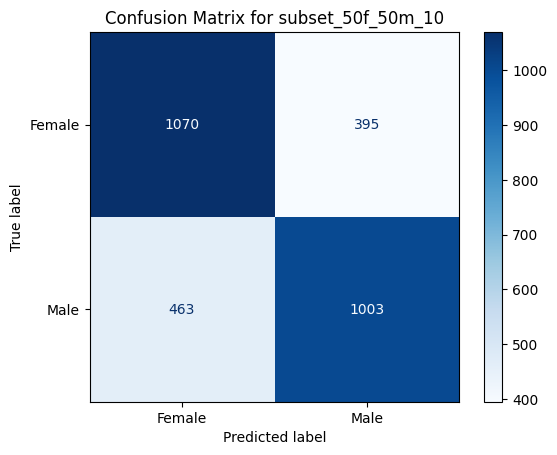

Classification Report for subset_50f_50m_10:
              precision    recall  f1-score   support

      Female       0.70      0.73      0.71      1465
        Male       0.72      0.68      0.70      1466

    accuracy                           0.71      2931
   macro avg       0.71      0.71      0.71      2931
weighted avg       0.71      0.71      0.71      2931



In [43]:
# For subset_50f_50m_10

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m_10")

### Calculating bias levels

In [44]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): 1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): 0.4146


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: 1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: 0.4146


## APPLYING HYPERPARAMETER TUNING

In [13]:
# Function to load images and preprocess
def load_images(image_paths, genders, base_dir):
    images = []
    not_found_count = 0
    for path, gender in zip(image_paths, genders):
        img_name = path.split('/')[1]
        gender_dir = 'male' if gender == 1 else 'female'
        img_path = os.path.join(base_dir, gender_dir, img_name)
        
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=(64, 64))
            img = img_to_array(img)
            img = img / 255.0  
            images.append(img)
        else:
            print(f"Image not found: {img_path}")
            not_found_count += 1
    print(f"Total images not found: {not_found_count}")
    return np.array(images)

In [14]:
# Function to train and evaluate the model applying changes to the batch size, learning rate and image size
def train_and_evaluate_cnn(subset_dir):
    subset_csv = os.path.join(subset_dir, 'subset.csv')
    biased_subset = pd.read_csv(subset_csv)
    
    X = load_images(biased_subset['file'], biased_subset['gender'], subset_dir)
    y = biased_subset['gender'].values
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    
    # Define and compile the CNN model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.summary()
    
    # Compile the model with Adam optimizer and a learning rate of 0.001
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the CNN model
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)
    
    # Evaluate the model
    y_pred = model.predict(X_test).ravel()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    
    # Accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy for {subset_dir}: {accuracy:.4f}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {subset_dir}')
    plt.show()
    
    # Classification Report
    report = classification_report(y_test, y_pred, target_names=["Female", "Male"])
    print(f'Classification Report for {subset_dir}:\n{report}')
    
    # Return the necessary data for bias calculation
    return X_test, y_test, y_pred

### Applying the tuning to the 50:50 male to female ratio using 10% of the dataset

Total images not found: 0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (

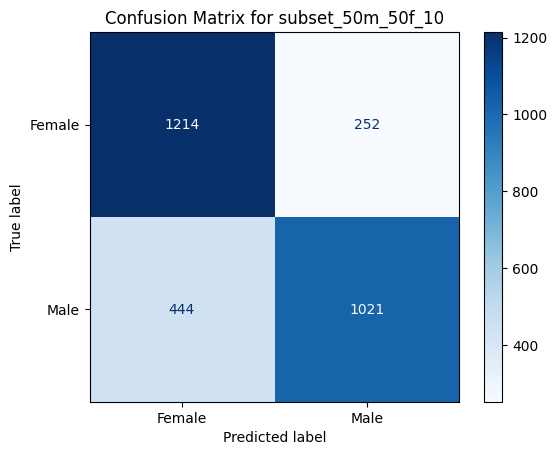

Classification Report for subset_50m_50f_10:
              precision    recall  f1-score   support

      Female       0.73      0.83      0.78      1466
        Male       0.80      0.70      0.75      1465

    accuracy                           0.76      2931
   macro avg       0.77      0.76      0.76      2931
weighted avg       0.77      0.76      0.76      2931



In [12]:
# Calling the train_and_evaluate function

X_test_50, y_test_50, y_pred_50 = train_and_evaluate_cnn("subset_50m_50f_10")

In [15]:
# Calling the calculate bias function

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.5250


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.5250


### SWITCHING PRIORITIES

### Applying the tuning to the 50:50 female to male ratio using 10% of the dataset

Total images not found: 0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin 

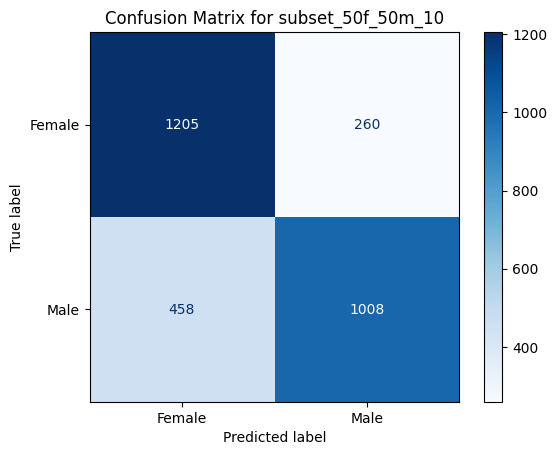

Classification Report for subset_50f_50m_10:
              precision    recall  f1-score   support

      Female       0.72      0.82      0.77      1465
        Male       0.79      0.69      0.74      1466

    accuracy                           0.76      2931
   macro avg       0.76      0.76      0.75      2931
weighted avg       0.76      0.76      0.75      2931



In [16]:
# Calling the train_and_evaluate function

X_test_50, y_test_50, y_pred_50 = train_and_evaluate_cnn("subset_50f_50m_10")

In [17]:
# Calling the calculate bias function

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (original test dataset): -1.0000
Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.5101


#### Original test dataset

Difference in mean outcomes between privileged and unprivileged groups: -1.0000


#### Model predictions

Difference in mean outcomes between privileged and unprivileged groups: -0.5101


# SVM

In [9]:
from sklearn.svm import SVC

In [10]:
# Function to load images and preprocess
def load_images(image_paths, genders, base_dir):
    images = []
    not_found_count = 0
    for path, gender in zip(image_paths, genders):
        img_name = path.split('/')[1]
        gender_dir = 'male' if gender == 1 else 'female'
        img_path = os.path.join(base_dir, gender_dir, img_name)
        
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=(64, 64))  # Resize to 64x64
            img = img_to_array(img)
            img = img.flatten()  # Flatten the image for SVM
            images.append(img)
        else:
            print(f"Image not found: {img_path}")
            not_found_count += 1
    print(f"Total images not found: {not_found_count}")
    return np.array(images)

In [11]:
# Function to train and evaluate the model
def train_and_evaluate(subset_dir):
    subset_csv = os.path.join(subset_dir, 'subset.csv')
    biased_subset = pd.read_csv(subset_csv)
    
    X = load_images(biased_subset['file'], biased_subset['gender'], subset_dir)
    y = biased_subset['gender'].values
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    
    # Define and train the SVM model
    svm_model = SVC(kernel='linear', max_iter=1000, random_state=0)
    svm_model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = svm_model.predict(X_test)
    
    # Accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy for {subset_dir}: {accuracy:.4f}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {subset_dir}')
    plt.show()
    
    # Classification Report
    report = classification_report(y_test, y_pred, target_names=["Female", "Male"])
    print(f'Classification Report for {subset_dir}:\n{report}')
    
    # Return the necessary data for bias calculation
    return X_test, y_test, y_pred

In [15]:
# Function to calculate bias
def calculate_bias(X_test, y_test, y_pred):
    # Convert to aif360 BinaryLabelDataset for bias checking
    class ImageGenderDataset(BinaryLabelDataset):
        def __init__(self, df, label_names=['gender'], protected_attribute_names=['gender']):
            super().__init__(df=df, label_names=label_names, protected_attribute_names=protected_attribute_names)
    
    # Create aif360 datasets
    test_numerical_df = pd.DataFrame({'gender': y_test})
    dataset_orig_test = ImageGenderDataset(df=test_numerical_df)
    
    pred_numerical_df = pd.DataFrame({'gender': y_pred})
    dataset_pred = ImageGenderDataset(df=pred_numerical_df)
    
    # Ensure that dataset_pred has the same structure and metadata as dataset_orig_test
    dataset_pred.feature_names = dataset_orig_test.feature_names
    dataset_pred.protected_attribute_names = dataset_orig_test.protected_attribute_names
    dataset_pred.instance_weights = np.copy(dataset_orig_test.instance_weights)
    dataset_pred.protected_attributes = np.copy(dataset_orig_test.protected_attributes)
    dataset_pred.metadata = dataset_orig_test.metadata.copy()
    
    # Metric for model predictions
    metric_pred = ClassificationMetric(
        dataset_orig_test,
        dataset_pred,
        unprivileged_groups=[{'gender': 0}],
        privileged_groups=[{'gender': 1}]
    )
    
    difference = metric_pred.mean_difference()
    formatted_difference = f"{difference:.4f}"
    print(f"Difference in mean outcomes between privileged and unprivileged groups (model predictions): {formatted_difference}")

## Using 50% of the data

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Accuracy for subset_90m_10f: 0.6672


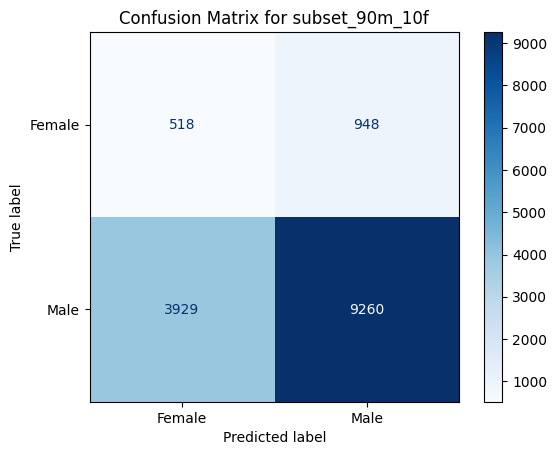

Classification Report for subset_90m_10f:
              precision    recall  f1-score   support

      Female       0.12      0.35      0.18      1466
        Male       0.91      0.70      0.79     13189

    accuracy                           0.67     14655
   macro avg       0.51      0.53      0.48     14655
weighted avg       0.83      0.67      0.73     14655



In [12]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f")

### Calculating bias levels

In [13]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0554


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Accuracy for subset_80m_20f: 0.6068


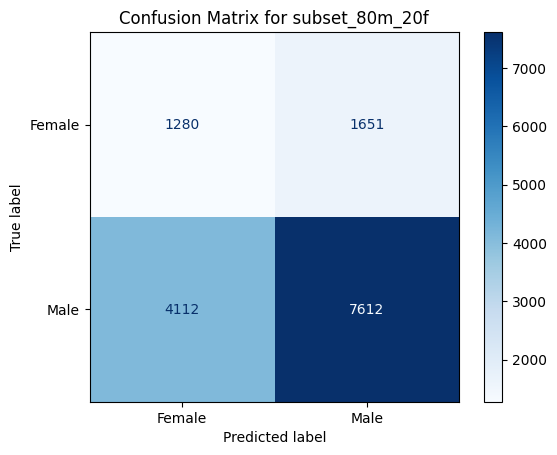

Classification Report for subset_80m_20f:
              precision    recall  f1-score   support

      Female       0.24      0.44      0.31      2931
        Male       0.82      0.65      0.73     11724

    accuracy                           0.61     14655
   macro avg       0.53      0.54      0.52     14655
weighted avg       0.70      0.61      0.64     14655



In [14]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f")

### Calculating bias levels

In [15]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0860


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Accuracy for subset_70m_30f: 0.5782


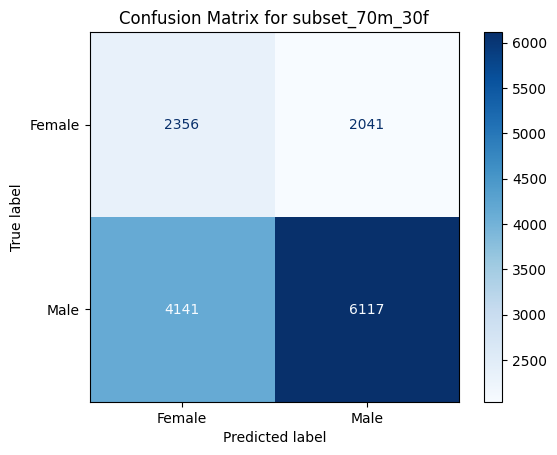

Classification Report for subset_70m_30f:
              precision    recall  f1-score   support

      Female       0.36      0.54      0.43      4397
        Male       0.75      0.60      0.66     10258

    accuracy                           0.58     14655
   macro avg       0.56      0.57      0.55     14655
weighted avg       0.63      0.58      0.59     14655



In [16]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f")

### Calculating bias levels

In [17]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1321


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Accuracy for subset_60m_40f: 0.5926


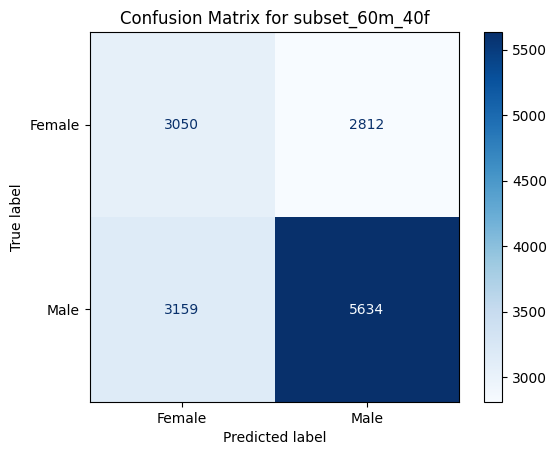

Classification Report for subset_60m_40f:
              precision    recall  f1-score   support

      Female       0.49      0.52      0.51      5862
        Male       0.67      0.64      0.65      8793

    accuracy                           0.59     14655
   macro avg       0.58      0.58      0.58     14655
weighted avg       0.60      0.59      0.59     14655



In [18]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f")

### Calculating bias levels

In [19]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1610


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Accuracy for subset_50m_50f: 0.5417


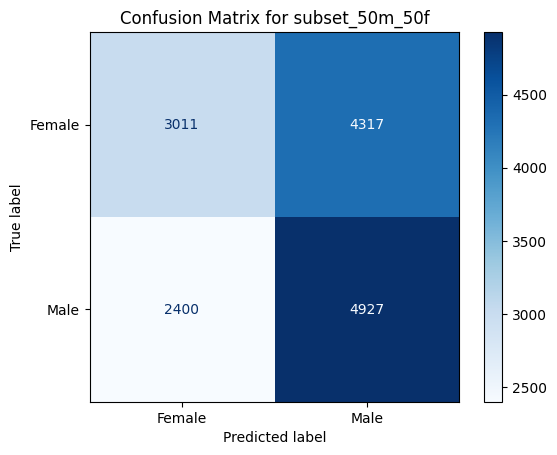

Classification Report for subset_50m_50f:
              precision    recall  f1-score   support

      Female       0.56      0.41      0.47      7328
        Male       0.53      0.67      0.59      7327

    accuracy                           0.54     14655
   macro avg       0.54      0.54      0.53     14655
weighted avg       0.54      0.54      0.53     14655



In [20]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f")

### Calculating bias levels

In [21]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0833


## Using 30% of the dataset

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Accuracy for subset_90m_10f_30: 0.6835


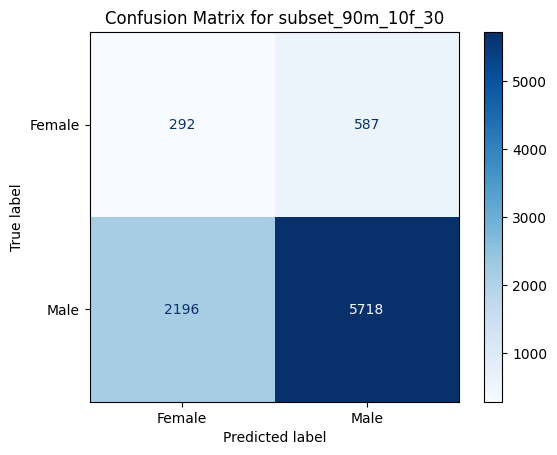

Classification Report for subset_90m_10f_30:
              precision    recall  f1-score   support

      Female       0.12      0.33      0.17       879
        Male       0.91      0.72      0.80      7914

    accuracy                           0.68      8793
   macro avg       0.51      0.53      0.49      8793
weighted avg       0.83      0.68      0.74      8793



In [32]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f_30")

### Calculating bias levels

In [33]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0547


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Accuracy for subset_80m_20f_30: 0.6014


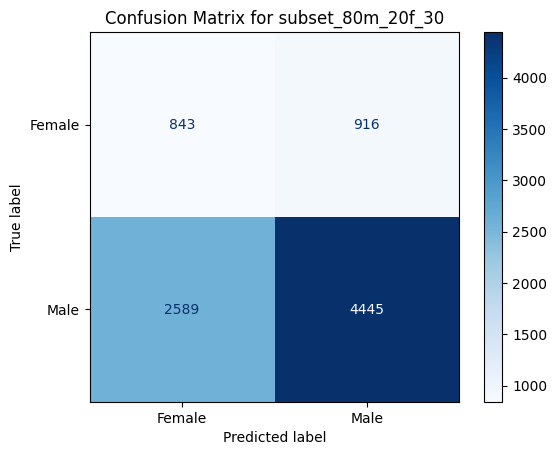

Classification Report for subset_80m_20f_30:
              precision    recall  f1-score   support

      Female       0.25      0.48      0.32      1759
        Male       0.83      0.63      0.72      7034

    accuracy                           0.60      8793
   macro avg       0.54      0.56      0.52      8793
weighted avg       0.71      0.60      0.64      8793



In [22]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f_30")

### Calculating bias levels

In [23]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1112


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Accuracy for subset_70m_30f_30: 0.5817


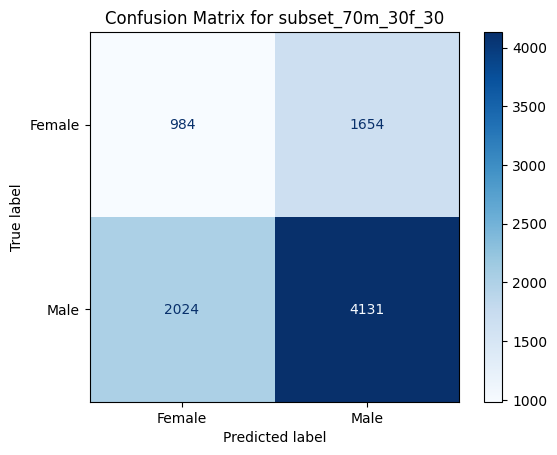

Classification Report for subset_70m_30f_30:
              precision    recall  f1-score   support

      Female       0.33      0.37      0.35      2638
        Male       0.71      0.67      0.69      6155

    accuracy                           0.58      8793
   macro avg       0.52      0.52      0.52      8793
weighted avg       0.60      0.58      0.59      8793



In [24]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f_30")

### Calculating bias levels

In [25]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0442


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Accuracy for subset_60m_40f_30: 0.5569


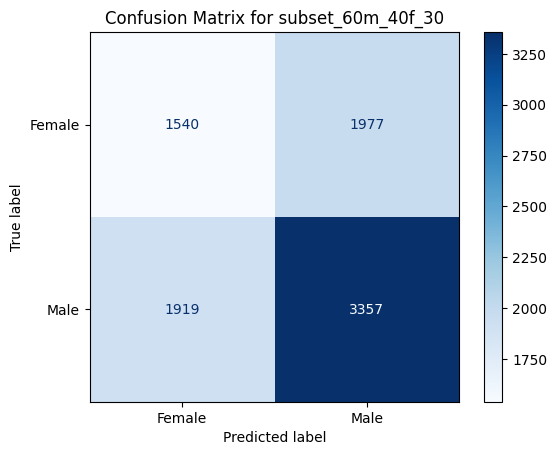

Classification Report for subset_60m_40f_30:
              precision    recall  f1-score   support

      Female       0.45      0.44      0.44      3517
        Male       0.63      0.64      0.63      5276

    accuracy                           0.56      8793
   macro avg       0.54      0.54      0.54      8793
weighted avg       0.56      0.56      0.56      8793



In [26]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f_30")

### Calculating bias levels

In [27]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0742


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Accuracy for subset_50m_50f_30: 0.5333


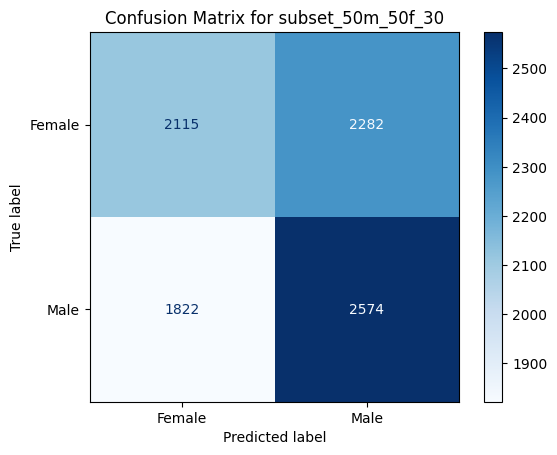

Classification Report for subset_50m_50f_30:
              precision    recall  f1-score   support

      Female       0.54      0.48      0.51      4397
        Male       0.53      0.59      0.56      4396

    accuracy                           0.53      8793
   macro avg       0.53      0.53      0.53      8793
weighted avg       0.53      0.53      0.53      8793



In [28]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f_30")

### Calculating bias levels

In [29]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0665


## Using 10% of the dataset

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Accuracy for subset_90m_10f_10: 0.7861


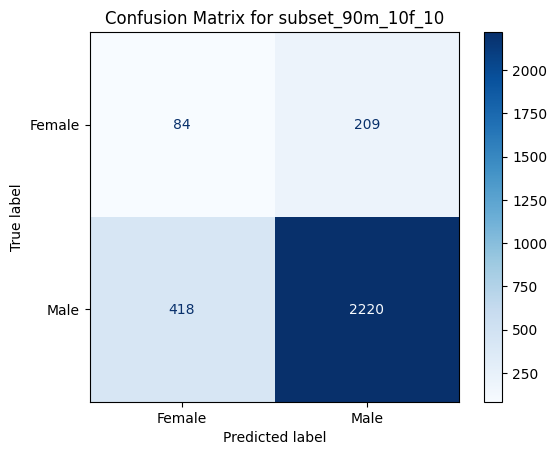

Classification Report for subset_90m_10f_10:
              precision    recall  f1-score   support

      Female       0.17      0.29      0.21       293
        Male       0.91      0.84      0.88      2638

    accuracy                           0.79      2931
   macro avg       0.54      0.56      0.54      2931
weighted avg       0.84      0.79      0.81      2931



In [19]:
# Calling the functions for each subset

# For subset_90m_10f_10

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f_10")

### Calculating bias levels

In [22]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1282


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Accuracy for subset_80m_20f_10: 0.6731


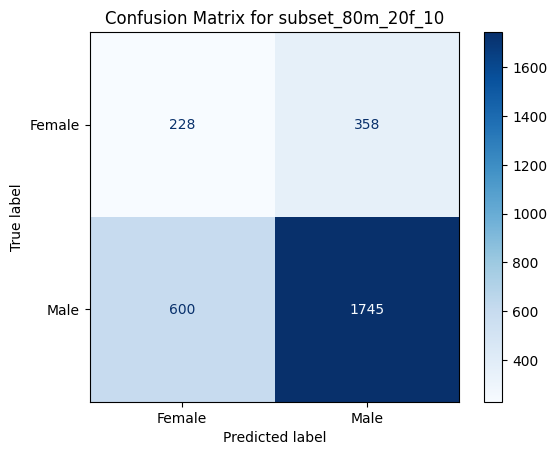

Classification Report for subset_80m_20f_10:
              precision    recall  f1-score   support

      Female       0.28      0.39      0.32       586
        Male       0.83      0.74      0.78      2345

    accuracy                           0.67      2931
   macro avg       0.55      0.57      0.55      2931
weighted avg       0.72      0.67      0.69      2931



In [22]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f_10")

### Calculating bias levels

In [23]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1332


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Accuracy for subset_70m_30f_10: 0.5855


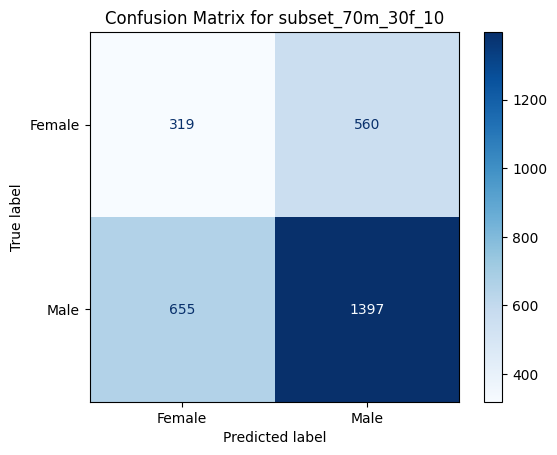

Classification Report for subset_70m_30f_10:
              precision    recall  f1-score   support

      Female       0.33      0.36      0.34       879
        Male       0.71      0.68      0.70      2052

    accuracy                           0.59      2931
   macro avg       0.52      0.52      0.52      2931
weighted avg       0.60      0.59      0.59      2931



In [24]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f_10")

### Calculating bias levels

In [25]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0437


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Accuracy for subset_60m_40f_10: 0.5510


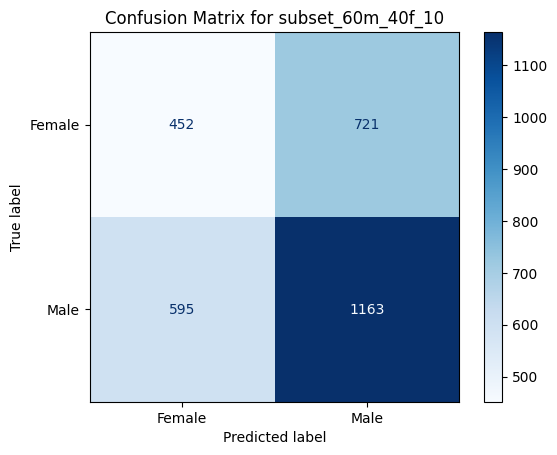

Classification Report for subset_60m_40f_10:
              precision    recall  f1-score   support

      Female       0.43      0.39      0.41      1173
        Male       0.62      0.66      0.64      1758

    accuracy                           0.55      2931
   macro avg       0.52      0.52      0.52      2931
weighted avg       0.54      0.55      0.55      2931



In [26]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f_10")

### Calculating bias levels

In [27]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0469


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Accuracy for subset_50m_50f_10: 0.5718


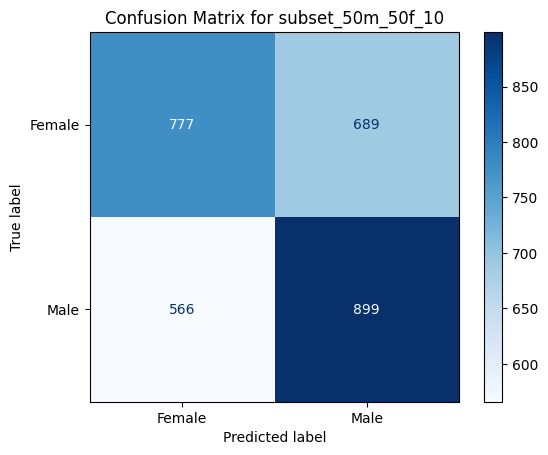

Classification Report for subset_50m_50f_10:
              precision    recall  f1-score   support

      Female       0.58      0.53      0.55      1466
        Male       0.57      0.61      0.59      1465

    accuracy                           0.57      2931
   macro avg       0.57      0.57      0.57      2931
weighted avg       0.57      0.57      0.57      2931



In [28]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f_10")

### Calculating bias levels

In [29]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1437


## SWITCHING PRIORITIES

## Using 50% of the dataset

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Accuracy for subset_90f_10m: 0.6055


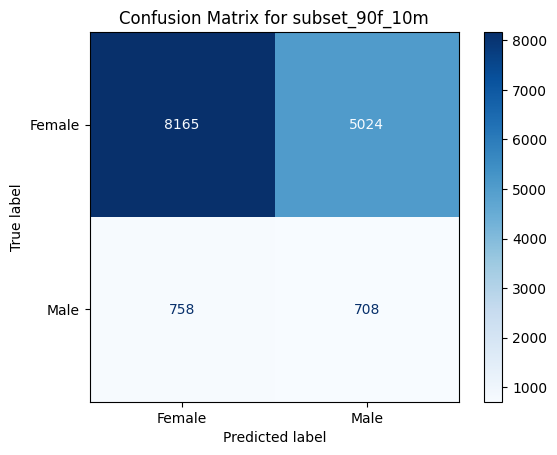

Classification Report for subset_90f_10m:
              precision    recall  f1-score   support

      Female       0.92      0.62      0.74     13189
        Male       0.12      0.48      0.20      1466

    accuracy                           0.61     14655
   macro avg       0.52      0.55      0.47     14655
weighted avg       0.84      0.61      0.68     14655



In [30]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m")

### Calculating bias levels

In [31]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1020


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Accuracy for subset_80f_20m: 0.5499


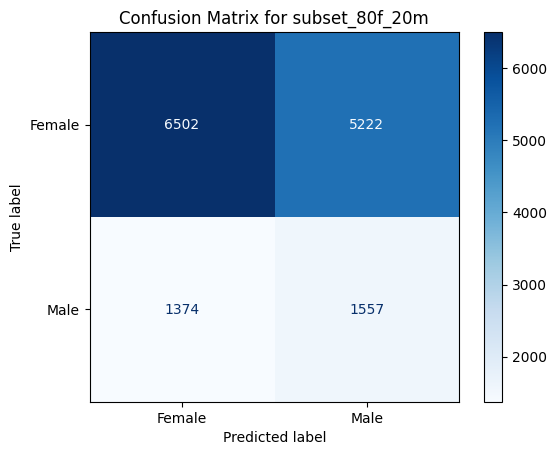

Classification Report for subset_80f_20m:
              precision    recall  f1-score   support

      Female       0.83      0.55      0.66     11724
        Male       0.23      0.53      0.32      2931

    accuracy                           0.55     14655
   macro avg       0.53      0.54      0.49     14655
weighted avg       0.71      0.55      0.59     14655



In [32]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m")

### Calculating bias levels

In [33]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0858


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Accuracy for subset_70f_30m: 0.5524


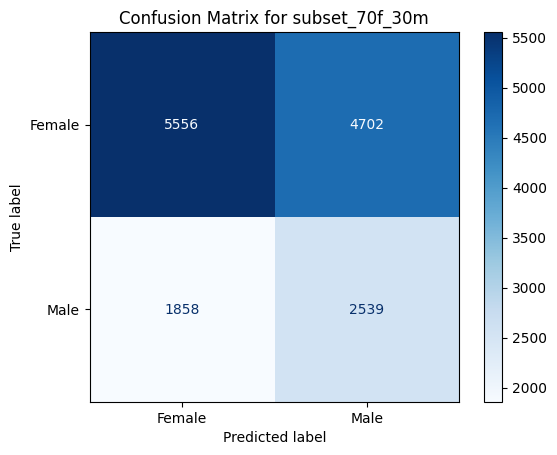

Classification Report for subset_70f_30m:
              precision    recall  f1-score   support

      Female       0.75      0.54      0.63     10258
        Male       0.35      0.58      0.44      4397

    accuracy                           0.55     14655
   macro avg       0.55      0.56      0.53     14655
weighted avg       0.63      0.55      0.57     14655



In [34]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m")

### Calculating bias levels

In [35]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1191


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Accuracy for subset_60f_40m: 0.4984


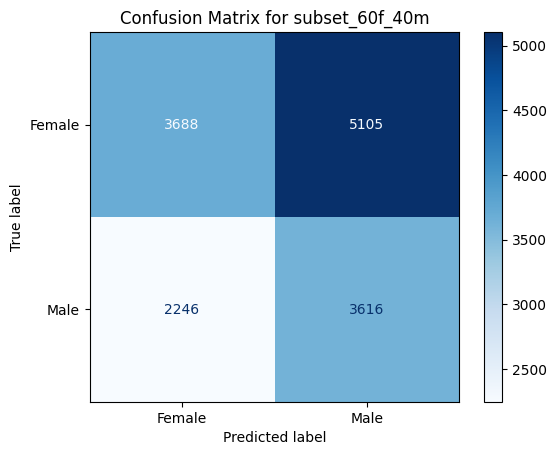

Classification Report for subset_60f_40m:
              precision    recall  f1-score   support

      Female       0.62      0.42      0.50      8793
        Male       0.41      0.62      0.50      5862

    accuracy                           0.50     14655
   macro avg       0.52      0.52      0.50     14655
weighted avg       0.54      0.50      0.50     14655



In [36]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m")

### Calculating bias levels

In [37]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0363


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Accuracy for subset_50f_50m: 0.5306


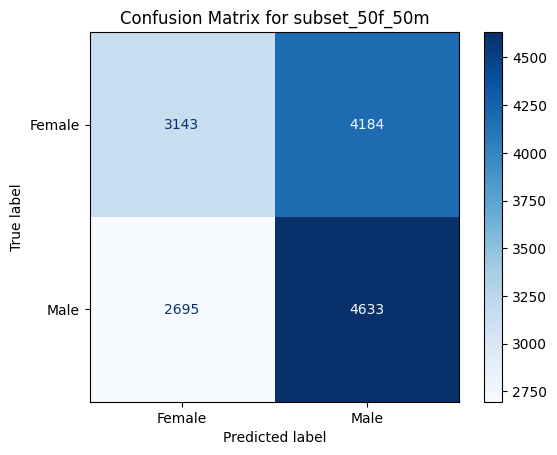

Classification Report for subset_50f_50m:
              precision    recall  f1-score   support

      Female       0.54      0.43      0.48      7327
        Male       0.53      0.63      0.57      7328

    accuracy                           0.53     14655
   macro avg       0.53      0.53      0.53     14655
weighted avg       0.53      0.53      0.53     14655



In [38]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m")

### Calculating bias levels

In [39]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0612


## Using 30% of the dataset

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Accuracy for subset_90f_10m_30: 0.6108


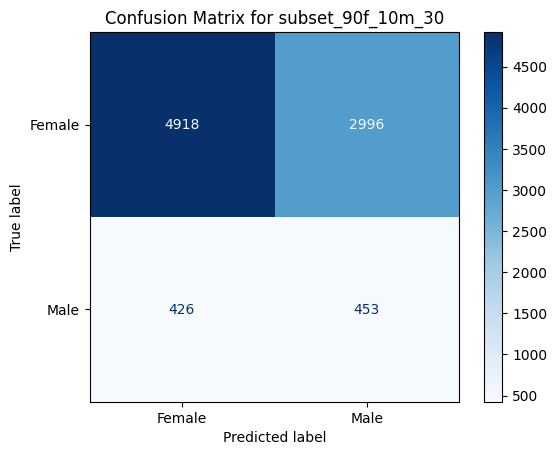

Classification Report for subset_90f_10m_30:
              precision    recall  f1-score   support

      Female       0.92      0.62      0.74      7914
        Male       0.13      0.52      0.21       879

    accuracy                           0.61      8793
   macro avg       0.53      0.57      0.48      8793
weighted avg       0.84      0.61      0.69      8793



In [40]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m_30")

### Calculating bias levels

In [41]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1368


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Accuracy for subset_80f_20m_30: 0.5369


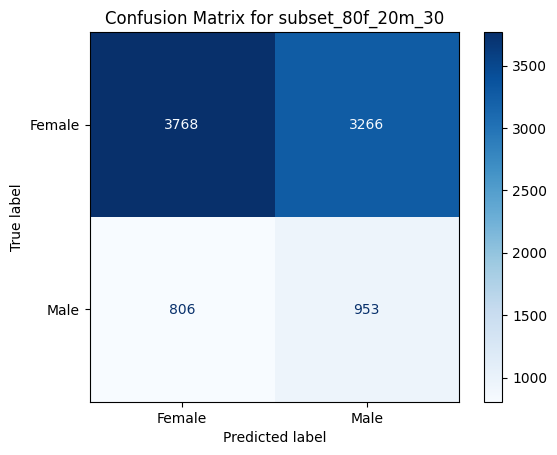

Classification Report for subset_80f_20m_30:
              precision    recall  f1-score   support

      Female       0.82      0.54      0.65      7034
        Male       0.23      0.54      0.32      1759

    accuracy                           0.54      8793
   macro avg       0.52      0.54      0.48      8793
weighted avg       0.70      0.54      0.58      8793



In [42]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m_30")

### Calculating bias levels

In [43]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0775


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Accuracy for subset_70f_30m_30: 0.4953


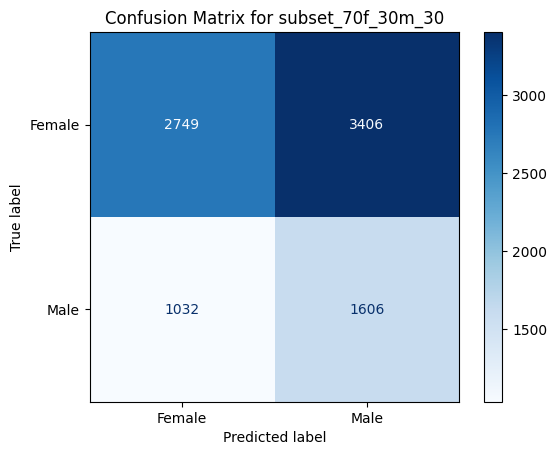

Classification Report for subset_70f_30m_30:
              precision    recall  f1-score   support

      Female       0.73      0.45      0.55      6155
        Male       0.32      0.61      0.42      2638

    accuracy                           0.50      8793
   macro avg       0.52      0.53      0.49      8793
weighted avg       0.61      0.50      0.51      8793



In [44]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m_30")

### Calculating bias levels

In [45]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0554


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Accuracy for subset_60f_40m_30: 0.5202


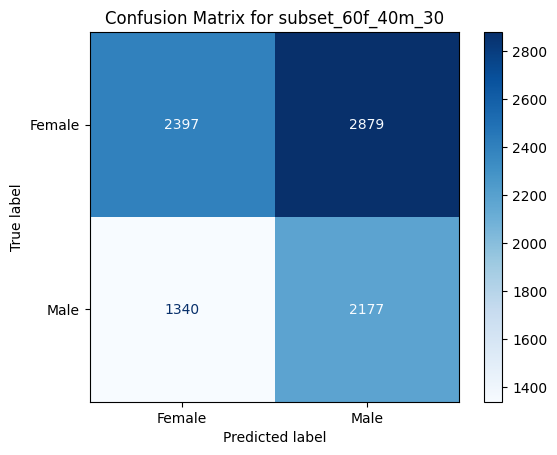

Classification Report for subset_60f_40m_30:
              precision    recall  f1-score   support

      Female       0.64      0.45      0.53      5276
        Male       0.43      0.62      0.51      3517

    accuracy                           0.52      8793
   macro avg       0.54      0.54      0.52      8793
weighted avg       0.56      0.52      0.52      8793



In [46]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m_30")

### Calculating bias levels

In [47]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0733


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Accuracy for subset_50f_50m_30: 0.5469


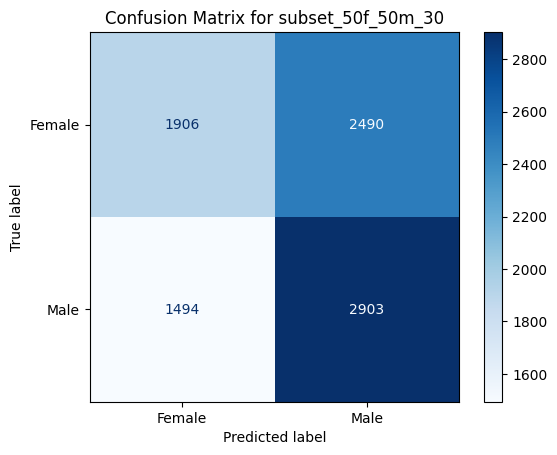

Classification Report for subset_50f_50m_30:
              precision    recall  f1-score   support

      Female       0.56      0.43      0.49      4396
        Male       0.54      0.66      0.59      4397

    accuracy                           0.55      8793
   macro avg       0.55      0.55      0.54      8793
weighted avg       0.55      0.55      0.54      8793



In [48]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m_30")

### Calculating bias levels

In [49]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0938


## Using 10% of the dataset

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Accuracy for subset_90f_10m_10: 0.7615


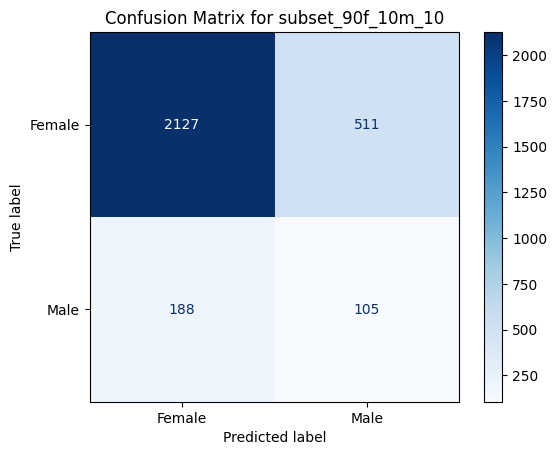

Classification Report for subset_90f_10m_10:
              precision    recall  f1-score   support

      Female       0.92      0.81      0.86      2638
        Male       0.17      0.36      0.23       293

    accuracy                           0.76      2931
   macro avg       0.54      0.58      0.54      2931
weighted avg       0.84      0.76      0.80      2931



In [50]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m_10")

### Calculating bias levels

In [51]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1647


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Accuracy for subset_80f_20m_10: 0.5363


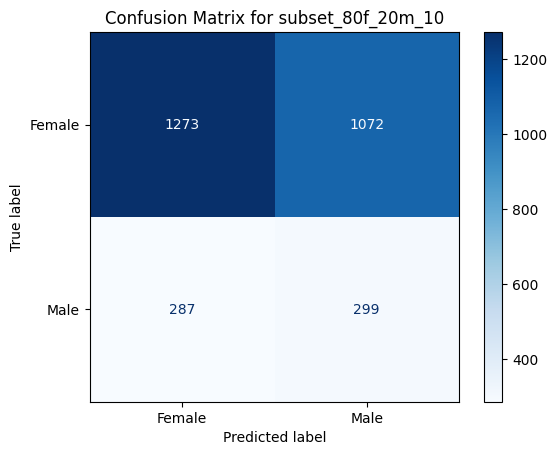

Classification Report for subset_80f_20m_10:
              precision    recall  f1-score   support

      Female       0.82      0.54      0.65      2345
        Male       0.22      0.51      0.31       586

    accuracy                           0.54      2931
   macro avg       0.52      0.53      0.48      2931
weighted avg       0.70      0.54      0.58      2931



In [52]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m_10")

### Calculating bias levels

In [53]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0531


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Accuracy for subset_70f_30m_10: 0.6196


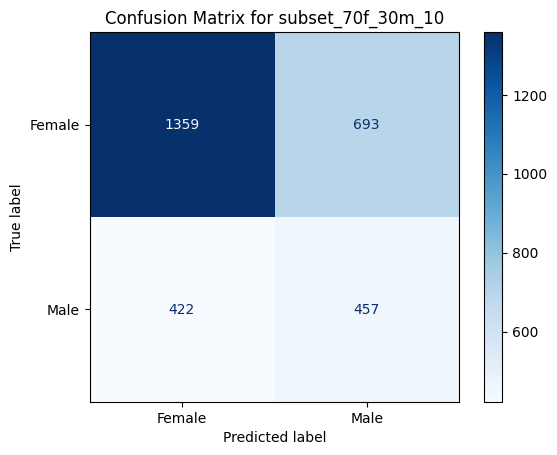

Classification Report for subset_70f_30m_10:
              precision    recall  f1-score   support

      Female       0.76      0.66      0.71      2052
        Male       0.40      0.52      0.45       879

    accuracy                           0.62      2931
   macro avg       0.58      0.59      0.58      2931
weighted avg       0.65      0.62      0.63      2931



In [54]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m_10")

### Calculating bias levels

In [55]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1822


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Accuracy for subset_60f_40m_10: 0.5913


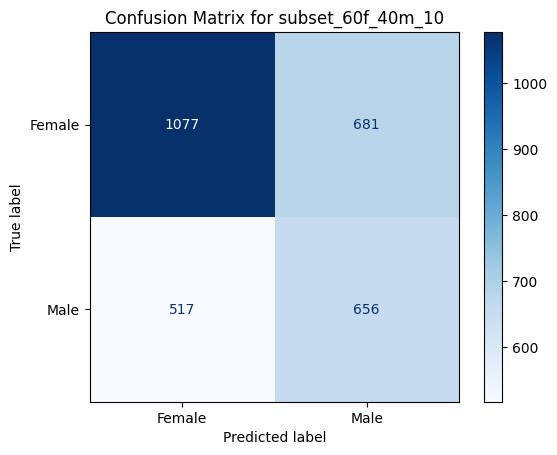

Classification Report for subset_60f_40m_10:
              precision    recall  f1-score   support

      Female       0.68      0.61      0.64      1758
        Male       0.49      0.56      0.52      1173

    accuracy                           0.59      2931
   macro avg       0.58      0.59      0.58      2931
weighted avg       0.60      0.59      0.59      2931



In [56]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m_10")

### Calculating bias levels

In [57]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1719


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Accuracy for subset_50f_50m_10: 0.5629


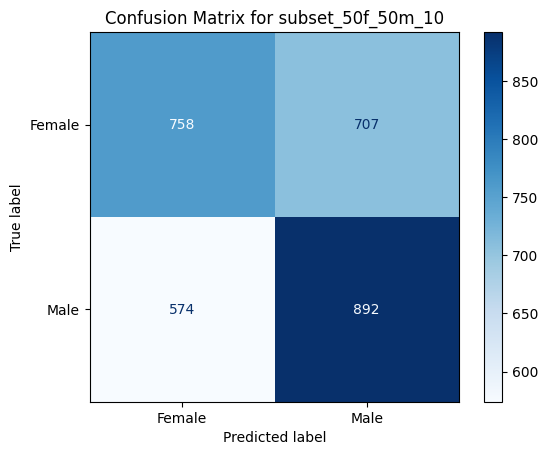

Classification Report for subset_50f_50m_10:
              precision    recall  f1-score   support

      Female       0.57      0.52      0.54      1465
        Male       0.56      0.61      0.58      1466

    accuracy                           0.56      2931
   macro avg       0.56      0.56      0.56      2931
weighted avg       0.56      0.56      0.56      2931



In [58]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m_10")

### Calculating bias levels

In [59]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1259


## APPLYING HYPERPARAMETER TUNING

In [13]:
def train_and_evaluate_svm(subset_dir):
    subset_csv = os.path.join(subset_dir, 'subset.csv')
    biased_subset = pd.read_csv(subset_csv)
    
    X = load_images(biased_subset['file'], biased_subset['gender'], subset_dir)
    y = biased_subset['gender'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    
    param_dist = {
        'C': uniform(0.1, 10),
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
    
    random_search = RandomizedSearchCV(SVC(random_state=0), param_distributions=param_dist, n_iter=10, cv=5, verbose=2, n_jobs=-1, random_state=0)
    random_search.fit(X_train, y_train)
    
    print(f'Best parameters for {subset_dir}: {random_search.best_params_}')
    
    best_svm_model = random_search.best_estimator_
    y_pred = best_svm_model.predict(X_test)
    
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy for {subset_dir}: {accuracy:.4f}')
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {subset_dir}')
    plt.show()
    
    report = classification_report(y_test, y_pred, target_names=["Female", "Male"])
    print(f'Classification Report for {subset_dir}:\n{report}')
    
    return X_test, y_test, y_pred

### Applying the tuning to the 50:50 male to female ratio using 10% of the dataset

Total images not found: 0
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for subset_50m_50f_10: {'C': 9.736627605010293, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for subset_50m_50f_10: 0.6909


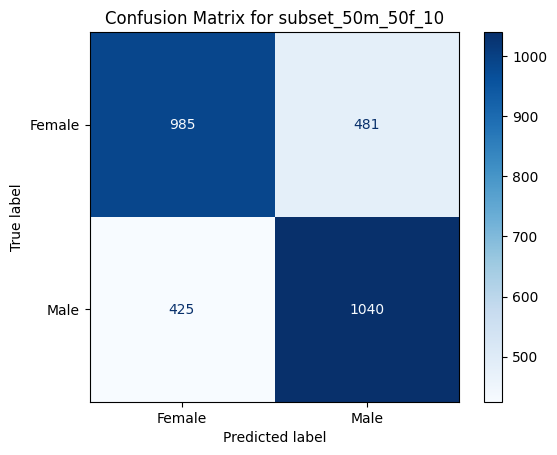

Classification Report for subset_50m_50f_10:
              precision    recall  f1-score   support

      Female       0.70      0.67      0.68      1466
        Male       0.68      0.71      0.70      1465

    accuracy                           0.69      2931
   macro avg       0.69      0.69      0.69      2931
weighted avg       0.69      0.69      0.69      2931



In [101]:
# Calling the train_and_evaluate function

X_test_50, y_test_50, y_pred_50 = train_and_evaluate_svm("subset_50m_50f_10")

In [102]:
# Calling the calculate bias function

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3818


### SWITCHING PRIORITIES

### Applying the tuning to the 50:50 female to male ratio using 10% of the dataset

Total images not found: 0
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for subset_50f_50m_10: {'C': 9.736627605010293, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for subset_50f_50m_10: 0.6875


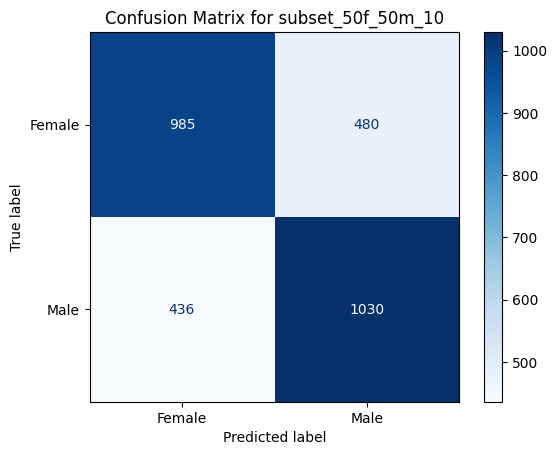

Classification Report for subset_50f_50m_10:
              precision    recall  f1-score   support

      Female       0.69      0.67      0.68      1465
        Male       0.68      0.70      0.69      1466

    accuracy                           0.69      2931
   macro avg       0.69      0.69      0.69      2931
weighted avg       0.69      0.69      0.69      2931



In [103]:
# Calling the train_and_evaluate function

X_test_50, y_test_50, y_pred_50 = train_and_evaluate_svm("subset_50f_50m_10")

In [104]:
# Calling the calculate bias function

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3749


# RANDOM FOREST

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
# Function to load images and preprocess
def load_images(image_paths, genders, base_dir):
    images = []
    not_found_count = 0
    for path, gender in zip(image_paths, genders):
        img_name = path.split('/')[1]
        gender_dir = 'male' if gender == 1 else 'female'
        img_path = os.path.join(base_dir, gender_dir, img_name)
        
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=(64, 64))  # Resize to 64x64
            img = img_to_array(img)
            img = img.flatten()  # Flatten the image for Random Forest
            images.append(img)
        else:
            print(f"Image not found: {img_path}")
            not_found_count += 1
    print(f"Total images not found: {not_found_count}")
    return np.array(images)

In [17]:
# Function to train and evaluate the model
def train_and_evaluate(subset_dir):
    subset_csv = os.path.join(subset_dir, 'subset.csv')
    biased_subset = pd.read_csv(subset_csv)
    
    X = load_images(biased_subset['file'], biased_subset['gender'], subset_dir)
    y = biased_subset['gender'].values
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    
    # Define and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
    rf_model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    
    # Accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy for {subset_dir}: {accuracy:.4f}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {subset_dir}')
    plt.show()
    
    # Classification Report
    report = classification_report(y_test, y_pred, target_names=["Female", "Male"])
    print(f'Classification Report for {subset_dir}:\n{report}')
    
    # Return the necessary data for bias calculation
    return X_test, y_test, y_pred

In [18]:
# Function to calculate bias
def calculate_bias(X_test, y_test, y_pred):
    # Convert to aif360 BinaryLabelDataset for bias checking
    class ImageGenderDataset(BinaryLabelDataset):
        def __init__(self, df, label_names=['gender'], protected_attribute_names=['gender']):
            super().__init__(df=df, label_names=label_names, protected_attribute_names=protected_attribute_names)
    
    # Create aif360 datasets
    test_numerical_df = pd.DataFrame({'gender': y_test})
    dataset_orig_test = ImageGenderDataset(df=test_numerical_df)
    
    pred_numerical_df = pd.DataFrame({'gender': y_pred})
    dataset_pred = ImageGenderDataset(df=pred_numerical_df)
    
    # Ensure that dataset_pred has the same structure and metadata as dataset_orig_test
    dataset_pred.feature_names = dataset_orig_test.feature_names
    dataset_pred.protected_attribute_names = dataset_orig_test.protected_attribute_names
    dataset_pred.instance_weights = np.copy(dataset_orig_test.instance_weights)
    dataset_pred.protected_attributes = np.copy(dataset_orig_test.protected_attributes)
    dataset_pred.metadata = dataset_orig_test.metadata.copy()
     
    # Metric for model predictions
    metric_pred = ClassificationMetric(
        dataset_orig_test,
        dataset_pred,
        unprivileged_groups=[{'gender': 0}],
        privileged_groups=[{'gender': 1}]
    )
    
    difference = metric_pred.mean_difference()
    formatted_difference = f"{difference:.4f}"
    print(f"Difference in mean outcomes between privileged and unprivileged groups (model predictions): {formatted_difference}")

## Using 50% of the dataset

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Accuracy for subset_90m_10f: 0.9015


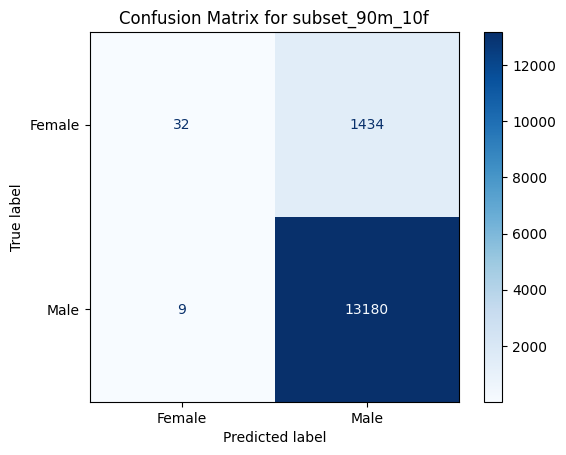

Classification Report for subset_90m_10f:
              precision    recall  f1-score   support

      Female       0.78      0.02      0.04      1466
        Male       0.90      1.00      0.95     13189

    accuracy                           0.90     14655
   macro avg       0.84      0.51      0.50     14655
weighted avg       0.89      0.90      0.86     14655



In [25]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f")

### Calculating bias levels

In [26]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0211


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Accuracy for subset_80m_20f: 0.8168


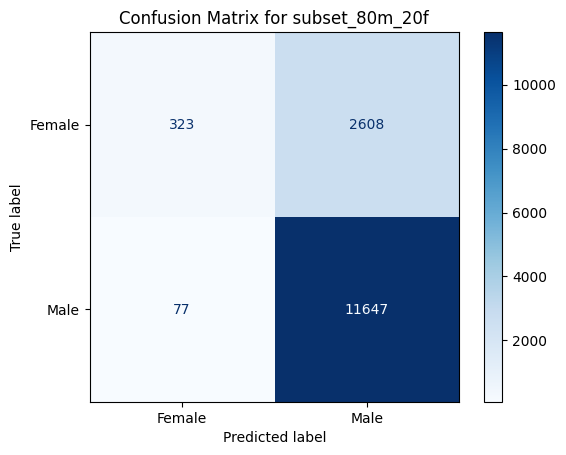

Classification Report for subset_80m_20f:
              precision    recall  f1-score   support

      Female       0.81      0.11      0.19      2931
        Male       0.82      0.99      0.90     11724

    accuracy                           0.82     14655
   macro avg       0.81      0.55      0.55     14655
weighted avg       0.82      0.82      0.76     14655



In [27]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f")

### Calculating bias levels

In [28]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1036


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Accuracy for subset_70m_30f: 0.7481


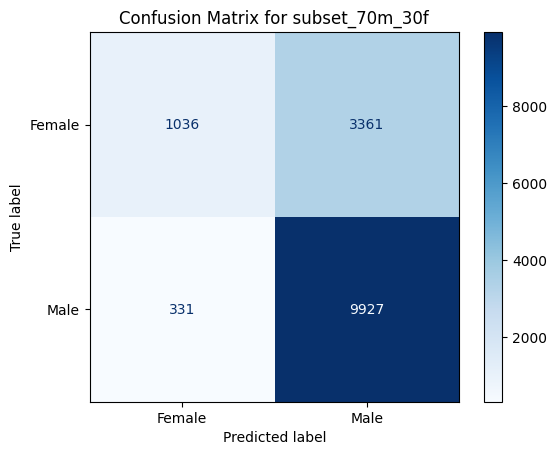

Classification Report for subset_70m_30f:
              precision    recall  f1-score   support

      Female       0.76      0.24      0.36      4397
        Male       0.75      0.97      0.84     10258

    accuracy                           0.75     14655
   macro avg       0.75      0.60      0.60     14655
weighted avg       0.75      0.75      0.70     14655



In [29]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f")

### Calculating bias levels

In [30]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2033


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Accuracy for subset_60m_40f: 0.7110


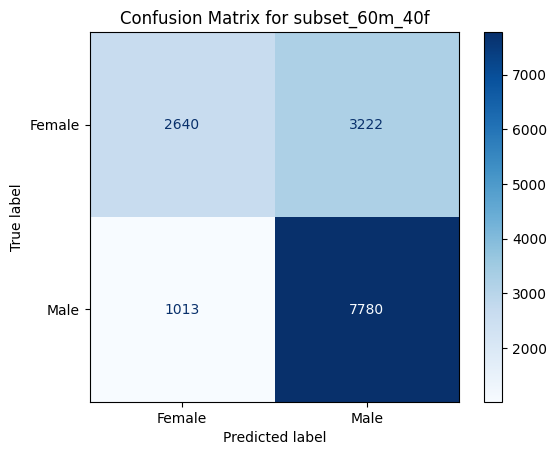

Classification Report for subset_60m_40f:
              precision    recall  f1-score   support

      Female       0.72      0.45      0.55      5862
        Male       0.71      0.88      0.79      8793

    accuracy                           0.71     14655
   macro avg       0.71      0.67      0.67     14655
weighted avg       0.71      0.71      0.69     14655



In [31]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f")

### Calculating bias levels

In [32]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3352


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Accuracy for subset_50m_50f: 0.7056


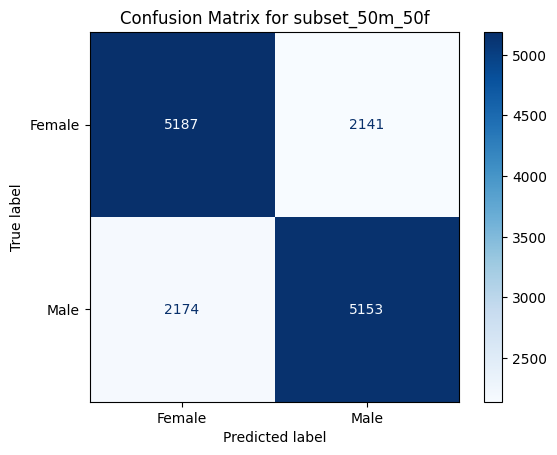

Classification Report for subset_50m_50f:
              precision    recall  f1-score   support

      Female       0.70      0.71      0.71      7328
        Male       0.71      0.70      0.70      7327

    accuracy                           0.71     14655
   macro avg       0.71      0.71      0.71     14655
weighted avg       0.71      0.71      0.71     14655



In [33]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f")

### Calculating bias levels

In [34]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.4111


## Using 30% of the dataset

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Accuracy for subset_90m_10f_30: 0.9013


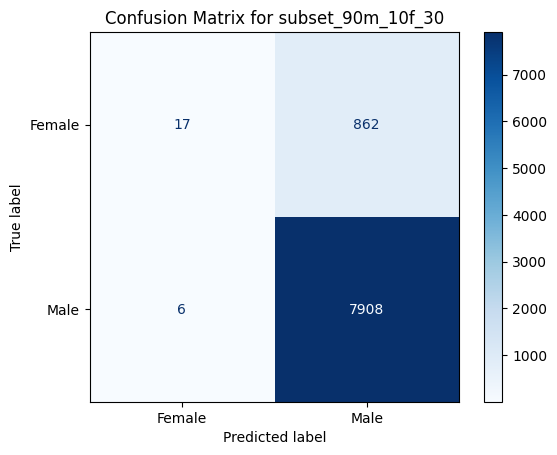

Classification Report for subset_90m_10f_30:
              precision    recall  f1-score   support

      Female       0.74      0.02      0.04       879
        Male       0.90      1.00      0.95      7914

    accuracy                           0.90      8793
   macro avg       0.82      0.51      0.49      8793
weighted avg       0.89      0.90      0.86      8793



In [35]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f_30")

### Calculating bias levels

In [36]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0186


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Accuracy for subset_80m_20f_30: 0.8125


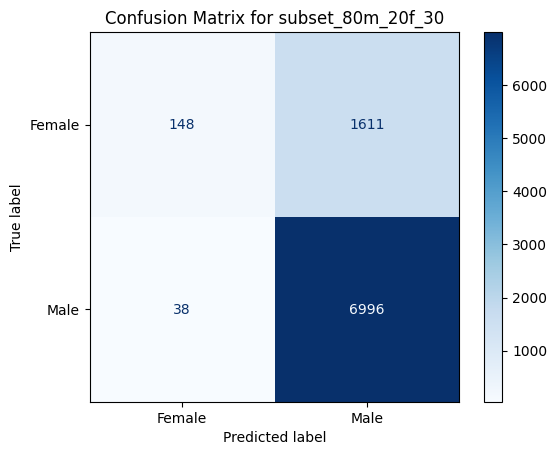

Classification Report for subset_80m_20f_30:
              precision    recall  f1-score   support

      Female       0.80      0.08      0.15      1759
        Male       0.81      0.99      0.89      7034

    accuracy                           0.81      8793
   macro avg       0.80      0.54      0.52      8793
weighted avg       0.81      0.81      0.75      8793



In [37]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f_30")

### Calculating bias levels

In [38]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0787


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Accuracy for subset_70m_30f_30: 0.7437


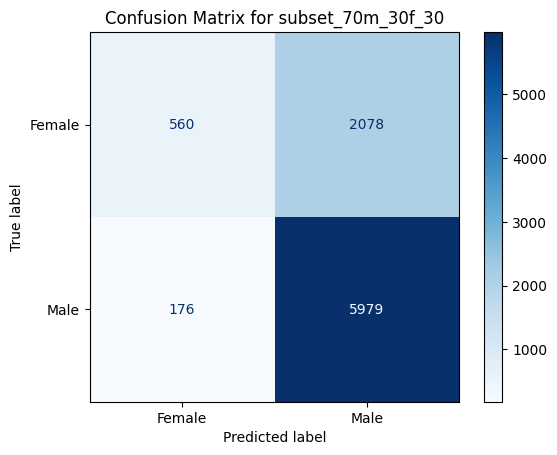

Classification Report for subset_70m_30f_30:
              precision    recall  f1-score   support

      Female       0.76      0.21      0.33      2638
        Male       0.74      0.97      0.84      6155

    accuracy                           0.74      8793
   macro avg       0.75      0.59      0.59      8793
weighted avg       0.75      0.74      0.69      8793



In [39]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f_30")

### Calculating bias levels

In [40]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1837


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Accuracy for subset_60m_40f_30: 0.6991


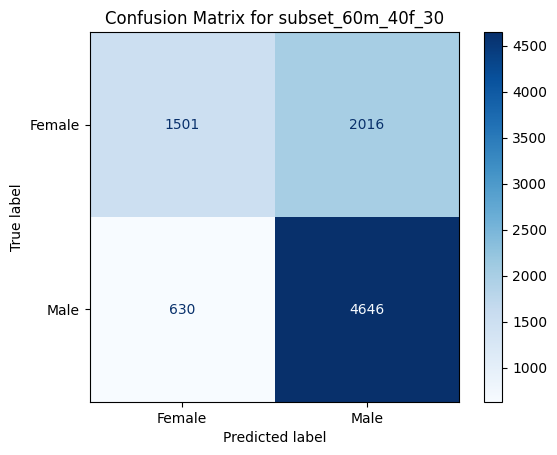

Classification Report for subset_60m_40f_30:
              precision    recall  f1-score   support

      Female       0.70      0.43      0.53      3517
        Male       0.70      0.88      0.78      5276

    accuracy                           0.70      8793
   macro avg       0.70      0.65      0.65      8793
weighted avg       0.70      0.70      0.68      8793



In [41]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f_30")

### Calculating bias levels

In [42]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3074


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Accuracy for subset_50m_50f_30: 0.6818


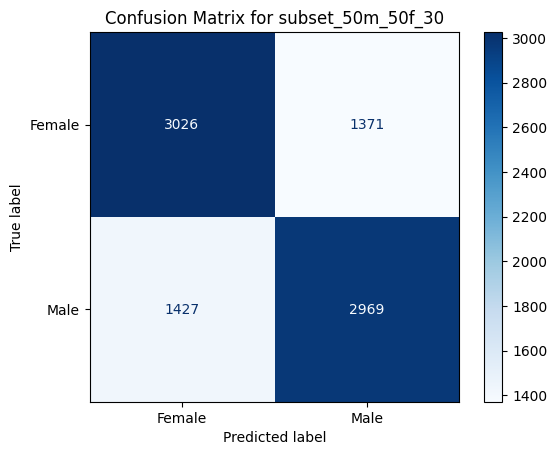

Classification Report for subset_50m_50f_30:
              precision    recall  f1-score   support

      Female       0.68      0.69      0.68      4397
        Male       0.68      0.68      0.68      4396

    accuracy                           0.68      8793
   macro avg       0.68      0.68      0.68      8793
weighted avg       0.68      0.68      0.68      8793



In [43]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f_30")

### Calculating bias levels

In [44]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3636


## Using 10% of the dataset

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Accuracy for subset_90m_10f_10: 0.8997


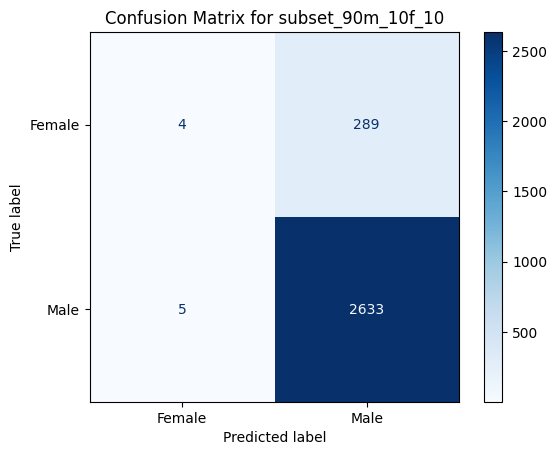

Classification Report for subset_90m_10f_10:
              precision    recall  f1-score   support

      Female       0.44      0.01      0.03       293
        Male       0.90      1.00      0.95      2638

    accuracy                           0.90      2931
   macro avg       0.67      0.51      0.49      2931
weighted avg       0.86      0.90      0.86      2931



In [15]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f_10")

### Calculating bias levels

In [16]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0118


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Accuracy for subset_80m_20f_10: 0.8059


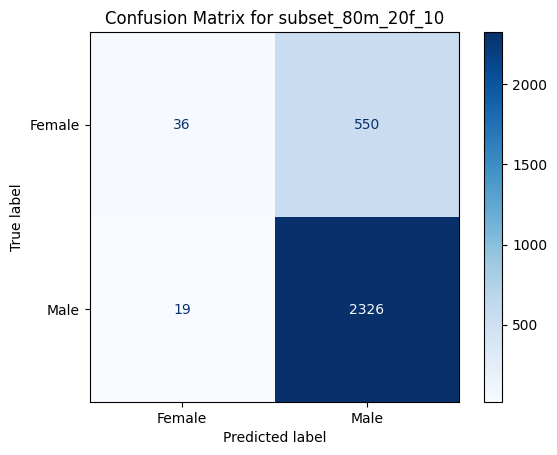

Classification Report for subset_80m_20f_10:
              precision    recall  f1-score   support

      Female       0.65      0.06      0.11       586
        Male       0.81      0.99      0.89      2345

    accuracy                           0.81      2931
   macro avg       0.73      0.53      0.50      2931
weighted avg       0.78      0.81      0.74      2931



In [17]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f_10")

### Calculating bias levels

In [18]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0533


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Accuracy for subset_70m_30f_10: 0.7335


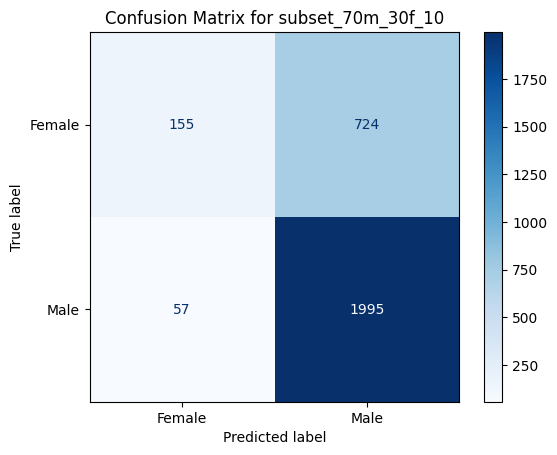

Classification Report for subset_70m_30f_10:
              precision    recall  f1-score   support

      Female       0.73      0.18      0.28       879
        Male       0.73      0.97      0.84      2052

    accuracy                           0.73      2931
   macro avg       0.73      0.57      0.56      2931
weighted avg       0.73      0.73      0.67      2931



In [19]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f_10")

### Calculating bias levels

In [20]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1486


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Accuracy for subset_60m_40f_10: 0.6749


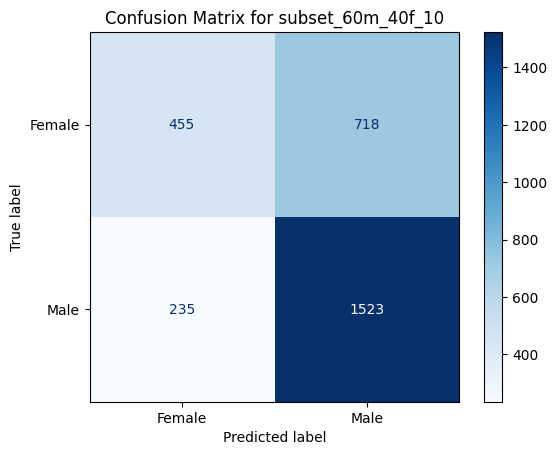

Classification Report for subset_60m_40f_10:
              precision    recall  f1-score   support

      Female       0.66      0.39      0.49      1173
        Male       0.68      0.87      0.76      1758

    accuracy                           0.67      2931
   macro avg       0.67      0.63      0.63      2931
weighted avg       0.67      0.67      0.65      2931



In [21]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f_10")

### Calculating bias levels

In [22]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2542


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Accuracy for subset_50m_50f_10: 0.6489


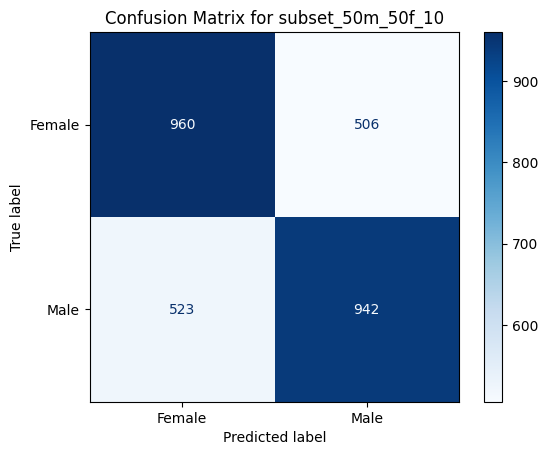

Classification Report for subset_50m_50f_10:
              precision    recall  f1-score   support

      Female       0.65      0.65      0.65      1466
        Male       0.65      0.64      0.65      1465

    accuracy                           0.65      2931
   macro avg       0.65      0.65      0.65      2931
weighted avg       0.65      0.65      0.65      2931



In [23]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f_10")

### Calculating bias levels

In [24]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2978


## SWITCHING PRIORITIES

## Using 50% of the dataset

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Accuracy for subset_90f_10m: 0.9004


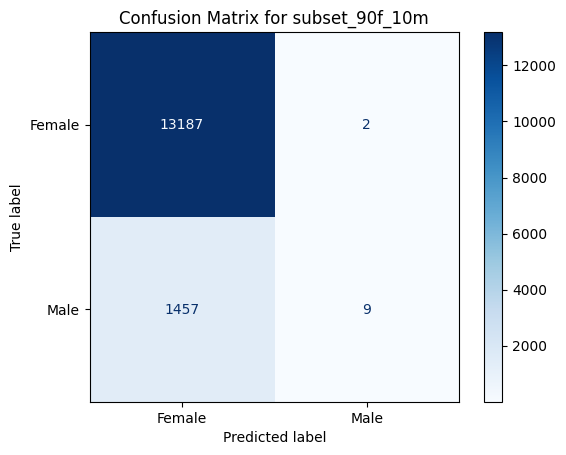

Classification Report for subset_90f_10m:
              precision    recall  f1-score   support

      Female       0.90      1.00      0.95     13189
        Male       0.82      0.01      0.01      1466

    accuracy                           0.90     14655
   macro avg       0.86      0.50      0.48     14655
weighted avg       0.89      0.90      0.85     14655



In [45]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m")

### Calculating bias levels

In [46]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0060


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Accuracy for subset_80f_20m: 0.8057


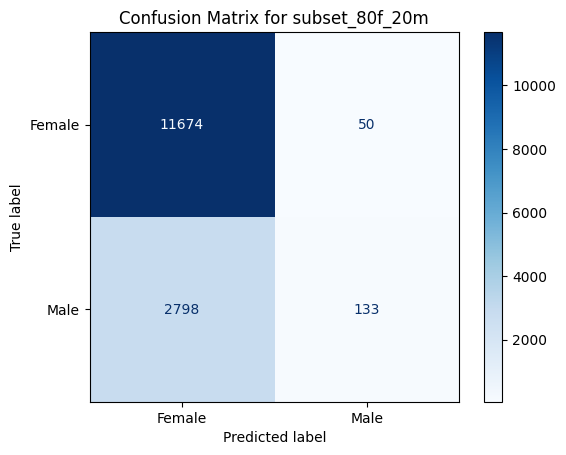

Classification Report for subset_80f_20m:
              precision    recall  f1-score   support

      Female       0.81      1.00      0.89     11724
        Male       0.73      0.05      0.09      2931

    accuracy                           0.81     14655
   macro avg       0.77      0.52      0.49     14655
weighted avg       0.79      0.81      0.73     14655



In [47]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m")

### Calculating bias levels

In [48]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0411


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Accuracy for subset_70f_30m: 0.7348


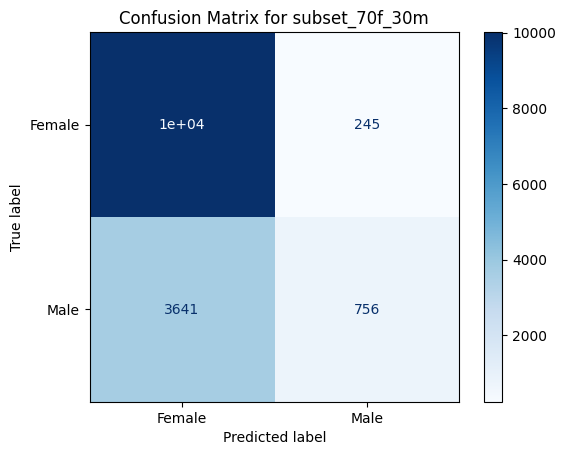

Classification Report for subset_70f_30m:
              precision    recall  f1-score   support

      Female       0.73      0.98      0.84     10258
        Male       0.76      0.17      0.28      4397

    accuracy                           0.73     14655
   macro avg       0.74      0.57      0.56     14655
weighted avg       0.74      0.73      0.67     14655



In [49]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m")

### Calculating bias levels

In [50]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1481


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Accuracy for subset_60f_40m: 0.7027


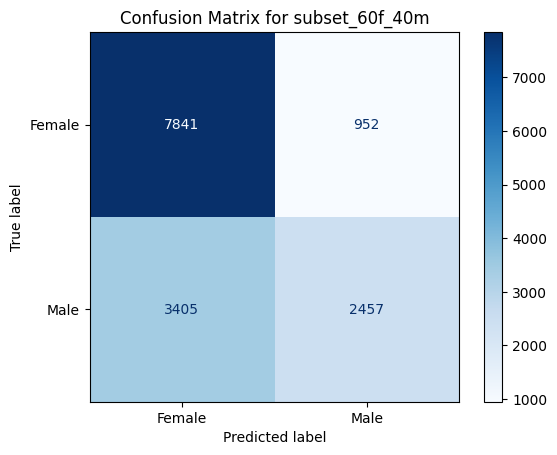

Classification Report for subset_60f_40m:
              precision    recall  f1-score   support

      Female       0.70      0.89      0.78      8793
        Male       0.72      0.42      0.53      5862

    accuracy                           0.70     14655
   macro avg       0.71      0.66      0.66     14655
weighted avg       0.71      0.70      0.68     14655



In [51]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m")

### Calculating bias levels

In [52]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3109


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Accuracy for subset_50f_50m: 0.7000


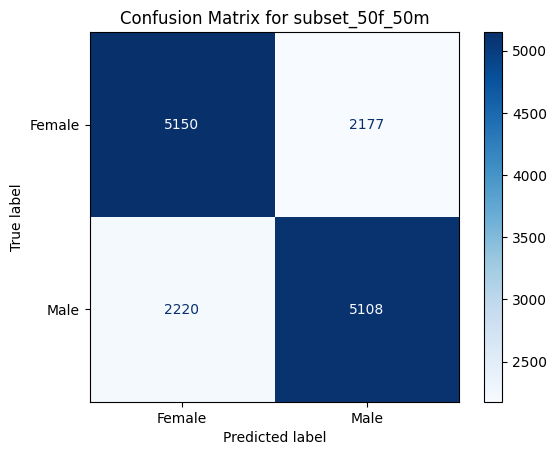

Classification Report for subset_50f_50m:
              precision    recall  f1-score   support

      Female       0.70      0.70      0.70      7327
        Male       0.70      0.70      0.70      7328

    accuracy                           0.70     14655
   macro avg       0.70      0.70      0.70     14655
weighted avg       0.70      0.70      0.70     14655



In [53]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m")

### Calculating bias levels

In [54]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3999


## Using 30% of the dataset

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Accuracy for subset_90f_10m_30: 0.9006


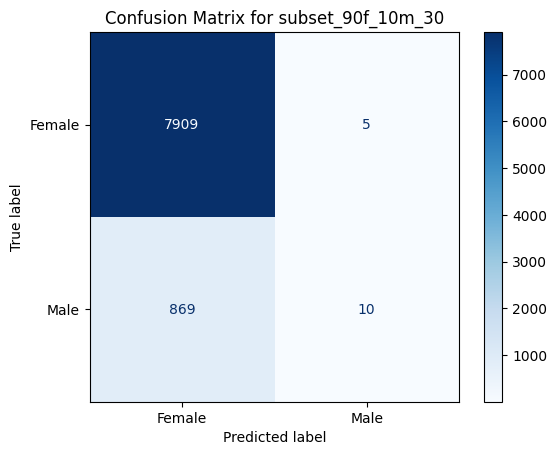

Classification Report for subset_90f_10m_30:
              precision    recall  f1-score   support

      Female       0.90      1.00      0.95      7914
        Male       0.67      0.01      0.02       879

    accuracy                           0.90      8793
   macro avg       0.78      0.51      0.49      8793
weighted avg       0.88      0.90      0.86      8793



In [55]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m_30")

### Calculating bias levels

In [56]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0107


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Accuracy for subset_80f_20m_30: 0.8040


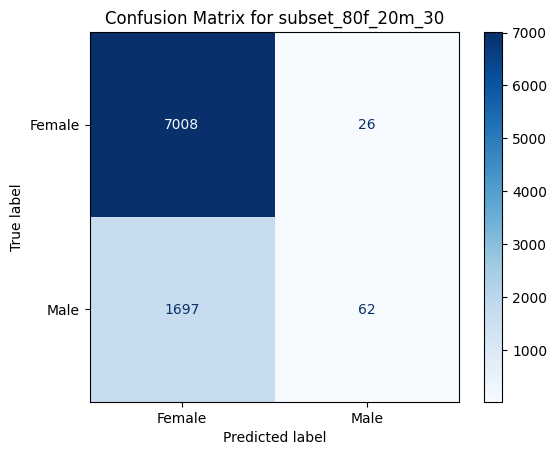

Classification Report for subset_80f_20m_30:
              precision    recall  f1-score   support

      Female       0.81      1.00      0.89      7034
        Male       0.70      0.04      0.07      1759

    accuracy                           0.80      8793
   macro avg       0.75      0.52      0.48      8793
weighted avg       0.78      0.80      0.73      8793



In [57]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m_30")

### Calculating bias levels

In [58]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0316


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Accuracy for subset_70f_30m_30: 0.7240


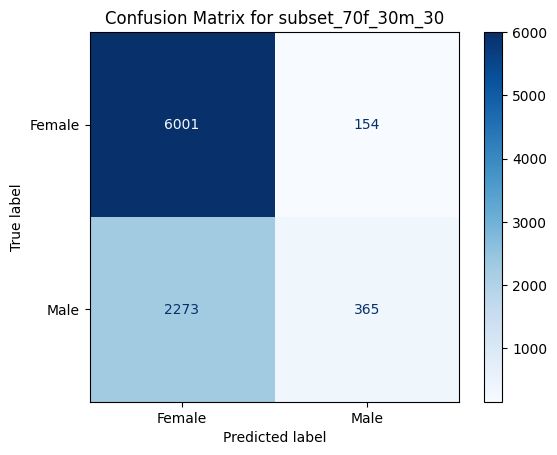

Classification Report for subset_70f_30m_30:
              precision    recall  f1-score   support

      Female       0.73      0.97      0.83      6155
        Male       0.70      0.14      0.23      2638

    accuracy                           0.72      8793
   macro avg       0.71      0.56      0.53      8793
weighted avg       0.72      0.72      0.65      8793



In [59]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m_30")

### Calculating bias levels

In [60]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1133


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Accuracy for subset_60f_40m_30: 0.6893


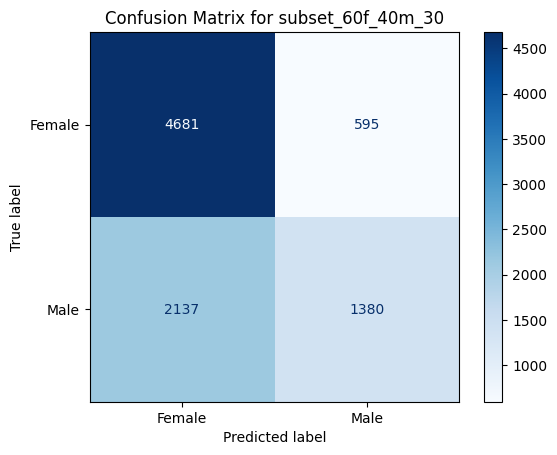

Classification Report for subset_60f_40m_30:
              precision    recall  f1-score   support

      Female       0.69      0.89      0.77      5276
        Male       0.70      0.39      0.50      3517

    accuracy                           0.69      8793
   macro avg       0.69      0.64      0.64      8793
weighted avg       0.69      0.69      0.67      8793



In [61]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m_30")

### Calculating bias levels

In [62]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2796


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Accuracy for subset_50f_50m_30: 0.6832


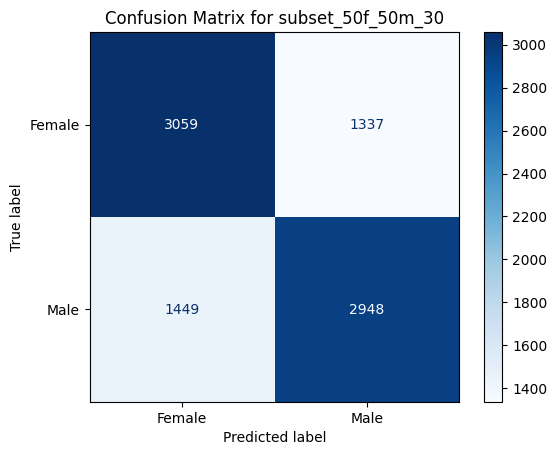

Classification Report for subset_50f_50m_30:
              precision    recall  f1-score   support

      Female       0.68      0.70      0.69      4396
        Male       0.69      0.67      0.68      4397

    accuracy                           0.68      8793
   macro avg       0.68      0.68      0.68      8793
weighted avg       0.68      0.68      0.68      8793



In [63]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m_30")

### Calculating bias levels

In [64]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3663


## Using 10% of the dataset

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Accuracy for subset_90f_10m_10: 0.9000


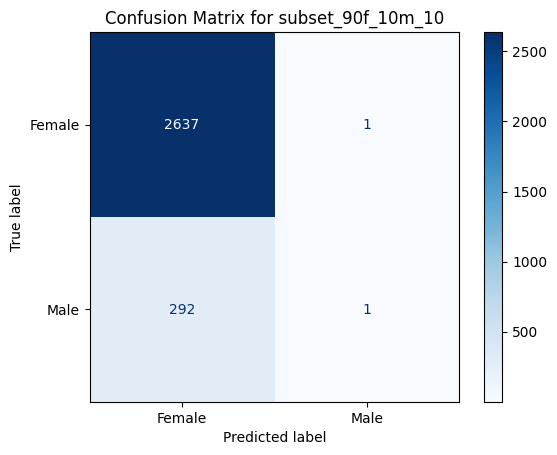

Classification Report for subset_90f_10m_10:
              precision    recall  f1-score   support

      Female       0.90      1.00      0.95      2638
        Male       0.50      0.00      0.01       293

    accuracy                           0.90      2931
   macro avg       0.70      0.50      0.48      2931
weighted avg       0.86      0.90      0.85      2931



In [65]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m_10")

### Calculating bias levels

In [66]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0030


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Accuracy for subset_80f_20m_10: 0.7990


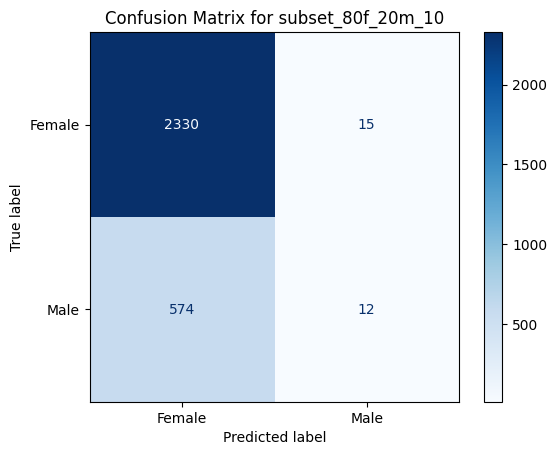

Classification Report for subset_80f_20m_10:
              precision    recall  f1-score   support

      Female       0.80      0.99      0.89      2345
        Male       0.44      0.02      0.04       586

    accuracy                           0.80      2931
   macro avg       0.62      0.51      0.46      2931
weighted avg       0.73      0.80      0.72      2931



In [67]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m_10")

### Calculating bias levels

In [68]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0141


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Accuracy for subset_70f_30m_10: 0.7059


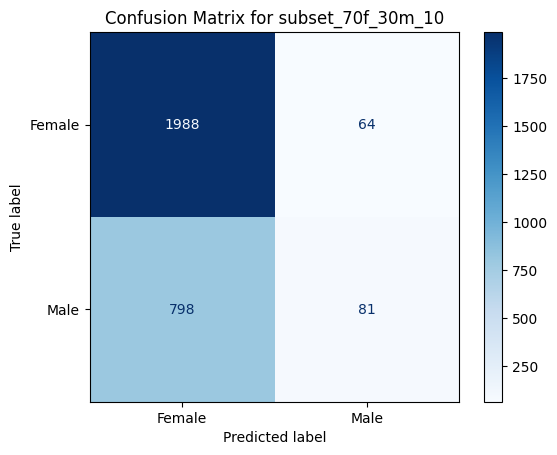

Classification Report for subset_70f_30m_10:
              precision    recall  f1-score   support

      Female       0.71      0.97      0.82      2052
        Male       0.56      0.09      0.16       879

    accuracy                           0.71      2931
   macro avg       0.64      0.53      0.49      2931
weighted avg       0.67      0.71      0.62      2931



In [69]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m_10")

### Calculating bias levels

In [70]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0610


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Accuracy for subset_60f_40m_10: 0.6602


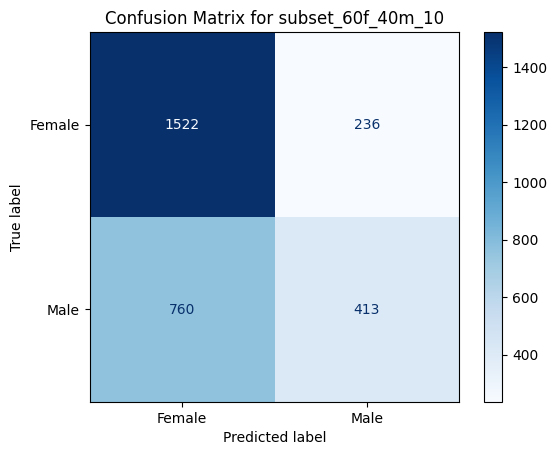

Classification Report for subset_60f_40m_10:
              precision    recall  f1-score   support

      Female       0.67      0.87      0.75      1758
        Male       0.64      0.35      0.45      1173

    accuracy                           0.66      2931
   macro avg       0.65      0.61      0.60      2931
weighted avg       0.65      0.66      0.63      2931



In [71]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m_10")

### Calculating bias levels

In [72]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2178


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Accuracy for subset_50f_50m_10: 0.6523


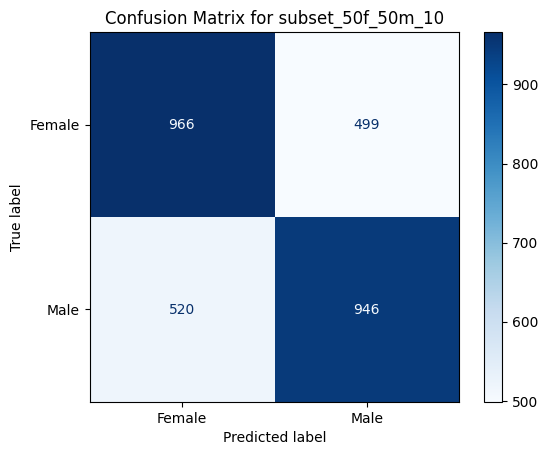

Classification Report for subset_50f_50m_10:
              precision    recall  f1-score   support

      Female       0.65      0.66      0.65      1465
        Male       0.65      0.65      0.65      1466

    accuracy                           0.65      2931
   macro avg       0.65      0.65      0.65      2931
weighted avg       0.65      0.65      0.65      2931



In [73]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m_10")

### Calculating bias levels

In [74]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3047


## APPLYING HYPERPARAMETER TUNING

In [19]:
# Function to train and evaluate the model with hyperparameter tuning
def train_and_evaluate_rf(subset_dir):
    subset_csv = os.path.join(subset_dir, 'subset.csv')
    biased_subset = pd.read_csv(subset_csv)
    
    X = load_images(biased_subset['file'], biased_subset['gender'], subset_dir)
    y = biased_subset['gender'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    
    param_dist = {
        'n_estimators': randint(50, 200),
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5),
        'bootstrap': [True, False]
    }
    
    random_search = RandomizedSearchCV(RandomForestClassifier(random_state=0), param_distributions=param_dist, n_iter=10, cv=5, verbose=2, n_jobs=-1, random_state=0)
    random_search.fit(X_train, y_train)
    
    print(f'Best parameters for {subset_dir}: {random_search.best_params_}')
    
    best_rf_model = random_search.best_estimator_
    y_pred = best_rf_model.predict(X_test)
    
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy for {subset_dir}: {accuracy:.4f}')
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {subset_dir}')
    plt.show()
    
    report = classification_report(y_test, y_pred, target_names=["Female", "Male"])
    print(f'Classification Report for {subset_dir}:\n{report}')
    
    return X_test, y_test, y_pred

### Applying the tuning to the 50:50 male to female ratio using 10% of the dataset

Total images not found: 0
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for subset_50m_50f_10: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 165}
Accuracy for subset_50m_50f_10: 0.6834


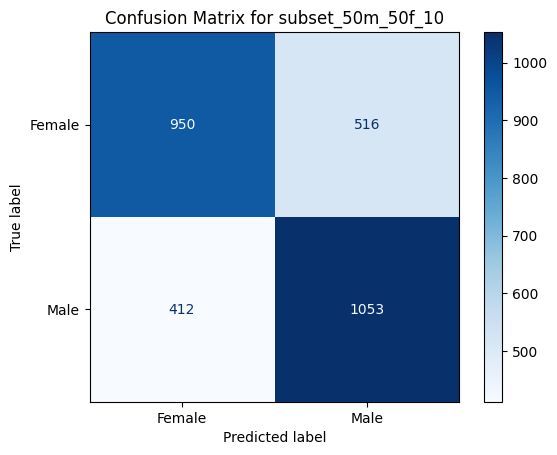

Classification Report for subset_50m_50f_10:
              precision    recall  f1-score   support

      Female       0.70      0.65      0.67      1466
        Male       0.67      0.72      0.69      1465

    accuracy                           0.68      2931
   macro avg       0.68      0.68      0.68      2931
weighted avg       0.68      0.68      0.68      2931



In [92]:
# Calling the train_and_evaluate function

X_test_50, y_test_50, y_pred_50 = train_and_evaluate_rf("subset_50m_50f_10")

In [93]:
# Calling the calculate bias function

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3668


### SWITCHING PRIORITIES

### Applying the tuning to the 50:50 female to male ratio using 10% of the dataset

Total images not found: 0
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for subset_50f_50m_10: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 165}
Accuracy for subset_50f_50m_10: 0.6742


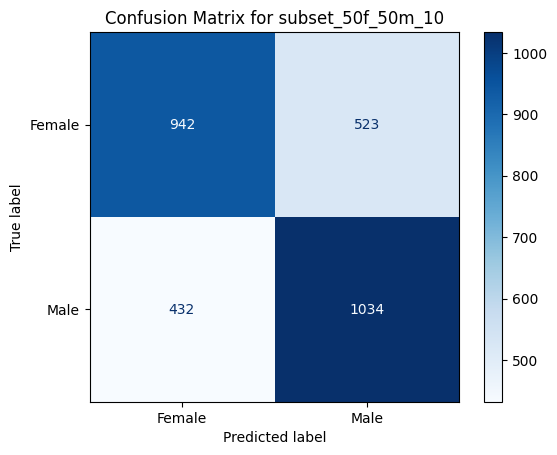

Classification Report for subset_50f_50m_10:
              precision    recall  f1-score   support

      Female       0.69      0.64      0.66      1465
        Male       0.66      0.71      0.68      1466

    accuracy                           0.67      2931
   macro avg       0.67      0.67      0.67      2931
weighted avg       0.67      0.67      0.67      2931



In [94]:
# Calling the train_and_evaluate function

X_test_50, y_test_50, y_pred_50 = train_and_evaluate_rf("subset_50f_50m_10")

In [95]:
# Calling the calculate bias function

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3483


# LOGISTIC REGRESSION

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
# Function to load images and preprocess
def load_images(image_paths, genders, base_dir):
    images = []
    not_found_count = 0
    for path, gender in zip(image_paths, genders):
        img_name = path.split('/')[1]
        gender_dir = 'male' if gender == 1 else 'female'
        img_path = os.path.join(base_dir, gender_dir, img_name)
        
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=(64, 64))  # Resize to 64x64
            img = img_to_array(img)
            img = img.flatten()  # Flatten the image for Logistic Regression
            images.append(img)
        else:
            print(f"Image not found: {img_path}")
            not_found_count += 1
    print(f"Total images not found: {not_found_count}")
    return np.array(images)

In [22]:
# Function to train and evaluate the model
def train_and_evaluate(subset_dir):
    subset_csv = os.path.join(subset_dir, 'subset.csv')
    biased_subset = pd.read_csv(subset_csv)
    
    X = load_images(biased_subset['file'], biased_subset['gender'], subset_dir)
    y = biased_subset['gender'].values
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    
    # Define and train the Logistic Regression model
    lr_model = LogisticRegression(max_iter=1000, random_state=0)
    lr_model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = lr_model.predict(X_test)
    
    # Accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy for {subset_dir}: {accuracy:.4f}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {subset_dir}')
    plt.show()
    
    # Classification Report
    report = classification_report(y_test, y_pred, target_names=["Female", "Male"])
    print(f'Classification Report for {subset_dir}:\n{report}')
    
    # Return the necessary data for bias calculation
    return X_test, y_test, y_pred

In [23]:
# Function to calculate bias
def calculate_bias(X_test, y_test, y_pred):
    # Convert to aif360 BinaryLabelDataset for bias checking
    class ImageGenderDataset(BinaryLabelDataset):
        def __init__(self, df, label_names=['gender'], protected_attribute_names=['gender']):
            super().__init__(df=df, label_names=label_names, protected_attribute_names=protected_attribute_names)
    
    # Create aif360 datasets
    test_numerical_df = pd.DataFrame({'gender': y_test})
    dataset_orig_test = ImageGenderDataset(df=test_numerical_df)
    
    pred_numerical_df = pd.DataFrame({'gender': y_pred})
    dataset_pred = ImageGenderDataset(df=pred_numerical_df)
    
    # Ensure that dataset_pred has the same structure and metadata as dataset_orig_test
    dataset_pred.feature_names = dataset_orig_test.feature_names
    dataset_pred.protected_attribute_names = dataset_orig_test.protected_attribute_names
    dataset_pred.instance_weights = np.copy(dataset_orig_test.instance_weights)
    dataset_pred.protected_attributes = np.copy(dataset_orig_test.protected_attributes)
    dataset_pred.metadata = dataset_orig_test.metadata.copy()
    
    # Metric for model predictions
    metric_pred = ClassificationMetric(
        dataset_orig_test,
        dataset_pred,
        unprivileged_groups=[{'gender': 0}],
        privileged_groups=[{'gender': 1}]
    )
    
    difference = metric_pred.mean_difference()
    formatted_difference = f"{difference:.4f}"
    print(f"Difference in mean outcomes between privileged and unprivileged groups (model predictions): {formatted_difference}")

## Using 50% of the dataset

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Accuracy for subset_90m_10f: 0.8364


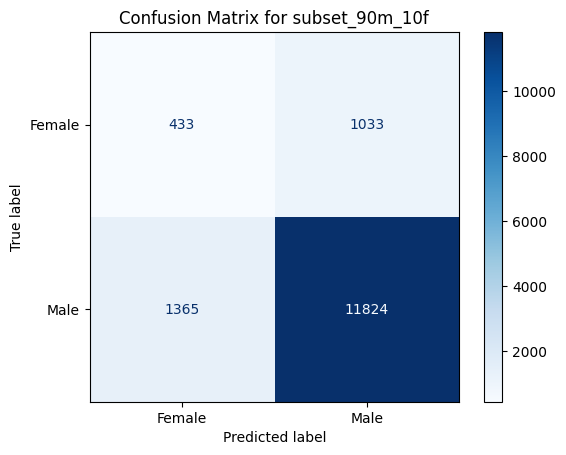

Classification Report for subset_90m_10f:
              precision    recall  f1-score   support

      Female       0.24      0.30      0.27      1466
        Male       0.92      0.90      0.91     13189

    accuracy                           0.84     14655
   macro avg       0.58      0.60      0.59     14655
weighted avg       0.85      0.84      0.84     14655



In [93]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f")

### Calculating bias levels

In [94]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1919


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Accuracy for subset_80m_20f: 0.7721


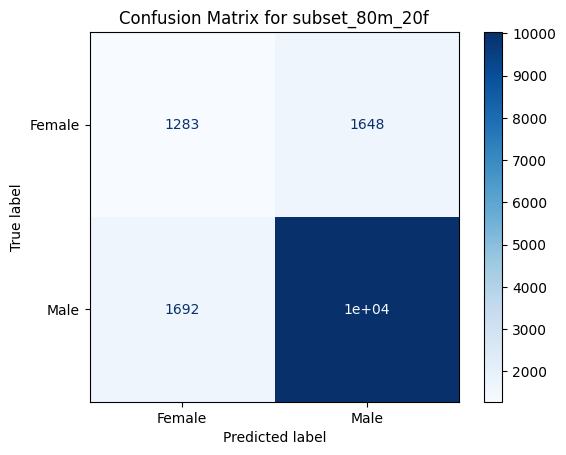

Classification Report for subset_80m_20f:
              precision    recall  f1-score   support

      Female       0.43      0.44      0.43      2931
        Male       0.86      0.86      0.86     11724

    accuracy                           0.77     14655
   macro avg       0.65      0.65      0.65     14655
weighted avg       0.77      0.77      0.77     14655



In [95]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f")

### Calculating bias levels

In [96]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2934


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Accuracy for subset_70m_30f: 0.7316


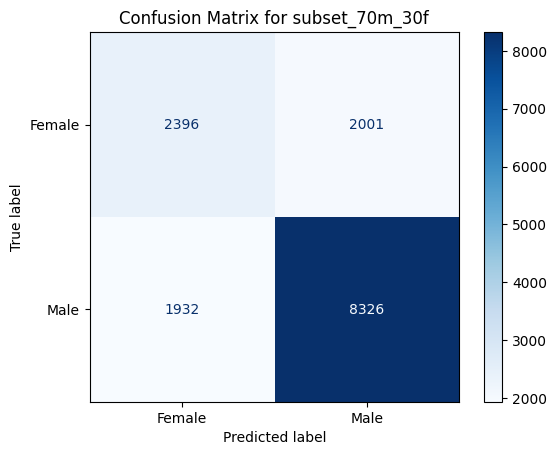

Classification Report for subset_70m_30f:
              precision    recall  f1-score   support

      Female       0.55      0.54      0.55      4397
        Male       0.81      0.81      0.81     10258

    accuracy                           0.73     14655
   macro avg       0.68      0.68      0.68     14655
weighted avg       0.73      0.73      0.73     14655



In [97]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f")

### Calculating bias levels

In [98]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3566


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Accuracy for subset_60m_40f: 0.7028


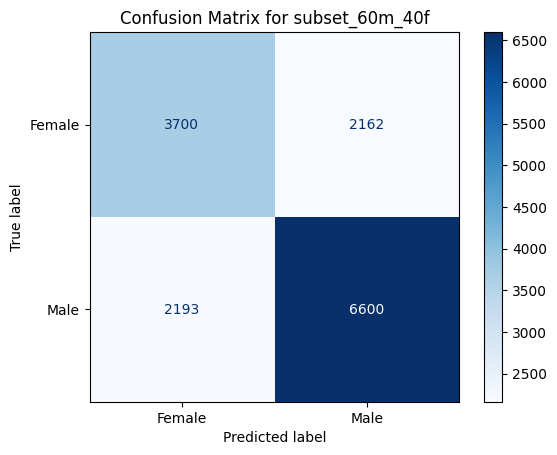

Classification Report for subset_60m_40f:
              precision    recall  f1-score   support

      Female       0.63      0.63      0.63      5862
        Male       0.75      0.75      0.75      8793

    accuracy                           0.70     14655
   macro avg       0.69      0.69      0.69     14655
weighted avg       0.70      0.70      0.70     14655



In [99]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f")

### Calculating bias levels

In [100]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3818


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Accuracy for subset_50m_50f: 0.6974


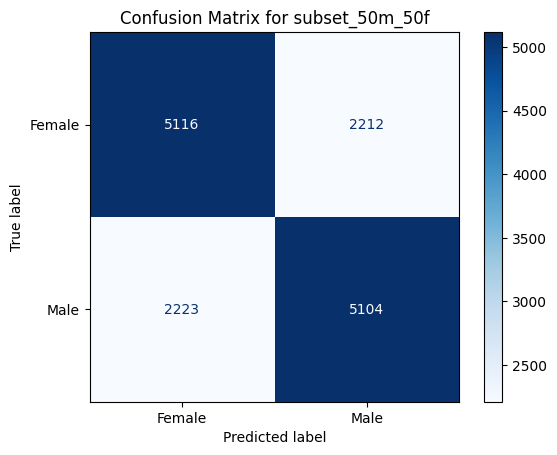

Classification Report for subset_50m_50f:
              precision    recall  f1-score   support

      Female       0.70      0.70      0.70      7328
        Male       0.70      0.70      0.70      7327

    accuracy                           0.70     14655
   macro avg       0.70      0.70      0.70     14655
weighted avg       0.70      0.70      0.70     14655



In [101]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f")

### Calculating bias levels

In [102]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3947


## Using 30% of the dataset

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Accuracy for subset_90m_10f_30: 0.8225


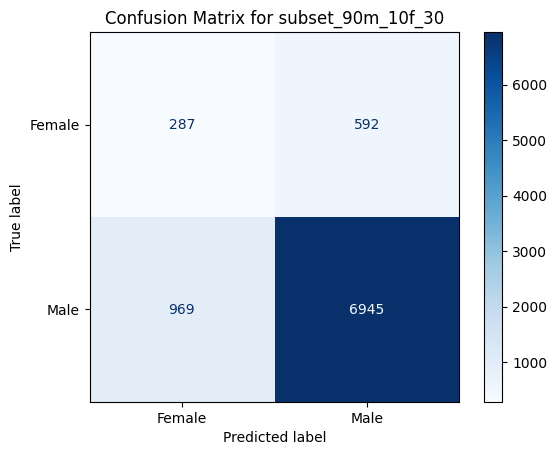

Classification Report for subset_90m_10f_30:
              precision    recall  f1-score   support

      Female       0.23      0.33      0.27       879
        Male       0.92      0.88      0.90      7914

    accuracy                           0.82      8793
   macro avg       0.57      0.60      0.58      8793
weighted avg       0.85      0.82      0.84      8793



In [103]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f_30")

### Calculating bias levels

In [104]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2041


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Accuracy for subset_80m_20f_30: 0.7430


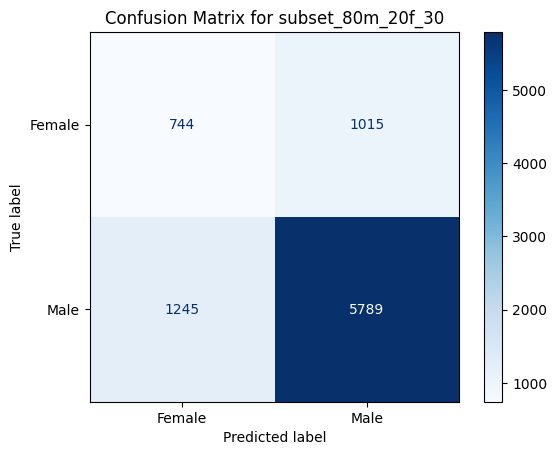

Classification Report for subset_80m_20f_30:
              precision    recall  f1-score   support

      Female       0.37      0.42      0.40      1759
        Male       0.85      0.82      0.84      7034

    accuracy                           0.74      8793
   macro avg       0.61      0.62      0.62      8793
weighted avg       0.76      0.74      0.75      8793



In [105]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f_30")

### Calculating bias levels

In [106]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2460


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Accuracy for subset_70m_30f_30: 0.6902


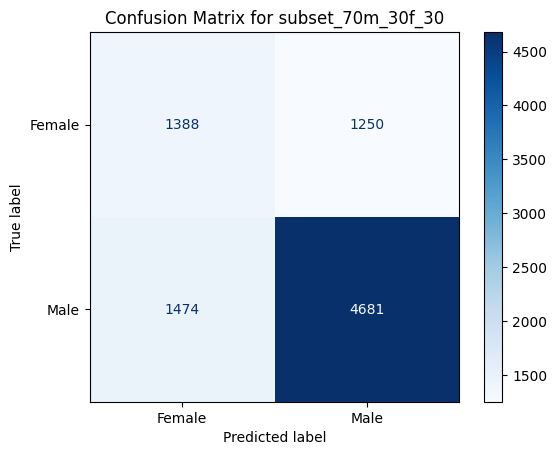

Classification Report for subset_70m_30f_30:
              precision    recall  f1-score   support

      Female       0.48      0.53      0.50      2638
        Male       0.79      0.76      0.77      6155

    accuracy                           0.69      8793
   macro avg       0.64      0.64      0.64      8793
weighted avg       0.70      0.69      0.69      8793



In [107]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f_30")

### Calculating bias levels

In [108]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2867


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Accuracy for subset_60m_40f_30: 0.6737


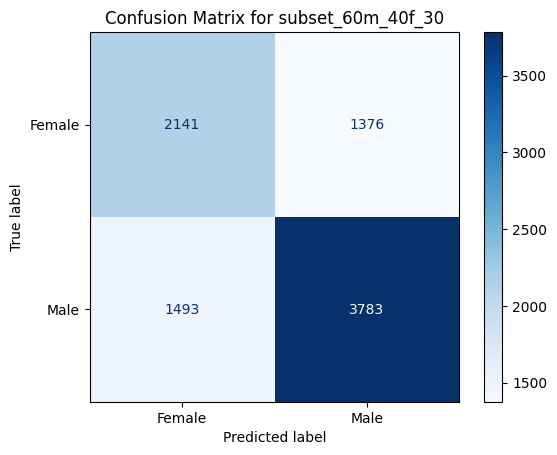

Classification Report for subset_60m_40f_30:
              precision    recall  f1-score   support

      Female       0.59      0.61      0.60      3517
        Male       0.73      0.72      0.73      5276

    accuracy                           0.67      8793
   macro avg       0.66      0.66      0.66      8793
weighted avg       0.68      0.67      0.67      8793



In [109]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f_30")

### Calculating bias levels

In [110]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3258


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Accuracy for subset_50m_50f_30: 0.6694


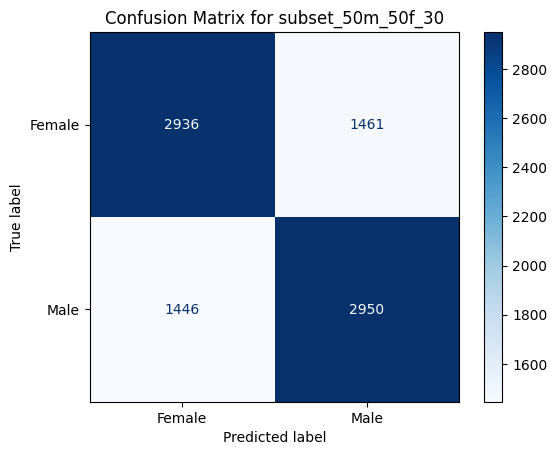

Classification Report for subset_50m_50f_30:
              precision    recall  f1-score   support

      Female       0.67      0.67      0.67      4397
        Male       0.67      0.67      0.67      4396

    accuracy                           0.67      8793
   macro avg       0.67      0.67      0.67      8793
weighted avg       0.67      0.67      0.67      8793



In [111]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f_30")

### Calculating bias levels

In [112]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3388


## Using 10% of the dataset

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Accuracy for subset_90m_10f_10: 0.8427


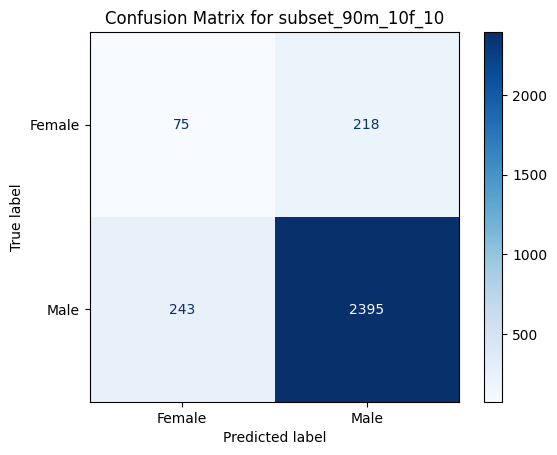

Classification Report for subset_90m_10f_10:
              precision    recall  f1-score   support

      Female       0.24      0.26      0.25       293
        Male       0.92      0.91      0.91      2638

    accuracy                           0.84      2931
   macro avg       0.58      0.58      0.58      2931
weighted avg       0.85      0.84      0.85      2931



In [83]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f_10")

### Calculating bias levels

In [84]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1639


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Accuracy for subset_80m_20f_10: 0.7373


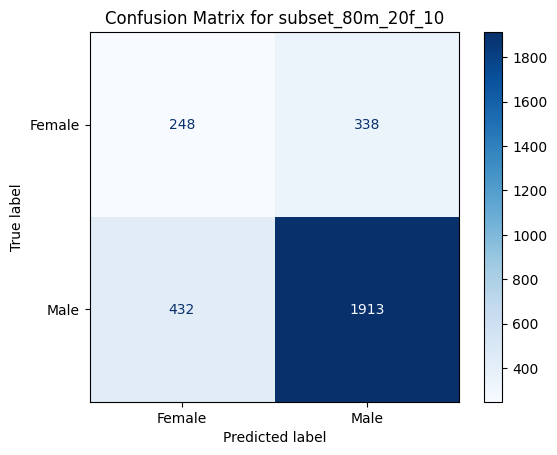

Classification Report for subset_80m_20f_10:
              precision    recall  f1-score   support

      Female       0.36      0.42      0.39       586
        Male       0.85      0.82      0.83      2345

    accuracy                           0.74      2931
   macro avg       0.61      0.62      0.61      2931
weighted avg       0.75      0.74      0.74      2931



In [85]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f_10")

### Calculating bias levels

In [86]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2390


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Accuracy for subset_70m_30f_10: 0.6865


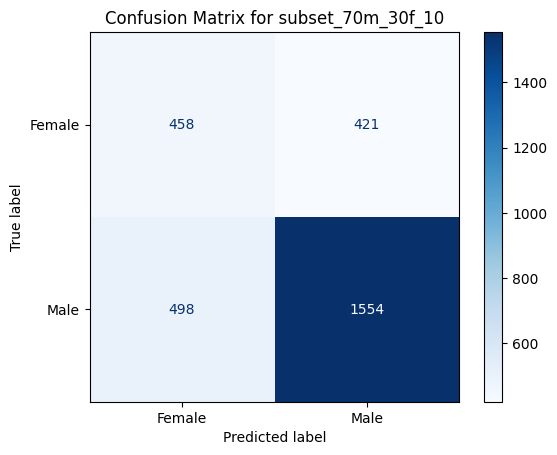

Classification Report for subset_70m_30f_10:
              precision    recall  f1-score   support

      Female       0.48      0.52      0.50       879
        Male       0.79      0.76      0.77      2052

    accuracy                           0.69      2931
   macro avg       0.63      0.64      0.64      2931
weighted avg       0.69      0.69      0.69      2931



In [87]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f_10")

### Calculating bias levels

In [88]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2784


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Accuracy for subset_60m_40f_10: 0.6452


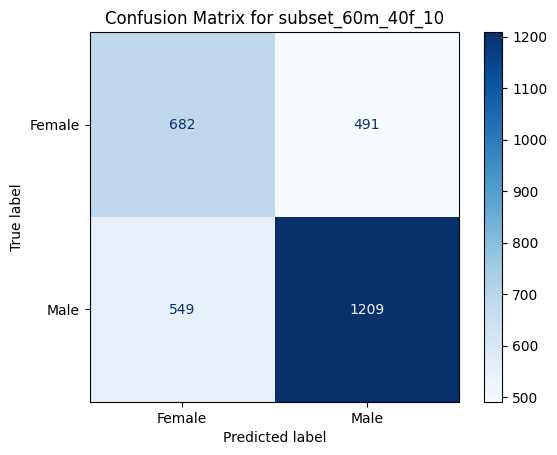

Classification Report for subset_60m_40f_10:
              precision    recall  f1-score   support

      Female       0.55      0.58      0.57      1173
        Male       0.71      0.69      0.70      1758

    accuracy                           0.65      2931
   macro avg       0.63      0.63      0.63      2931
weighted avg       0.65      0.65      0.65      2931



In [89]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f_10")

### Calculating bias levels

In [90]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2691


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Accuracy for subset_50m_50f_10: 0.6520


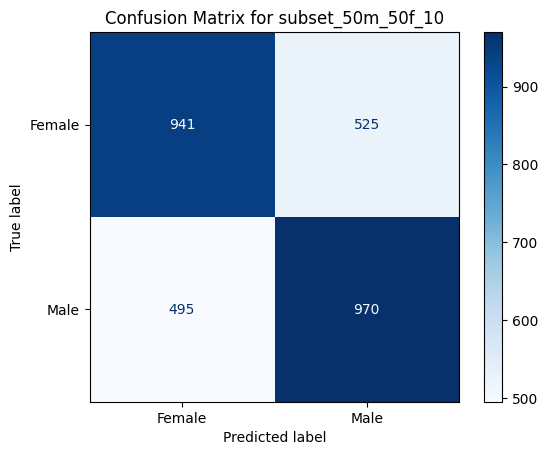

Classification Report for subset_50m_50f_10:
              precision    recall  f1-score   support

      Female       0.66      0.64      0.65      1466
        Male       0.65      0.66      0.66      1465

    accuracy                           0.65      2931
   macro avg       0.65      0.65      0.65      2931
weighted avg       0.65      0.65      0.65      2931



In [91]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f_10")

### Calculating bias levels

In [92]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3040


## SWITCHING PRIORITIES

## Using 50% of the dataset

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Accuracy for subset_90f_10m: 0.8433


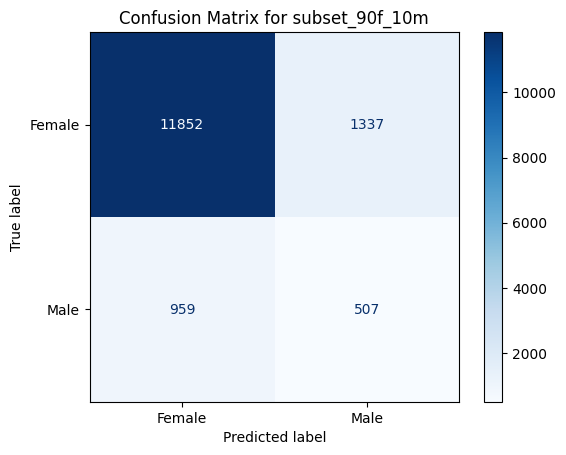

Classification Report for subset_90f_10m:
              precision    recall  f1-score   support

      Female       0.93      0.90      0.91     13189
        Male       0.27      0.35      0.31      1466

    accuracy                           0.84     14655
   macro avg       0.60      0.62      0.61     14655
weighted avg       0.86      0.84      0.85     14655



In [127]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m")

### Calculating bias levels

In [128]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2445


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Accuracy for subset_80f_20m: 0.7769


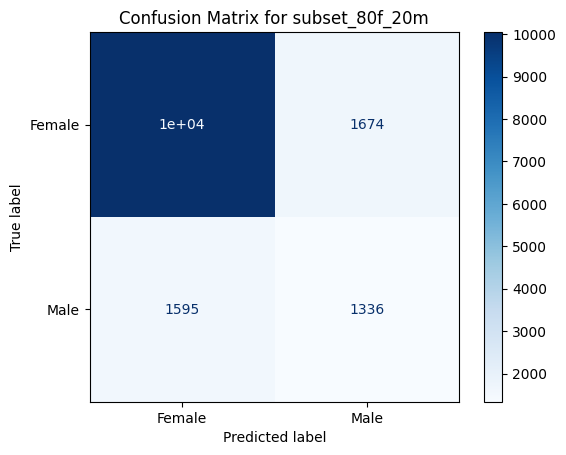

Classification Report for subset_80f_20m:
              precision    recall  f1-score   support

      Female       0.86      0.86      0.86     11724
        Male       0.44      0.46      0.45      2931

    accuracy                           0.78     14655
   macro avg       0.65      0.66      0.65     14655
weighted avg       0.78      0.78      0.78     14655



In [129]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m")

### Calculating bias levels

In [130]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3130


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Accuracy for subset_70f_30m: 0.7401


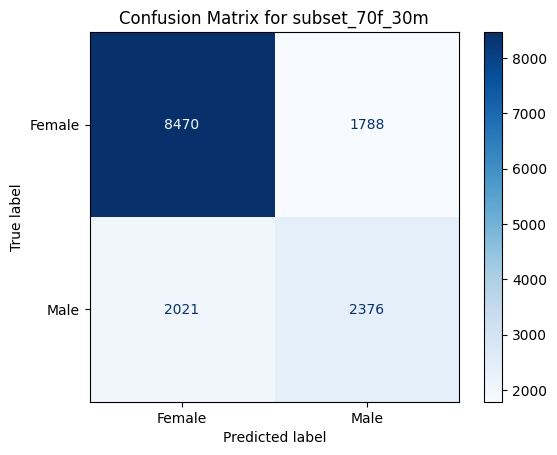

Classification Report for subset_70f_30m:
              precision    recall  f1-score   support

      Female       0.81      0.83      0.82     10258
        Male       0.57      0.54      0.56      4397

    accuracy                           0.74     14655
   macro avg       0.69      0.68      0.69     14655
weighted avg       0.74      0.74      0.74     14655



In [131]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m")

### Calculating bias levels

In [132]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3661


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Accuracy for subset_60f_40m: 0.7205


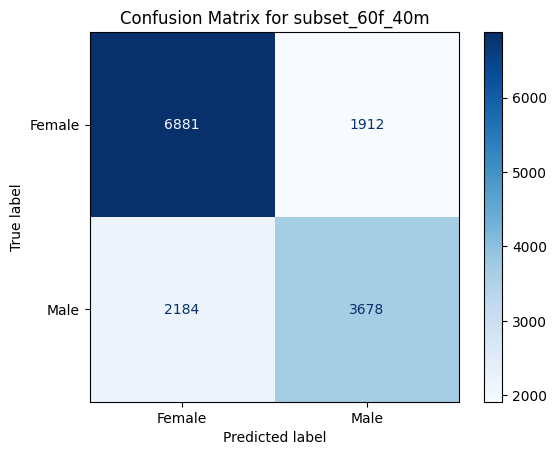

Classification Report for subset_60f_40m:
              precision    recall  f1-score   support

      Female       0.76      0.78      0.77      8793
        Male       0.66      0.63      0.64      5862

    accuracy                           0.72     14655
   macro avg       0.71      0.70      0.71     14655
weighted avg       0.72      0.72      0.72     14655



In [133]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m")

### Calculating bias levels

In [134]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.4100


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Accuracy for subset_50f_50m: 0.7047


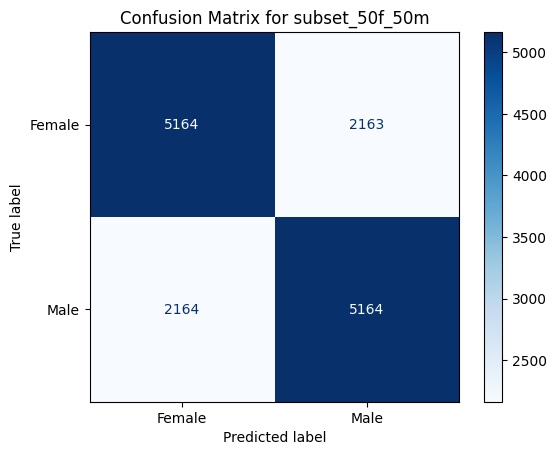

Classification Report for subset_50f_50m:
              precision    recall  f1-score   support

      Female       0.70      0.70      0.70      7327
        Male       0.70      0.70      0.70      7328

    accuracy                           0.70     14655
   macro avg       0.70      0.70      0.70     14655
weighted avg       0.70      0.70      0.70     14655



In [135]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m")

### Calculating bias levels

In [136]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.4095


## Using 30% of the dataset

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Accuracy for subset_90f_10m_30: 0.8319


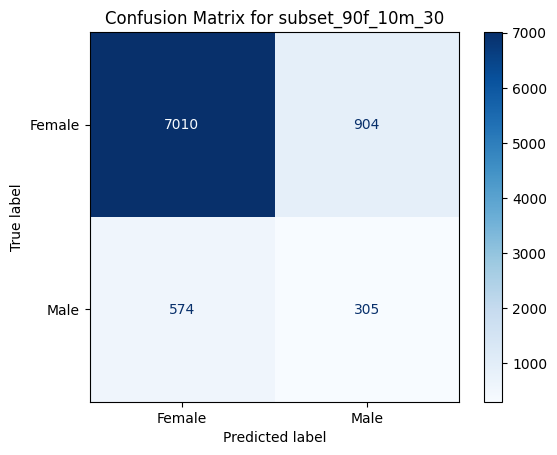

Classification Report for subset_90f_10m_30:
              precision    recall  f1-score   support

      Female       0.92      0.89      0.90      7914
        Male       0.25      0.35      0.29       879

    accuracy                           0.83      8793
   macro avg       0.59      0.62      0.60      8793
weighted avg       0.86      0.83      0.84      8793



In [137]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m_30")

### Calculating bias levels

In [138]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2328


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Accuracy for subset_80f_20m_30: 0.7482


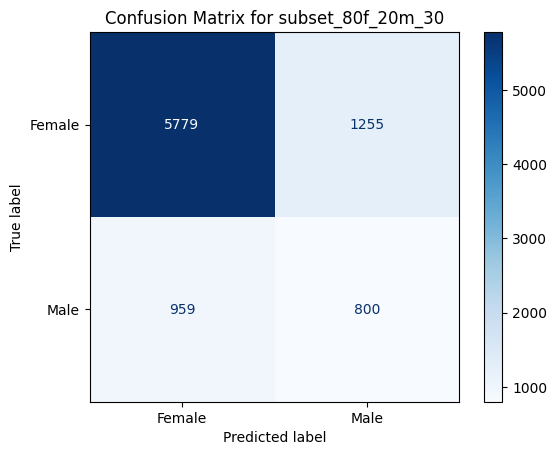

Classification Report for subset_80f_20m_30:
              precision    recall  f1-score   support

      Female       0.86      0.82      0.84      7034
        Male       0.39      0.45      0.42      1759

    accuracy                           0.75      8793
   macro avg       0.62      0.64      0.63      8793
weighted avg       0.76      0.75      0.76      8793



In [139]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m_30")

### Calculating bias levels

In [140]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2764


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Accuracy for subset_70f_30m_30: 0.7050


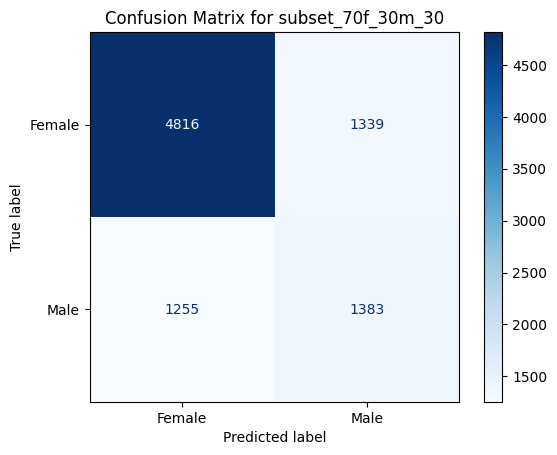

Classification Report for subset_70f_30m_30:
              precision    recall  f1-score   support

      Female       0.79      0.78      0.79      6155
        Male       0.51      0.52      0.52      2638

    accuracy                           0.70      8793
   macro avg       0.65      0.65      0.65      8793
weighted avg       0.71      0.70      0.71      8793



In [141]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m_30")

### Calculating bias levels

In [142]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3067


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Accuracy for subset_60f_40m_30: 0.6762


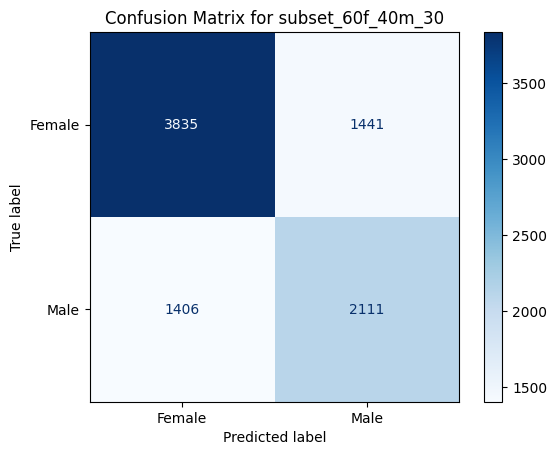

Classification Report for subset_60f_40m_30:
              precision    recall  f1-score   support

      Female       0.73      0.73      0.73      5276
        Male       0.59      0.60      0.60      3517

    accuracy                           0.68      8793
   macro avg       0.66      0.66      0.66      8793
weighted avg       0.68      0.68      0.68      8793



In [143]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m_30")

### Calculating bias levels

In [144]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3271


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Accuracy for subset_50f_50m_30: 0.6661


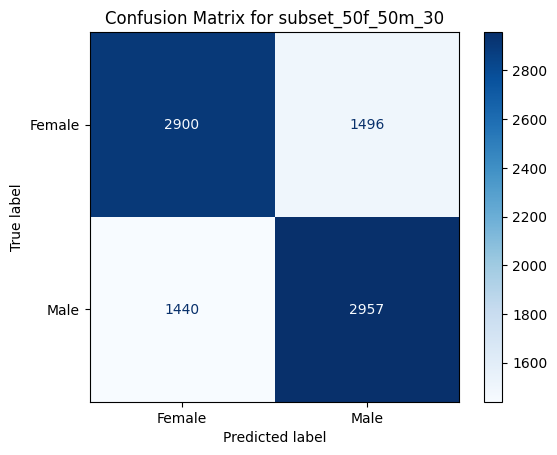

Classification Report for subset_50f_50m_30:
              precision    recall  f1-score   support

      Female       0.67      0.66      0.66      4396
        Male       0.66      0.67      0.67      4397

    accuracy                           0.67      8793
   macro avg       0.67      0.67      0.67      8793
weighted avg       0.67      0.67      0.67      8793



In [145]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m_30")

### Calculating bias levels

In [146]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3322


## Using 10% of the dataset

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Accuracy for subset_90f_10m_10: 0.8434


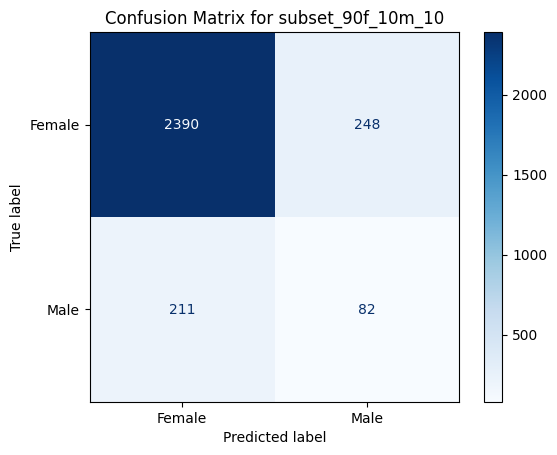

Classification Report for subset_90f_10m_10:
              precision    recall  f1-score   support

      Female       0.92      0.91      0.91      2638
        Male       0.25      0.28      0.26       293

    accuracy                           0.84      2931
   macro avg       0.58      0.59      0.59      2931
weighted avg       0.85      0.84      0.85      2931



In [147]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m_10")

### Calculating bias levels

In [148]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1859


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Accuracy for subset_80f_20m_10: 0.7427


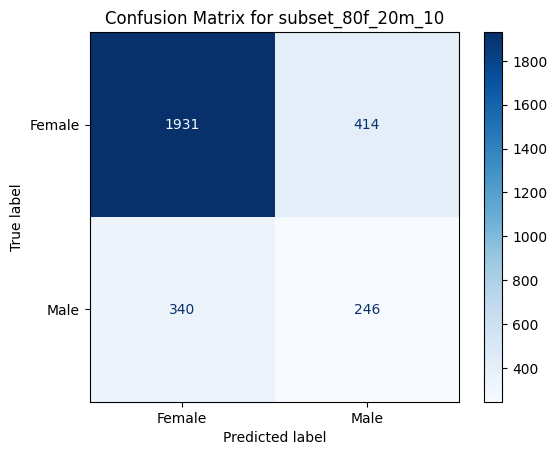

Classification Report for subset_80f_20m_10:
              precision    recall  f1-score   support

      Female       0.85      0.82      0.84      2345
        Male       0.37      0.42      0.39       586

    accuracy                           0.74      2931
   macro avg       0.61      0.62      0.62      2931
weighted avg       0.75      0.74      0.75      2931



In [149]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m_10")

### Calculating bias levels

In [150]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2432


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Accuracy for subset_70f_30m_10: 0.6919


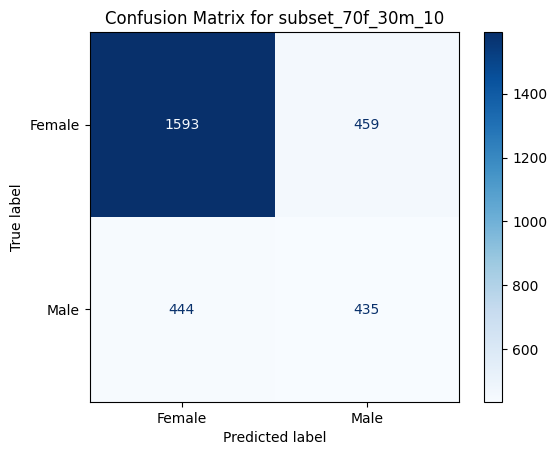

Classification Report for subset_70f_30m_10:
              precision    recall  f1-score   support

      Female       0.78      0.78      0.78      2052
        Male       0.49      0.49      0.49       879

    accuracy                           0.69      2931
   macro avg       0.63      0.64      0.63      2931
weighted avg       0.69      0.69      0.69      2931



In [151]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m_10")

### Calculating bias levels

In [152]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2712


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Accuracy for subset_60f_40m_10: 0.6479


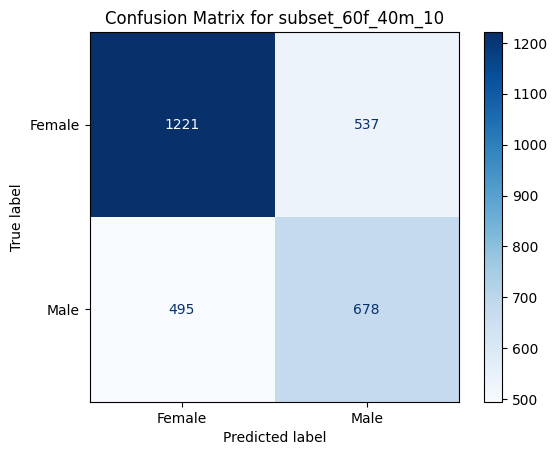

Classification Report for subset_60f_40m_10:
              precision    recall  f1-score   support

      Female       0.71      0.69      0.70      1758
        Male       0.56      0.58      0.57      1173

    accuracy                           0.65      2931
   macro avg       0.63      0.64      0.64      2931
weighted avg       0.65      0.65      0.65      2931



In [153]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m_10")

### Calculating bias levels

In [154]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2725


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Accuracy for subset_50f_50m_10: 0.6564


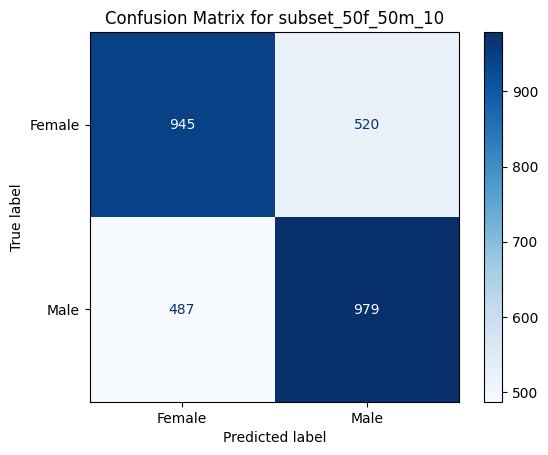

Classification Report for subset_50f_50m_10:
              precision    recall  f1-score   support

      Female       0.66      0.65      0.65      1465
        Male       0.65      0.67      0.66      1466

    accuracy                           0.66      2931
   macro avg       0.66      0.66      0.66      2931
weighted avg       0.66      0.66      0.66      2931



In [155]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m_10")

### Calculating bias levels

In [156]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3129


## APPLYING HYPERPARAMETER TUNING

In [24]:
def train_and_evaluate_lr(subset_dir):
    subset_csv = os.path.join(subset_dir, 'subset.csv')
    biased_subset = pd.read_csv(subset_csv)
    
    X = load_images(biased_subset['file'], biased_subset['gender'], subset_dir)
    y = biased_subset['gender'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    
    param_dist = {
        'C': uniform(0.01, 10),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [500, 1000, 2000]
    }
    
    random_search = RandomizedSearchCV(LogisticRegression(random_state=0), param_distributions=param_dist, n_iter=10, cv=5, verbose=2, n_jobs=-1, random_state=0)
    random_search.fit(X_train, y_train)
    
    print(f'Best parameters for {subset_dir}: {random_search.best_params_}')
    
    best_lr_model = random_search.best_estimator_
    y_pred = best_lr_model.predict(X_test)
    
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy for {subset_dir}: {accuracy:.4f}')
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {subset_dir}')
    plt.show()
    
    report = classification_report(y_test, y_pred, target_names=["Female", "Male"])
    print(f'Classification Report for {subset_dir}:\n{report}')
    
    return X_test, y_test, y_pred

### Applying the tuning to the 50:50 male to female ratio using 10% of the dataset

Total images not found: 0
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for subset_50m_50f_10: {'C': 5.298949197529044, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Accuracy for subset_50m_50f_10: 0.6789


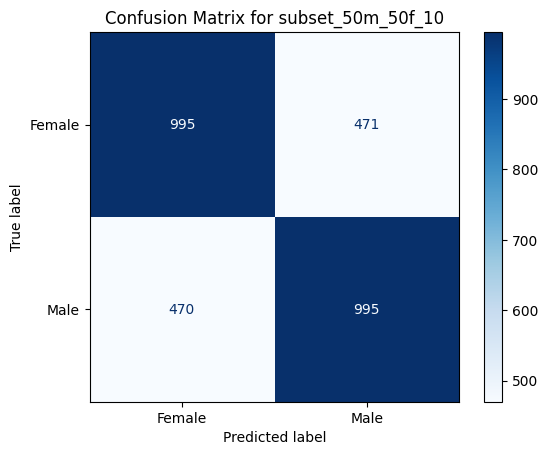

Classification Report for subset_50m_50f_10:
              precision    recall  f1-score   support

      Female       0.68      0.68      0.68      1466
        Male       0.68      0.68      0.68      1465

    accuracy                           0.68      2931
   macro avg       0.68      0.68      0.68      2931
weighted avg       0.68      0.68      0.68      2931



In [83]:
# Calling the train_and_evaluate function

X_test_50, y_test_50, y_pred_50 = train_and_evaluate_lr("subset_50m_50f_10")

In [84]:
# Calling the calculate bias function

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3579


### SWITCHING PRIORITIES

### Applying the tuning to the 50:50 female to male ratio using 10% of the dataset

Total images not found: 0
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for subset_50f_50m_10: {'C': 5.298949197529044, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Accuracy for subset_50f_50m_10: 0.6721


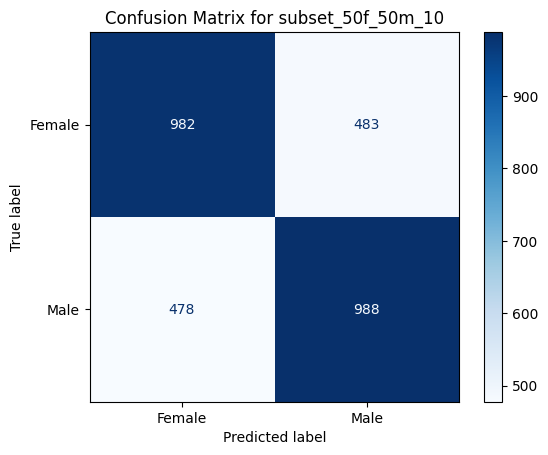

Classification Report for subset_50f_50m_10:
              precision    recall  f1-score   support

      Female       0.67      0.67      0.67      1465
        Male       0.67      0.67      0.67      1466

    accuracy                           0.67      2931
   macro avg       0.67      0.67      0.67      2931
weighted avg       0.67      0.67      0.67      2931



In [85]:
# Calling the train_and_evaluate function

X_test_50, y_test_50, y_pred_50 = train_and_evaluate_lr("subset_50f_50m_10")

In [86]:
# Calling the calculate bias function

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.3442


# DECISION TREE

In [8]:
from sklearn.tree import DecisionTreeClassifier

In [9]:
# Function to load images and preprocess
def load_images(image_paths, genders, base_dir):
    images = []
    not_found_count = 0
    for path, gender in zip(image_paths, genders):
        img_name = path.split('/')[1]
        gender_dir = 'male' if gender == 1 else 'female'
        img_path = os.path.join(base_dir, gender_dir, img_name)
        
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=(64, 64))  # Resize to 64x64
            img = img_to_array(img)
            img = img.flatten()  # Flatten the image for Decision Tree
            images.append(img)
        else:
            print(f"Image not found: {img_path}")
            not_found_count += 1
    print(f"Total images not found: {not_found_count}")
    return np.array(images)

In [27]:
# Function to train and evaluate the model
def train_and_evaluate(subset_dir):
    subset_csv = os.path.join(subset_dir, 'subset.csv')
    biased_subset = pd.read_csv(subset_csv)
    
    X = load_images(biased_subset['file'], biased_subset['gender'], subset_dir)
    y = biased_subset['gender'].values
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    
    # Define and train the Decision Tree model
    dt_model = DecisionTreeClassifier(random_state=0)
    dt_model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = dt_model.predict(X_test)
    
    # Accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy for {subset_dir}: {accuracy:.4f}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {subset_dir}')
    plt.show()
    
    # Classification Report
    report = classification_report(y_test, y_pred, target_names=["Female", "Male"])
    print(f'Classification Report for {subset_dir}:\n{report}')
    
    # Return the necessary data for bias calculation
    return X_test, y_test, y_pred

In [28]:
# Function to calculate bias
def calculate_bias(X_test, y_test, y_pred):
    # Convert to aif360 BinaryLabelDataset for bias checking
    class ImageGenderDataset(BinaryLabelDataset):
        def __init__(self, df, label_names=['gender'], protected_attribute_names=['gender']):
            super().__init__(df=df, label_names=label_names, protected_attribute_names=protected_attribute_names)
    
    # Create aif360 datasets
    test_numerical_df = pd.DataFrame({'gender': y_test})
    dataset_orig_test = ImageGenderDataset(df=test_numerical_df)
    
    pred_numerical_df = pd.DataFrame({'gender': y_pred})
    dataset_pred = ImageGenderDataset(df=pred_numerical_df)
    
    # Ensure that dataset_pred has the same structure and metadata as dataset_orig_test
    dataset_pred.feature_names = dataset_orig_test.feature_names
    dataset_pred.protected_attribute_names = dataset_orig_test.protected_attribute_names
    dataset_pred.instance_weights = np.copy(dataset_orig_test.instance_weights)
    dataset_pred.protected_attributes = np.copy(dataset_orig_test.protected_attributes)
    dataset_pred.metadata = dataset_orig_test.metadata.copy()
    
    # Metric for model predictions
    metric_pred = ClassificationMetric(
        dataset_orig_test,
        dataset_pred,
        unprivileged_groups=[{'gender': 0}],
        privileged_groups=[{'gender': 1}]
    )
    
    difference = metric_pred.mean_difference()
    formatted_difference = f"{difference:.4f}"
    print(f"Difference in mean outcomes between privileged and unprivileged groups (model predictions): {formatted_difference}")

## Using 50% of the dataset

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Accuracy for subset_90m_10f: 0.8203


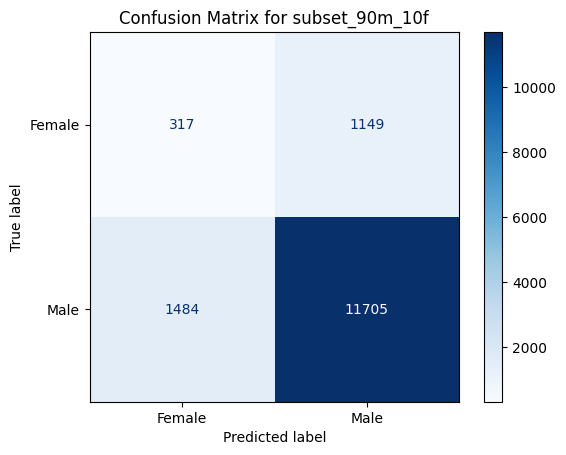

Classification Report for subset_90m_10f:
              precision    recall  f1-score   support

      Female       0.18      0.22      0.19      1466
        Male       0.91      0.89      0.90     13189

    accuracy                           0.82     14655
   macro avg       0.54      0.55      0.55     14655
weighted avg       0.84      0.82      0.83     14655



In [161]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f")

### Calculating bias levels

In [162]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1037


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Accuracy for subset_80m_20f: 0.7280


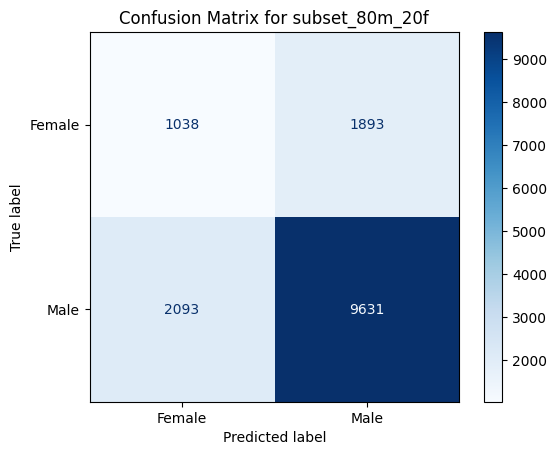

Classification Report for subset_80m_20f:
              precision    recall  f1-score   support

      Female       0.33      0.35      0.34      2931
        Male       0.84      0.82      0.83     11724

    accuracy                           0.73     14655
   macro avg       0.58      0.59      0.59     14655
weighted avg       0.73      0.73      0.73     14655



In [163]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f")

### Calculating bias levels

In [164]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1756


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Accuracy for subset_70m_30f: 0.6588


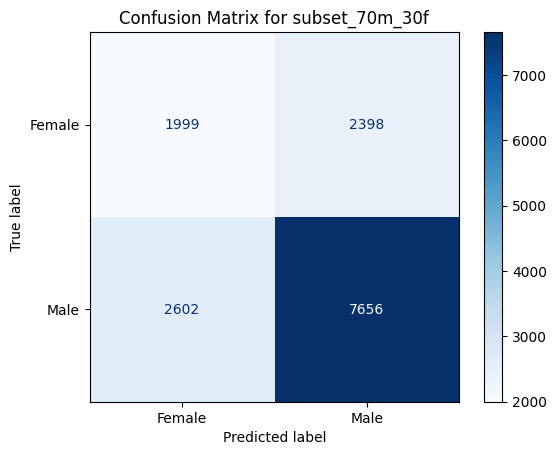

Classification Report for subset_70m_30f:
              precision    recall  f1-score   support

      Female       0.43      0.45      0.44      4397
        Male       0.76      0.75      0.75     10258

    accuracy                           0.66     14655
   macro avg       0.60      0.60      0.60     14655
weighted avg       0.66      0.66      0.66     14655



In [165]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f")

### Calculating bias levels

In [166]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2010


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Accuracy for subset_60m_40f: 0.6173


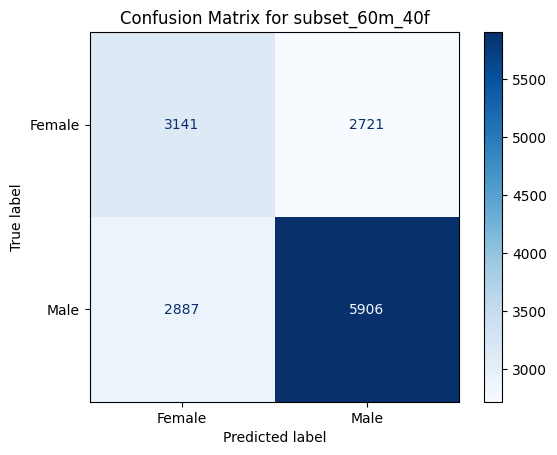

Classification Report for subset_60m_40f:
              precision    recall  f1-score   support

      Female       0.52      0.54      0.53      5862
        Male       0.68      0.67      0.68      8793

    accuracy                           0.62     14655
   macro avg       0.60      0.60      0.60     14655
weighted avg       0.62      0.62      0.62     14655



In [167]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f")

### Calculating bias levels

In [168]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2075


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Accuracy for subset_50m_50f: 0.6156


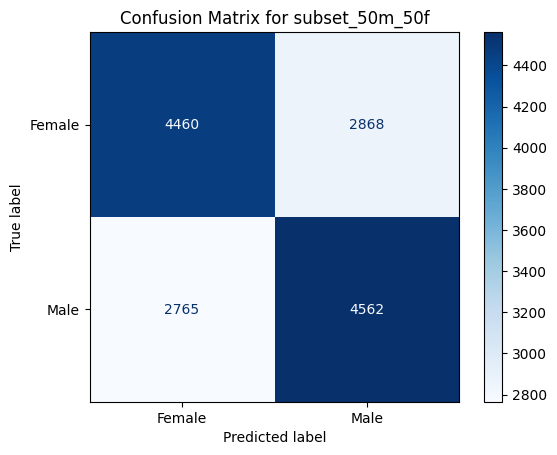

Classification Report for subset_50m_50f:
              precision    recall  f1-score   support

      Female       0.62      0.61      0.61      7328
        Male       0.61      0.62      0.62      7327

    accuracy                           0.62     14655
   macro avg       0.62      0.62      0.62     14655
weighted avg       0.62      0.62      0.62     14655



In [169]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f")

### Calculating bias levels

In [170]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2313


## Using 30% of the dataset

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Accuracy for subset_90m_10f_30: 0.8207


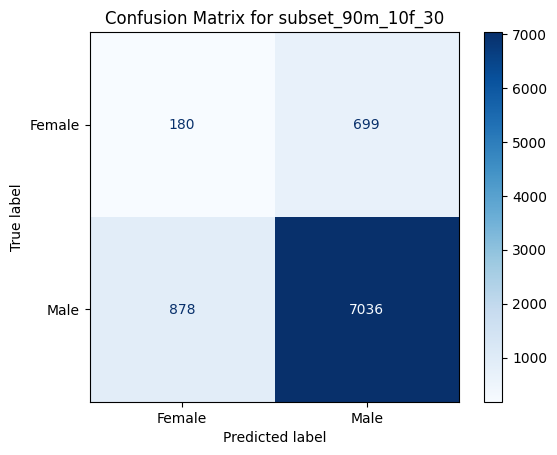

Classification Report for subset_90m_10f_30:
              precision    recall  f1-score   support

      Female       0.17      0.20      0.19       879
        Male       0.91      0.89      0.90      7914

    accuracy                           0.82      8793
   macro avg       0.54      0.55      0.54      8793
weighted avg       0.84      0.82      0.83      8793



In [171]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f_30")

### Calculating bias levels

In [172]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0938


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Accuracy for subset_80m_20f_30: 0.7102


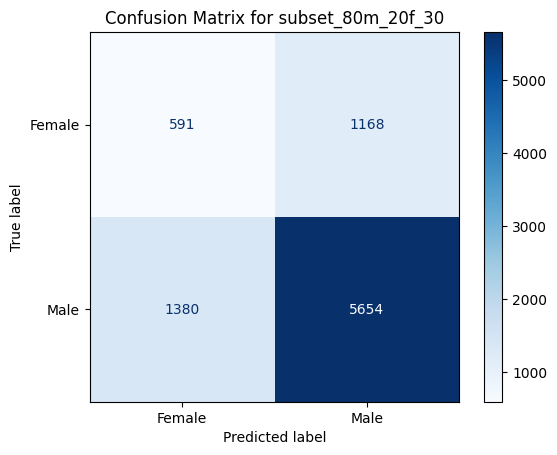

Classification Report for subset_80m_20f_30:
              precision    recall  f1-score   support

      Female       0.30      0.34      0.32      1759
        Male       0.83      0.80      0.82      7034

    accuracy                           0.71      8793
   macro avg       0.56      0.57      0.57      8793
weighted avg       0.72      0.71      0.72      8793



In [173]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f_30")

### Calculating bias levels

In [174]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1398


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Accuracy for subset_70m_30f_30: 0.6443


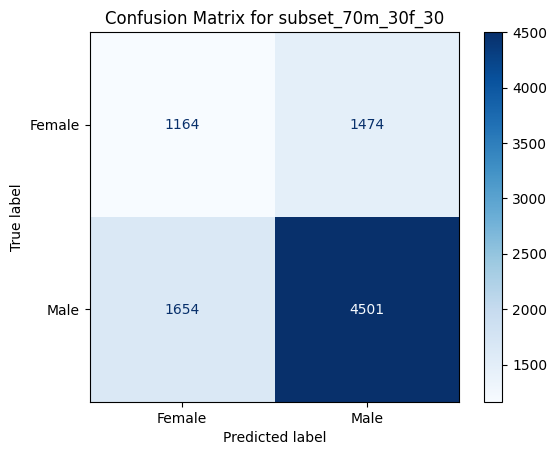

Classification Report for subset_70m_30f_30:
              precision    recall  f1-score   support

      Female       0.41      0.44      0.43      2638
        Male       0.75      0.73      0.74      6155

    accuracy                           0.64      8793
   macro avg       0.58      0.59      0.58      8793
weighted avg       0.65      0.64      0.65      8793



In [175]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f_30")

### Calculating bias levels

In [176]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1725


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Accuracy for subset_60m_40f_30: 0.5950


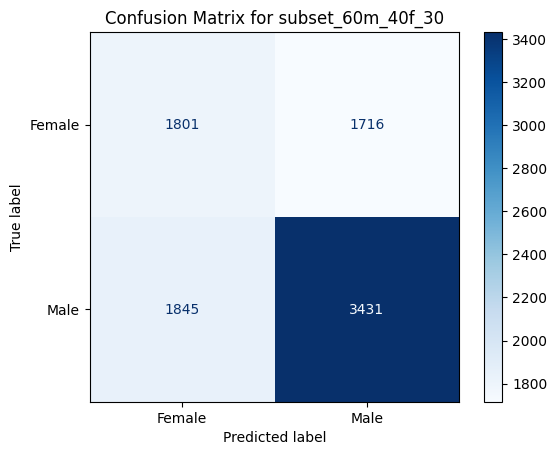

Classification Report for subset_60m_40f_30:
              precision    recall  f1-score   support

      Female       0.49      0.51      0.50      3517
        Male       0.67      0.65      0.66      5276

    accuracy                           0.60      8793
   macro avg       0.58      0.58      0.58      8793
weighted avg       0.60      0.60      0.60      8793



In [177]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f_30")

### Calculating bias levels

In [178]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1624


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Accuracy for subset_50m_50f_30: 0.5955


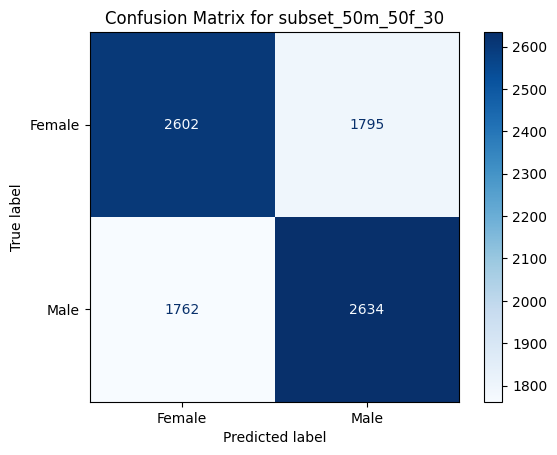

Classification Report for subset_50m_50f_30:
              precision    recall  f1-score   support

      Female       0.60      0.59      0.59      4397
        Male       0.59      0.60      0.60      4396

    accuracy                           0.60      8793
   macro avg       0.60      0.60      0.60      8793
weighted avg       0.60      0.60      0.60      8793



In [179]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f_30")

### Calculating bias levels

In [180]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1909


## Using 10% of the dataset

### Training and evaluating subset with 90% males and 10% females

Total images not found: 0
Accuracy for subset_90m_10f_10: 0.8048


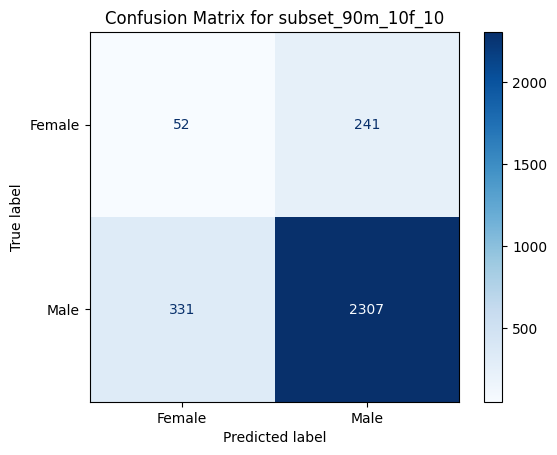

Classification Report for subset_90m_10f_10:
              precision    recall  f1-score   support

      Female       0.14      0.18      0.15       293
        Male       0.91      0.87      0.89      2638

    accuracy                           0.80      2931
   macro avg       0.52      0.53      0.52      2931
weighted avg       0.83      0.80      0.82      2931



In [181]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90m_10f_10")

### Calculating bias levels

In [182]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0520


### Training and evaluating subset with 80% males and 20% females

Total images not found: 0
Accuracy for subset_80m_20f_10: 0.6987


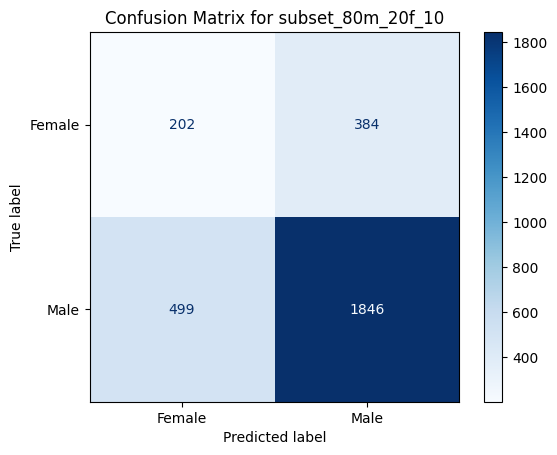

Classification Report for subset_80m_20f_10:
              precision    recall  f1-score   support

      Female       0.29      0.34      0.31       586
        Male       0.83      0.79      0.81      2345

    accuracy                           0.70      2931
   macro avg       0.56      0.57      0.56      2931
weighted avg       0.72      0.70      0.71      2931



In [183]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80m_20f_10")

### Calculating bias levels

In [184]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1319


### Training and evaluating subset with 70% males and 30% females

Total images not found: 0
Accuracy for subset_70m_30f_10: 0.6370


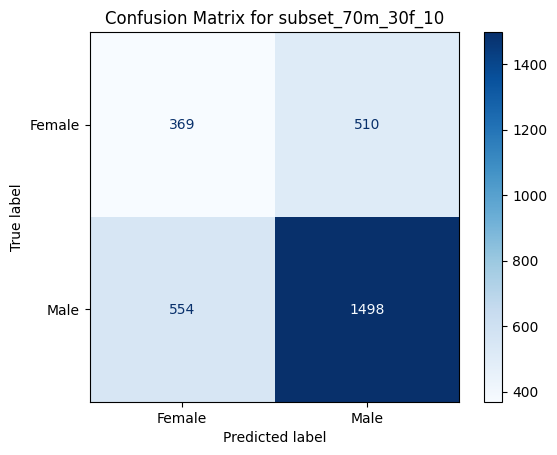

Classification Report for subset_70m_30f_10:
              precision    recall  f1-score   support

      Female       0.40      0.42      0.41       879
        Male       0.75      0.73      0.74      2052

    accuracy                           0.64      2931
   macro avg       0.57      0.57      0.57      2931
weighted avg       0.64      0.64      0.64      2931



In [185]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70m_30f_10")

### Calculating bias levels

In [186]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1498


### Training and evaluating subset with 60% males and 40% females

Total images not found: 0
Accuracy for subset_60m_40f_10: 0.5954


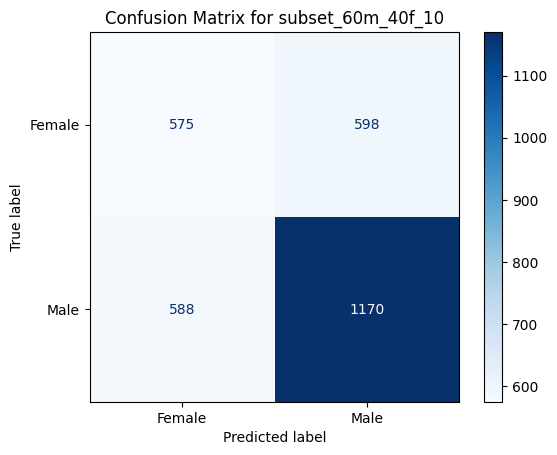

Classification Report for subset_60m_40f_10:
              precision    recall  f1-score   support

      Female       0.49      0.49      0.49      1173
        Male       0.66      0.67      0.66      1758

    accuracy                           0.60      2931
   macro avg       0.58      0.58      0.58      2931
weighted avg       0.59      0.60      0.60      2931



In [187]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60m_40f_10")

### Calculating bias levels

In [188]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1557


### Training and evaluating subset with 50% males and 50% females

Total images not found: 0
Accuracy for subset_50m_50f_10: 0.5786


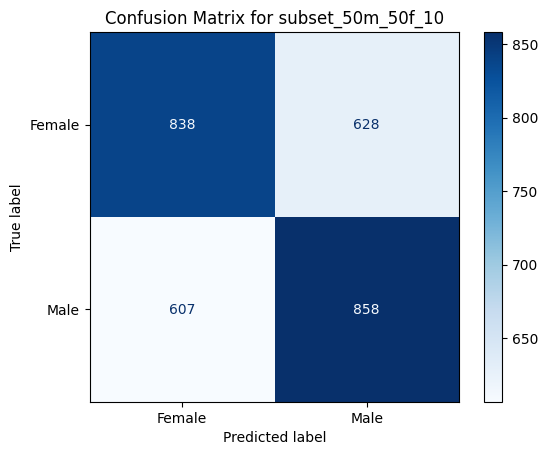

Classification Report for subset_50m_50f_10:
              precision    recall  f1-score   support

      Female       0.58      0.57      0.58      1466
        Male       0.58      0.59      0.58      1465

    accuracy                           0.58      2931
   macro avg       0.58      0.58      0.58      2931
weighted avg       0.58      0.58      0.58      2931



In [189]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50m_50f_10")

### Calculating bias levels

In [190]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1573


## SWITCHING PRIORITIES

## Using 50% of the dataset

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Accuracy for subset_90f_10m: 0.8158


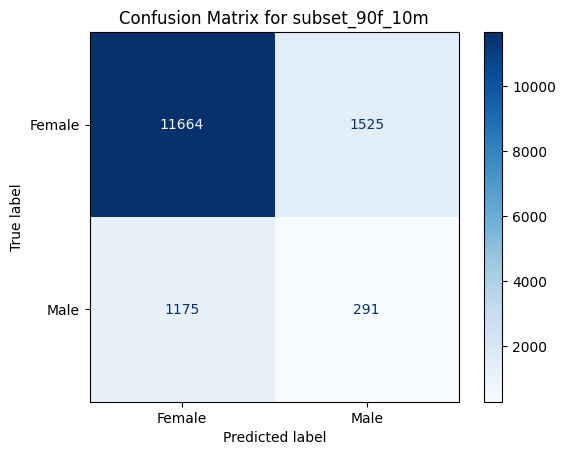

Classification Report for subset_90f_10m:
              precision    recall  f1-score   support

      Female       0.91      0.88      0.90     13189
        Male       0.16      0.20      0.18      1466

    accuracy                           0.82     14655
   macro avg       0.53      0.54      0.54     14655
weighted avg       0.83      0.82      0.82     14655



In [191]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m")

### Calculating bias levels

In [192]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0829


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Accuracy for subset_80f_20m: 0.7153


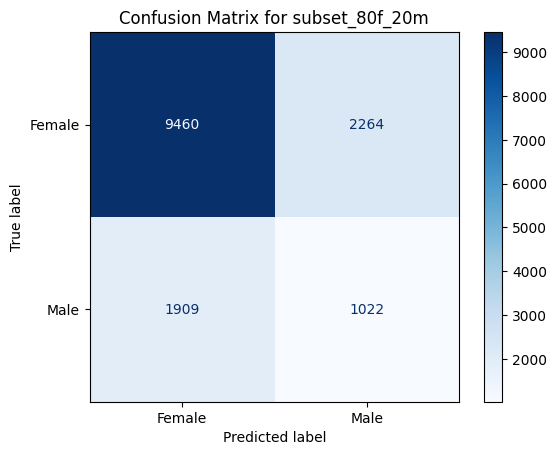

Classification Report for subset_80f_20m:
              precision    recall  f1-score   support

      Female       0.83      0.81      0.82     11724
        Male       0.31      0.35      0.33      2931

    accuracy                           0.72     14655
   macro avg       0.57      0.58      0.57     14655
weighted avg       0.73      0.72      0.72     14655



In [193]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m")

### Calculating bias levels

In [194]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1556


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Accuracy for subset_70f_30m: 0.6594


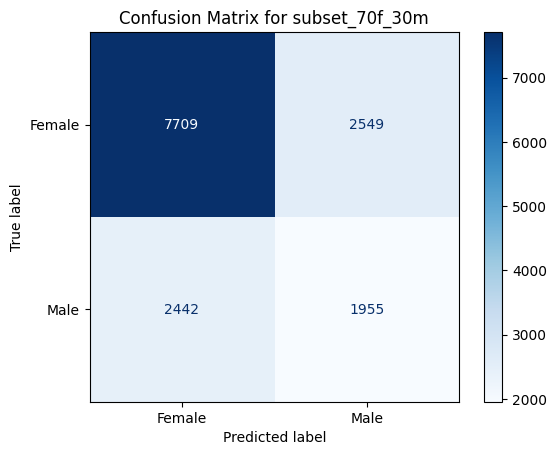

Classification Report for subset_70f_30m:
              precision    recall  f1-score   support

      Female       0.76      0.75      0.76     10258
        Male       0.43      0.44      0.44      4397

    accuracy                           0.66     14655
   macro avg       0.60      0.60      0.60     14655
weighted avg       0.66      0.66      0.66     14655



In [195]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m")

### Calculating bias levels

In [196]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1961


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Accuracy for subset_60f_40m: 0.6142


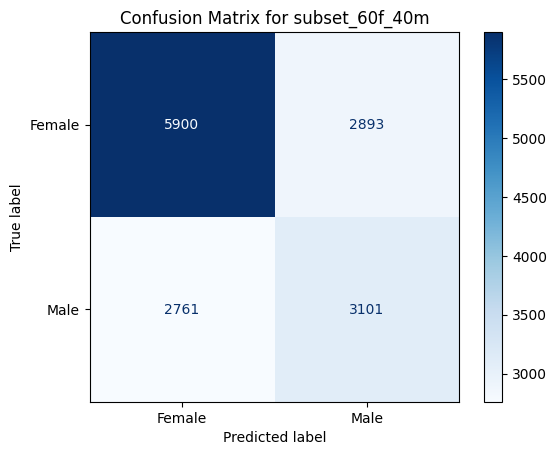

Classification Report for subset_60f_40m:
              precision    recall  f1-score   support

      Female       0.68      0.67      0.68      8793
        Male       0.52      0.53      0.52      5862

    accuracy                           0.61     14655
   macro avg       0.60      0.60      0.60     14655
weighted avg       0.62      0.61      0.61     14655



In [197]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m")

### Calculating bias levels

In [198]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2000


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Accuracy for subset_50f_50m: 0.6096


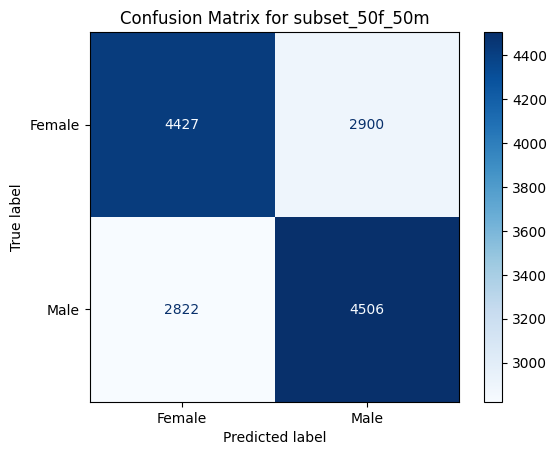

Classification Report for subset_50f_50m:
              precision    recall  f1-score   support

      Female       0.61      0.60      0.61      7327
        Male       0.61      0.61      0.61      7328

    accuracy                           0.61     14655
   macro avg       0.61      0.61      0.61     14655
weighted avg       0.61      0.61      0.61     14655



In [199]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m")

### Calculating bias levels

In [200]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.2191


## Using 30% of the dataset

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Accuracy for subset_90f_10m_30: 0.8178


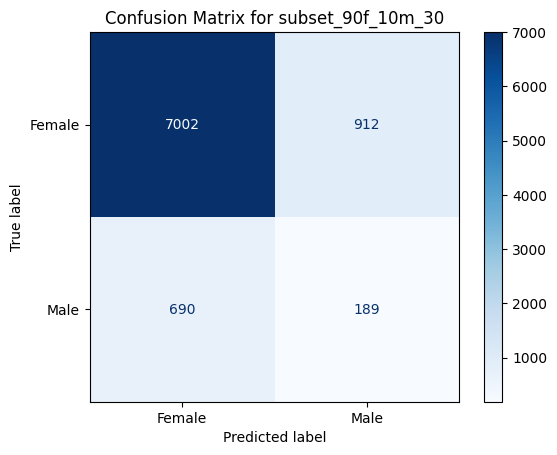

Classification Report for subset_90f_10m_30:
              precision    recall  f1-score   support

      Female       0.91      0.88      0.90      7914
        Male       0.17      0.22      0.19       879

    accuracy                           0.82      8793
   macro avg       0.54      0.55      0.54      8793
weighted avg       0.84      0.82      0.83      8793



In [201]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m_30")

### Calculating bias levels

In [202]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0998


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Accuracy for subset_80f_20m_30: 0.7134


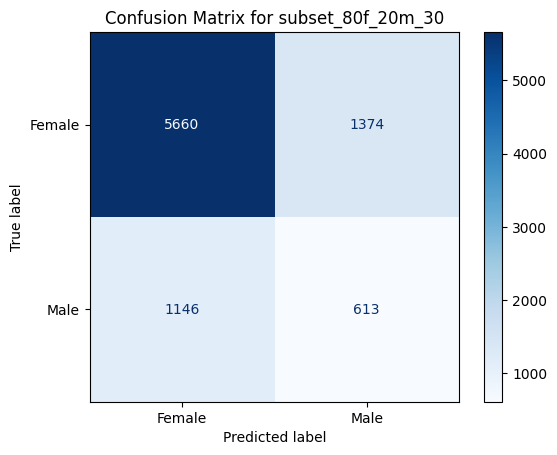

Classification Report for subset_80f_20m_30:
              precision    recall  f1-score   support

      Female       0.83      0.80      0.82      7034
        Male       0.31      0.35      0.33      1759

    accuracy                           0.71      8793
   macro avg       0.57      0.58      0.57      8793
weighted avg       0.73      0.71      0.72      8793



In [203]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m_30")

### Calculating bias levels

In [204]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1532


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Accuracy for subset_70f_30m_30: 0.6453


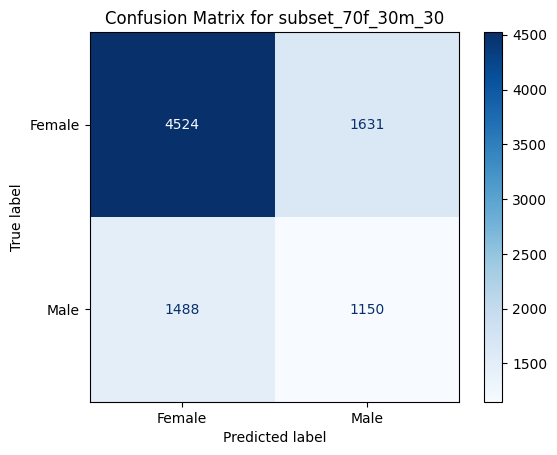

Classification Report for subset_70f_30m_30:
              precision    recall  f1-score   support

      Female       0.75      0.74      0.74      6155
        Male       0.41      0.44      0.42      2638

    accuracy                           0.65      8793
   macro avg       0.58      0.59      0.58      8793
weighted avg       0.65      0.65      0.65      8793



In [205]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m_30")

### Calculating bias levels

In [206]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1709


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Accuracy for subset_60f_40m_30: 0.6068


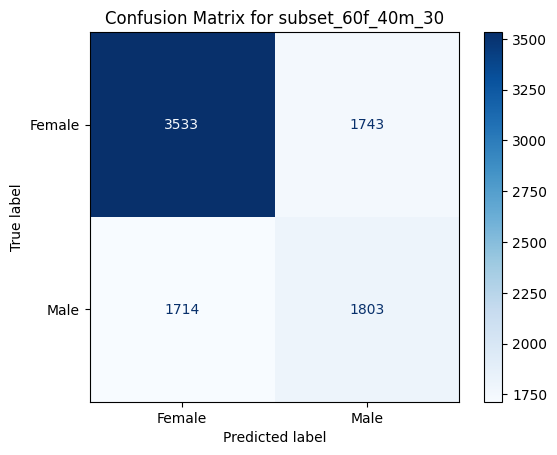

Classification Report for subset_60f_40m_30:
              precision    recall  f1-score   support

      Female       0.67      0.67      0.67      5276
        Male       0.51      0.51      0.51      3517

    accuracy                           0.61      8793
   macro avg       0.59      0.59      0.59      8793
weighted avg       0.61      0.61      0.61      8793



In [207]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m_30")

### Calculating bias levels

In [208]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1823


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Accuracy for subset_50f_50m_30: 0.5794


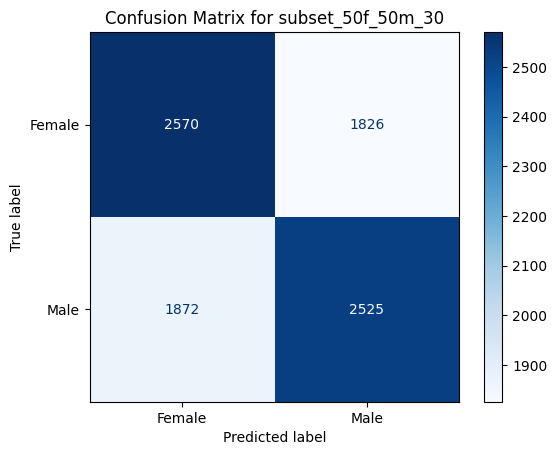

Classification Report for subset_50f_50m_30:
              precision    recall  f1-score   support

      Female       0.58      0.58      0.58      4396
        Male       0.58      0.57      0.58      4397

    accuracy                           0.58      8793
   macro avg       0.58      0.58      0.58      8793
weighted avg       0.58      0.58      0.58      8793



In [209]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m_30")

### Calculating bias levels

In [210]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1589


## Using 10% of the dataset

### Training and evaluating subset with 90% females and 10% males

Total images not found: 0
Accuracy for subset_90f_10m_10: 0.8066


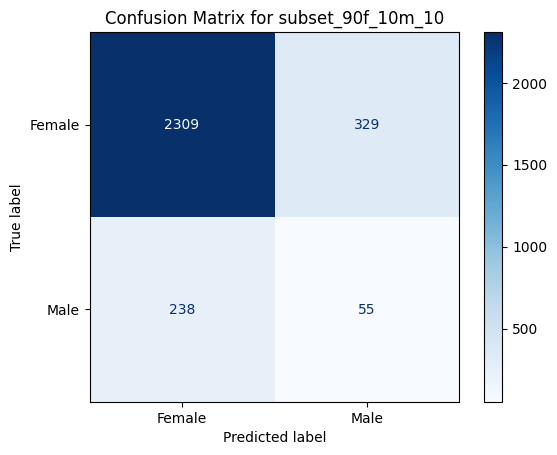

Classification Report for subset_90f_10m_10:
              precision    recall  f1-score   support

      Female       0.91      0.88      0.89      2638
        Male       0.14      0.19      0.16       293

    accuracy                           0.81      2931
   macro avg       0.52      0.53      0.53      2931
weighted avg       0.83      0.81      0.82      2931



In [211]:
# Calling the functions for each subset

# For subset_90m_10f

X_test_90, y_test_90, y_pred_90 = train_and_evaluate("subset_90f_10m_10")

### Calculating bias levels

In [212]:
# Calculating bias 

calculate_bias(X_test_90, y_test_90, y_pred_90)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.0630


### Training and evaluating subset with 80% females and 20% males

Total images not found: 0
Accuracy for subset_80f_20m_10: 0.6960


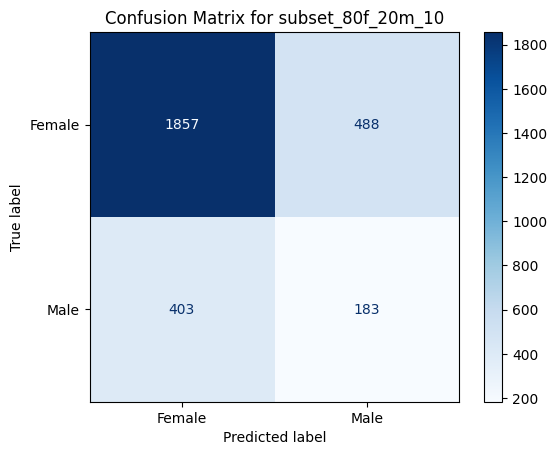

Classification Report for subset_80f_20m_10:
              precision    recall  f1-score   support

      Female       0.82      0.79      0.81      2345
        Male       0.27      0.31      0.29       586

    accuracy                           0.70      2931
   macro avg       0.55      0.55      0.55      2931
weighted avg       0.71      0.70      0.70      2931



In [213]:
# For subset_80m_20f

X_test_80, y_test_80, y_pred_80 = train_and_evaluate("subset_80f_20m_10")

### Calculating bias levels

In [214]:
# Calculating bias

calculate_bias(X_test_80, y_test_80, y_pred_80)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1042


### Training and evaluating subset with 70% females and 30% males

Total images not found: 0
Accuracy for subset_70f_30m_10: 0.6271


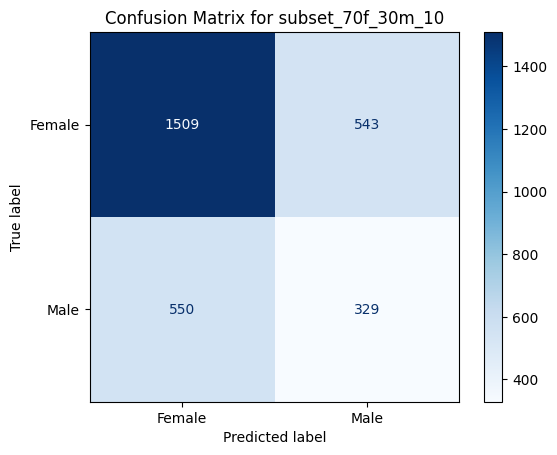

Classification Report for subset_70f_30m_10:
              precision    recall  f1-score   support

      Female       0.73      0.74      0.73      2052
        Male       0.38      0.37      0.38       879

    accuracy                           0.63      2931
   macro avg       0.56      0.55      0.55      2931
weighted avg       0.63      0.63      0.63      2931



In [215]:
# For subset_70m_30f

X_test_70, y_test_70, y_pred_70 = train_and_evaluate("subset_70f_30m_10")

### Calculating bias levels

In [216]:
# Calculating bias

calculate_bias(X_test_70, y_test_70, y_pred_70)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1097


### Training and evaluating subset with 60% females and 40% males

Total images not found: 0
Accuracy for subset_60f_40m_10: 0.5797


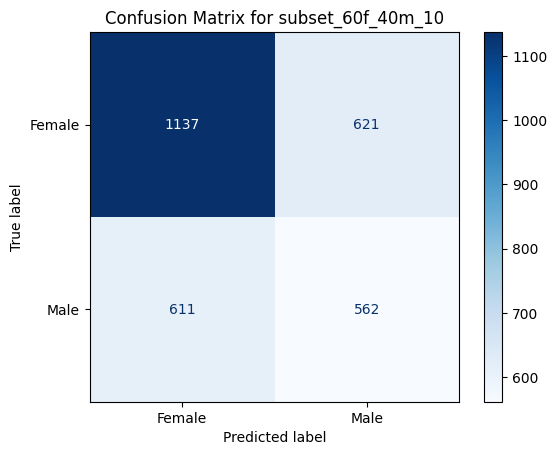

Classification Report for subset_60f_40m_10:
              precision    recall  f1-score   support

      Female       0.65      0.65      0.65      1758
        Male       0.48      0.48      0.48      1173

    accuracy                           0.58      2931
   macro avg       0.56      0.56      0.56      2931
weighted avg       0.58      0.58      0.58      2931



In [217]:
# For subset_60m_40f

X_test_60, y_test_60, y_pred_60 = train_and_evaluate("subset_60f_40m_10")

### Calculating bias levels

In [218]:
# Calculating bias

calculate_bias(X_test_60, y_test_60, y_pred_60)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1259


### Training and evaluating subset with 50% females and 50% males

Total images not found: 0
Accuracy for subset_50f_50m_10: 0.5650


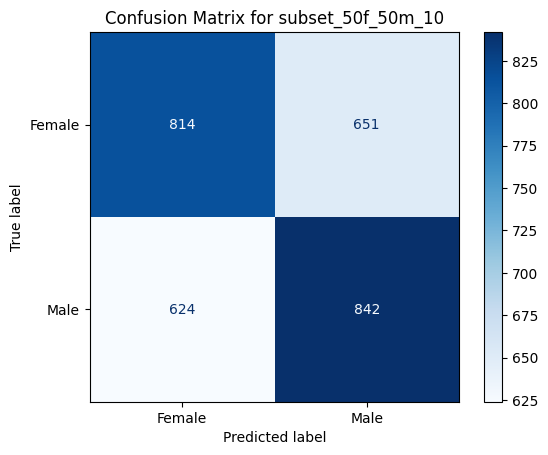

Classification Report for subset_50f_50m_10:
              precision    recall  f1-score   support

      Female       0.57      0.56      0.56      1465
        Male       0.56      0.57      0.57      1466

    accuracy                           0.56      2931
   macro avg       0.57      0.56      0.56      2931
weighted avg       0.57      0.56      0.56      2931



In [219]:
# For subset_50m_50f

X_test_50, y_test_50, y_pred_50 = train_and_evaluate("subset_50f_50m_10")

### Calculating bias levels

In [220]:
# Calculating bias

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1300


## APPLYING HYPERPARAMETER TUNING

In [29]:
def train_and_evaluate_dt(subset_dir):
    subset_csv = os.path.join(subset_dir, 'subset.csv')
    biased_subset = pd.read_csv(subset_csv)
    
    X = load_images(biased_subset['file'], biased_subset['gender'], subset_dir)
    y = biased_subset['gender'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    
    param_dist = {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5),
        'criterion': ['gini', 'entropy']
    }
    
    random_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=0), param_distributions=param_dist, n_iter=10, cv=5, verbose=2, n_jobs=-1, random_state=0)
    random_search.fit(X_train, y_train)
    
    print(f'Best parameters for {subset_dir}: {random_search.best_params_}')
    
    best_dt_model = random_search.best_estimator_
    y_pred = best_dt_model.predict(X_test)
    
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy for {subset_dir}: {accuracy:.4f}')
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {subset_dir}')
    plt.show()
    
    report = classification_report(y_test, y_pred, target_names=["Female", "Male"])
    print(f'Classification Report for {subset_dir}:\n{report}')
    
    return X_test, y_test, y_pred

### Applying the tuning to the 50:50 male to female ratio using 10% of the dataset

Total images not found: 0
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for subset_50m_50f_10: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Accuracy for subset_50m_50f_10: 0.5803


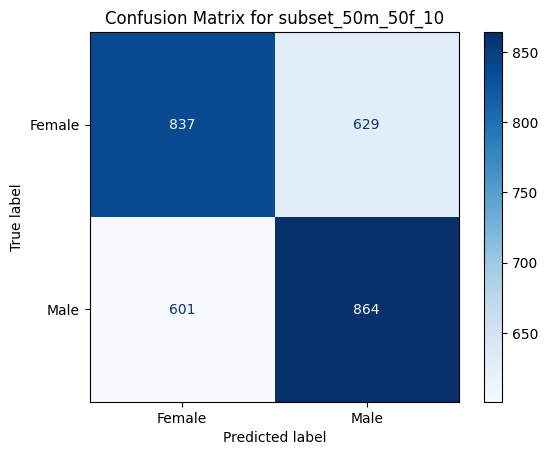

Classification Report for subset_50m_50f_10:
              precision    recall  f1-score   support

      Female       0.58      0.57      0.58      1466
        Male       0.58      0.59      0.58      1465

    accuracy                           0.58      2931
   macro avg       0.58      0.58      0.58      2931
weighted avg       0.58      0.58      0.58      2931



In [72]:
# Calling the train_and_evaluate function

X_test_50, y_test_50, y_pred_50 = train_and_evaluate_dt("subset_50m_50f_10")

In [73]:
# Calling the calculate bias function

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1607


### SWITCHING PRIORITIES

### Applying the tuning to the 50:50 female to male ratio using 10% of the dataset

Total images not found: 0
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for subset_50f_50m_10: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Accuracy for subset_50f_50m_10: 0.5742


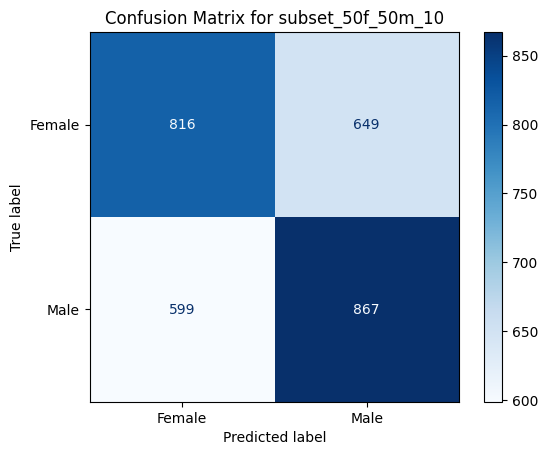

Classification Report for subset_50f_50m_10:
              precision    recall  f1-score   support

      Female       0.58      0.56      0.57      1465
        Male       0.57      0.59      0.58      1466

    accuracy                           0.57      2931
   macro avg       0.57      0.57      0.57      2931
weighted avg       0.57      0.57      0.57      2931



In [70]:
# Calling the train_and_evaluate function

X_test_50, y_test_50, y_pred_50 = train_and_evaluate_dt("subset_50f_50m_10")

In [71]:
# Calling the calculate bias function

calculate_bias(X_test_50, y_test_50, y_pred_50)

Difference in mean outcomes between privileged and unprivileged groups (model predictions): -0.1484
